<h1> DYNAMIC MALWARE CLASSIFICATION</h1>

Supervised, classification, multi-class

# 0. Basic Set-Up and General info

Note: there are a lot of non-used imports (to be removed at the end)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from scipy import stats

import copy

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [3]:
from imblearn.over_sampling import SMOTENC
from boruta import BorutaPy


In [4]:
import importlib

# Import your modules initially
import library.pipeline

# Reload the modules in case they were updated
importlib.reload(library.pipeline)

# Now you can import specific classes/functions
from library.pipeline.pipeline import Pipeline
from library.pipeline.pipeline_manager import PipelineManager

## Documentation Standarization
Follow the following guidelines to make sure our document is consistent and easier to undestand
- All constant should be writte in full capitall letters (e.g: MY_CONSTANT). Notebook-level constants should be written in the cell assigned to it (see below)
- Every new major section (EDA, Feature engineering) should be written with '# My title'#
- Subsequent sections should use '##', '###' or '####' hierarchacically
- At the beginning of each major section write a content index with the content included in that section (see 'feature engineering' section as an example)
- Please write paragraphs before and after each cell explain what u are about to do and the conclusions, correspondingly. Do not assume they are too obvious.
- Avoid excessive ChatGPT-originated comments
- Avoid writing more than 20 lines per code cell (exceptions for subroutines, which should be written in utilitied_functions.py)
- Ideally, add a "Questions" and "Things to be done" section in each major sections where u write about futher iterations u want to do (while sharing in with the rest)


## Set-up

In [5]:
dataset_path ="./dataset/dynamic_dataset.csv"
results_path = "results/results.csv"

In [6]:
metrics_to_evaluate = ["accuracy", "precision", "recall", "f1-score"]

We start off with a pipeline for all the models. Then at some moment, whenever we think the pipelines will diverge, we remove the by-object-refrence (that we will create in the next cell), and create a new copy with our modifications ready.

In [7]:
default_pipeline = ensembled_pipeline = tree_pipeline = linear_pipeline = baseline_pipeline = example = Pipeline(
                        dataset_path=dataset_path, 
                        results_path=results_path,
                        model_type="classification",
                        metrics_to_evaluate=metrics_to_evaluate)

In [8]:
pipelines = {
            "models": {
                  "ensembled": ensembled_pipeline,
                  "tree-based": tree_pipeline,
                  "linear": linear_pipeline,
                  }, 
            "baseline": {
                  "logistic": baseline_pipeline, 
                  "example":  example               
            }
}
pipeline_manager = PipelineManager(pipelines)

Here I show an example of how we will be working with by-object-reference.

In [9]:
baseline_pipeline.dataset.example_attribute = "1"

In [10]:
default_pipeline.dataset.example_attribute

'1'

However, if we do a (deep) copy:
Note that the difference between a deep and a shallow copy is that the former copies all the objects that are inside the class. We need that.
We will overwrite the prior attribute and show is this is not propagated to the other results anymore

In [11]:
new_pipeline = copy.deepcopy(default_pipeline)
new_pipeline.dataset.example_attribute = "2"

In [12]:
default_pipeline.dataset.example_attribute

'1'

It may also be of interest for you to propagate the same method's invokation to all the pipelines within the pipeline manager. For instance, after a divergence in, lets say, feature scaling, you may need to fit all the models in the corresponding pipelines. You would want to avoid reduntandly calling the same method with the same parameters for all the Pipeline class instances. In order to do so, we present an example that avoids such annoyance

In [13]:
pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="example", print_results=True)

Pipeline example in category baseline has diverged
 Pipeline schema is now: {'models': {'ensembled': <library.pipeline.pipeline.Pipeline object at 0x000001DEC4F8BBF0>, 'tree-based': <library.pipeline.pipeline.Pipeline object at 0x000001DEC4F8BBF0>, 'linear': <library.pipeline.pipeline.Pipeline object at 0x000001DEC4F8BBF0>}, 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline object at 0x000001DEC4F8BBF0>, 'example': <library.pipeline.pipeline.Pipeline object at 0x000001DEC4EE2E70>}}


In [14]:
pipeline_manager.pipelines["baseline"]["example"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd")

Whats goooddd from 2056324434976. You are at automatic feature selection!


In [15]:
pipeline_manager.all_pipelines_execute(methodName="speak", message="Hello, world!")

Hello, world! from 2056299002864
Hello, world! from 2056298311280


{'models': {'ensembled': None}, 'baseline': {'example': None}}

A method present deeper down the class:

Instead of doing:
'pipeline_manager.pipelines["baseline"]["logistic"].feature_analysis.feature_selection.automatic_feature_selection.speak("Whats goooddd") for all objects'

we can do:

In [16]:
pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_selection.automatic_feature_selection.speak", message="Whats good")

Whats good from 2056318223376. You are at automatic feature selection!
Whats good from 2056324434976. You are at automatic feature selection!


{'models': {'ensembled': None}, 'baseline': {'example': None}}

In [17]:
# lets delete the example obj
del new_pipeline 
del pipeline_manager.pipelines["baseline"]["example"]

In [18]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>}}

<hr>

# Start Of The Pipeline

In [19]:
default_pipeline.dataset.df.head()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Hash,Category,Family,reboot
0,31053,2448,14044,23472,74824,2452,0,8919,4786,4132,...,1635,2351,3285,1551,11221,193,f460abb8f2e4e3fb689966ddaea6d6babbd1738bb691c7...,Trojan_SMS,opfake,before
1,107787,21976,11852,74548,69052,23152,0,25341,20965,4375,...,1816,826,1544,2045,8457,189,556c238536d837007e647543eaf3ea95ae9aaf1c1a52d0...,Trojan_SMS,opfake,before
2,86584,18460,12284,59992,91548,19376,0,24500,21378,3121,...,2244,3406,1565,2819,10780,195,398322f94b5bfa2a9e7b3756a4cf409764595003280c48...,Trojan_SMS,fakeinst,before
3,41248,924,10328,36280,55768,928,0,10082,7281,2800,...,974,4134,3138,1556,11739,191,4a9c14872b2c66165599a969a1a8654bb6887d7a18ab6d...,Trojan_SMS,fakeinst,before
4,38621,5080,12392,27388,71048,5088,0,9077,5750,3326,...,936,2298,3752,1992,10488,188,6b37b9b9c170727f706b69731e64da4bbca2638b4237a7...,Trojan_SMS,fakeinst,before


In [20]:
default_pipeline.dataset.df.rename(columns={"reboot": "Reboot"}, inplace=True) # consistency with other features' names
default_pipeline.dataset.df.drop(columns=["Family", "Hash"], inplace=True) # We have decided to use only category as target variable; Hash is temporary while im debugging (it will be deleted in EDA)

### Description of our features

For each of our entries in the dataset we have a feature describing the state of the (operating) system under which the malware was running. Here is an intial description for each of them.
Please access this document for a complete problem context description: https://docs.google.com/document/d/1yH9gvnJVSH9GLv9ATQ5JQWA2z8Jy4umxxRfMF-y2fiU/edit?usp=sharing

# 1. EDA

This section below shall be deleted

In [21]:
default_pipeline.preprocessing.remove_duplicates()

No duplicates found in the dataset


In this section, we conduct an Exploratory Data Analysis (EDA) on the dynamic malware dataset to gain initial insights into the structure, distribution, and quality of the data prior to modeling. The dataset includes behavioral features extracted from Android applications, along with labels indicating their respective malware categories. Understanding the composition of the dataset, such as class imbalance, feature correlations, and the presence of outliers, is crucial to ensure robust preprocessing, informed feature engineering, and  the success of machine learning classifiers.


### SUGGESTIONS FOR IMPROVEMENTS
- Cluster analysis

## Initial Exploration

In [22]:
default_pipeline.dataset.df.shape

(53439, 143)

In [23]:
default_pipeline.preprocessing.get_missing_values()

No missing values found in the dataset


## Basic Analysis of Category

In [24]:
default_pipeline.dataset.df['Category'].unique()

array(['Trojan_SMS', 'Scareware', 'Adware', 'Trojan_Banker',
       'FileInfector', 'No_Category', 'Ransomware', 'Backdoor',
       'Trojan_Dropper', 'Riskware', 'Zero_Day', 'Trojan', 'Trojan_Spy',
       'PUA'], dtype=object)

In [25]:
default_pipeline.dataset.df['Category'].value_counts()

Category
Riskware          14053
Adware            10980
Trojan             8437
Zero_Day           4475
Ransomware         3411
Trojan_Spy         2840
Trojan_SMS         1939
No_Category        1932
Trojan_Dropper     1570
PUA                1290
Backdoor           1137
Scareware           886
FileInfector        248
Trojan_Banker       241
Name: count, dtype: int64

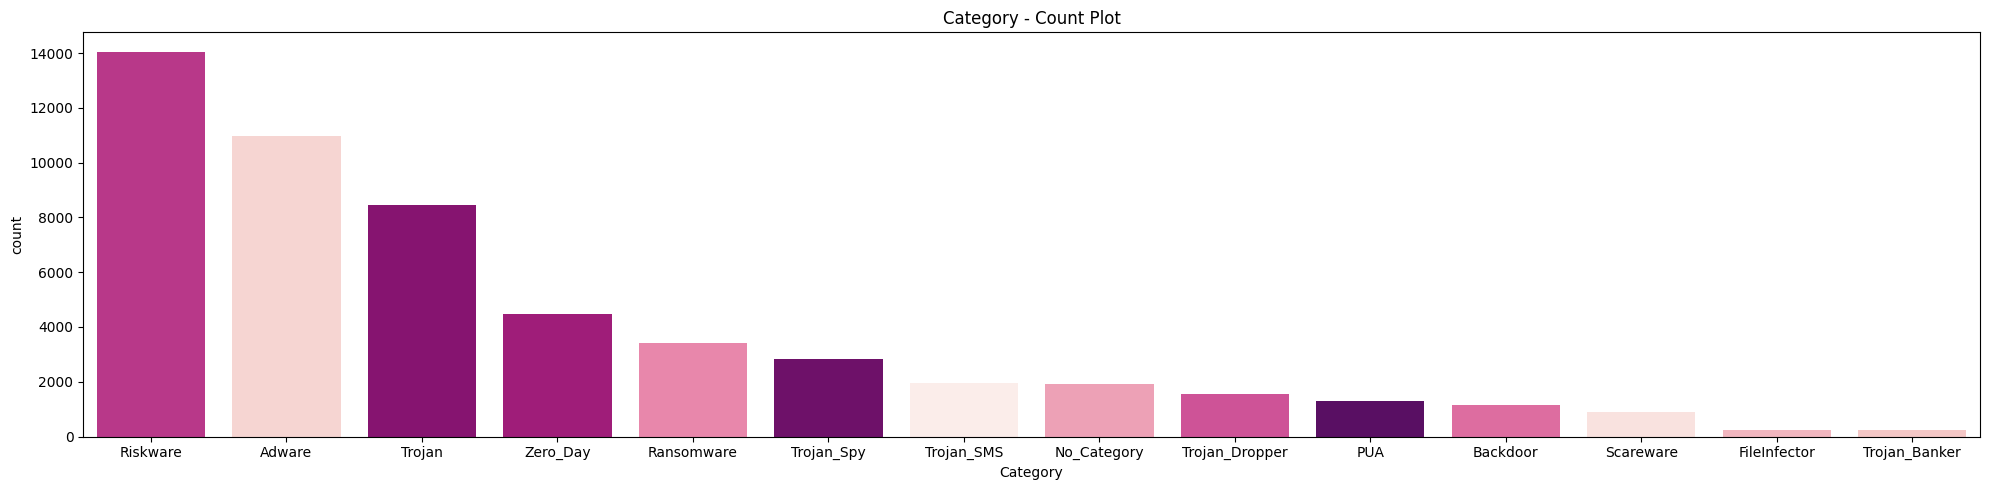

In [26]:
default_pipeline.EDA.plot_categorical_distributions(features=["Category"], n_cols=1, sorted = True)

## Data Type Distribution

In [27]:
# # Plotting the frequency of data types
# type_counts.plot(kind='bar', color='skyblue')

# # Add title and labels
# plt.title('Frequency of Data Types in DataFrame')
# plt.xlabel('Data Type')
# plt.ylabel('Frequency')

In [28]:
default_pipeline.dataset.df.dtypes.value_counts()

int64     141
object      2
Name: count, dtype: int64

We can see that most columns are numerical. Lets gets to see which are the variables that are of type object.

In [29]:
default_pipeline.dataset.df.select_dtypes(include=["object"]).columns

Index(['Category', 'Reboot'], dtype='object')

## Memory 

### PSS (Proportional Set Size)


PSS refers to the portion of memory that is proportionally assigned to a process, taking into acount shared memory.

Features:
- Memory_PssTotal
- Memory_PssClean
- Memory_SharedDirty
- Memory_PrivateDirty
- Memory_SharedClean
- Memory_PrivateClean
- Memory_SwapPssDirty

Clean vs Dirty:
- Clean: memory pages that hasnt been modified since it was mapped (Example: Libraries)
- Dirty: memory pages that have been modified.

Private vs Shared:
- Private: only available to a process
- Shared: mapped by multiple processes. The most important thing to take into account is that we divide the number of Kb by number of proccesses accessing to it.

Hypothesis:  
If malware is present on a system, it can load code or data into shared memory (e.g., a shared library), which reduces its individual memory footprint. Additionally, malware can inject code into other processes, keeping its own PSS relatively low. This is why PSS alone is likely insufficient for reliably detecting malicious applications.

In [30]:
memory_Pss_features = [
    "Memory_PssTotal", 
    "Memory_PssClean", 
    "Memory_SharedDirty", 
    "Memory_PrivateDirty", 
    "Memory_SharedClean", 
    "Memory_PrivateClean", 
    "Memory_SwapPssDirty"
]

#### Memory_PssTotal

This is the sum of Memory_PssClean, Memory_sharedDirty and Memory_PrivateDirty (Memory_PssDirty is not a feature). 

In [31]:
default_pipeline.dataset.df['Memory_PssTotal'].describe()

count     53439.000000
mean      70918.399034
std       36366.690217
min        4506.000000
25%       46165.000000
50%       61284.000000
75%       91740.000000
max      829169.000000
Name: Memory_PssTotal, dtype: float64

There is a really high standard deviation. The max value is extremely high. It's more than 10 times the mean. In general we can see a quite high memory usage.

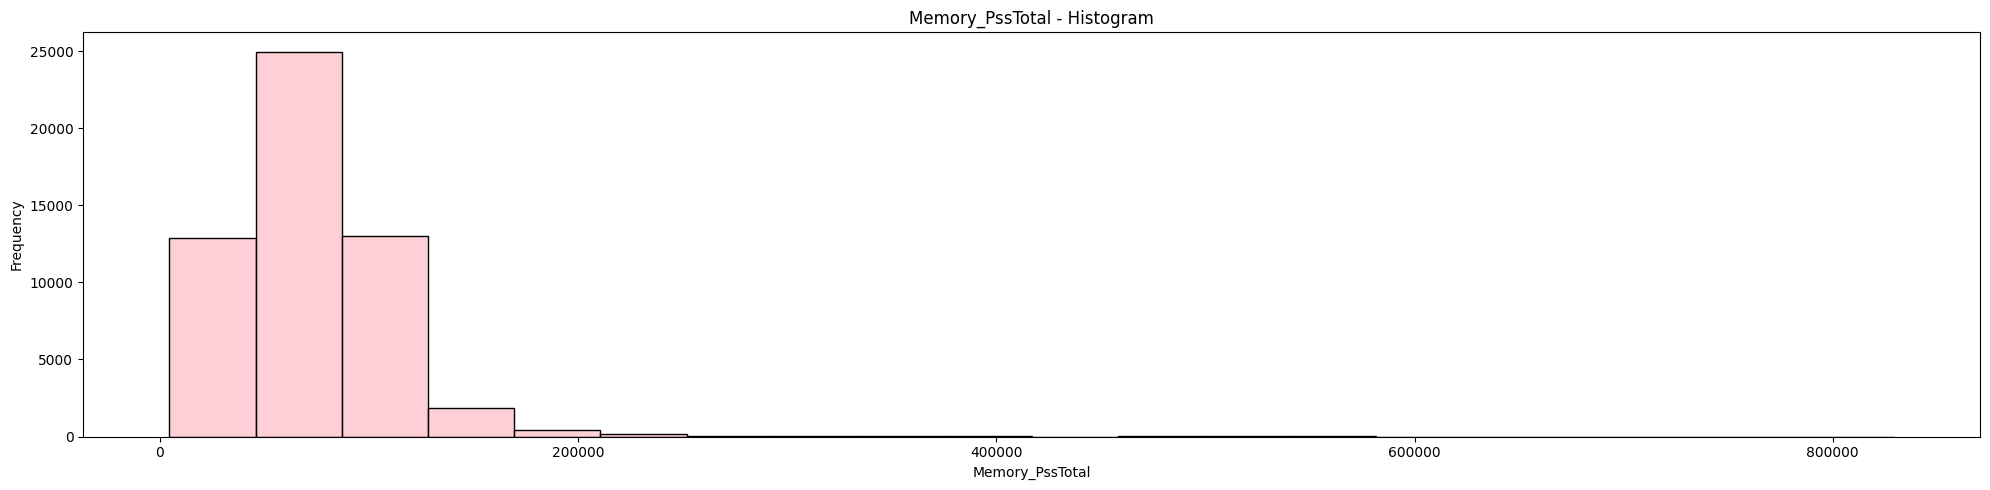

In [32]:
default_pipeline.EDA.plot_histograms(features=["Memory_PssTotal"], n_cols=1, bins=20)

In [33]:
default_pipeline.dataset.df['Memory_PssTotal'].max()

np.int64(829169)

In [34]:
default_pipeline.dataset.df.groupby('Category')['Memory_PssTotal'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,77691.313297,43186.372156,5514.0,47795.75,68345.5,100486.50,819456.0
Backdoor,1137.0,64872.519789,39258.133286,11073.0,43599.00,56469.0,71140.00,624063.0
FileInfector,248.0,74002.084677,32795.806609,23866.0,48291.75,52681.5,95831.75,178637.0
No_Category,1932.0,74386.863872,47941.296109,6028.0,44583.25,63812.5,94133.75,714868.0
PUA,1290.0,66573.948062,43089.788673,9255.0,32788.25,59511.5,81596.50,346117.0
Ransomware,3411.0,54950.799472,17360.548792,6340.0,45842.50,49349.0,58562.00,214365.0
Riskware,14053.0,67867.346261,32394.741622,4808.0,45893.00,60339.0,87167.00,829169.0
Scareware,886.0,88980.173815,26323.681386,13429.0,86004.75,93253.5,99570.75,279678.0
Trojan,8437.0,75164.102169,29651.677461,4506.0,52458.00,73496.0,91806.00,519285.0


It's interesting to note that both Scareware and Adware consume more memory, likely due to the UI activity. While Ransomware and Trojan_spy have relatively low memory consumption.

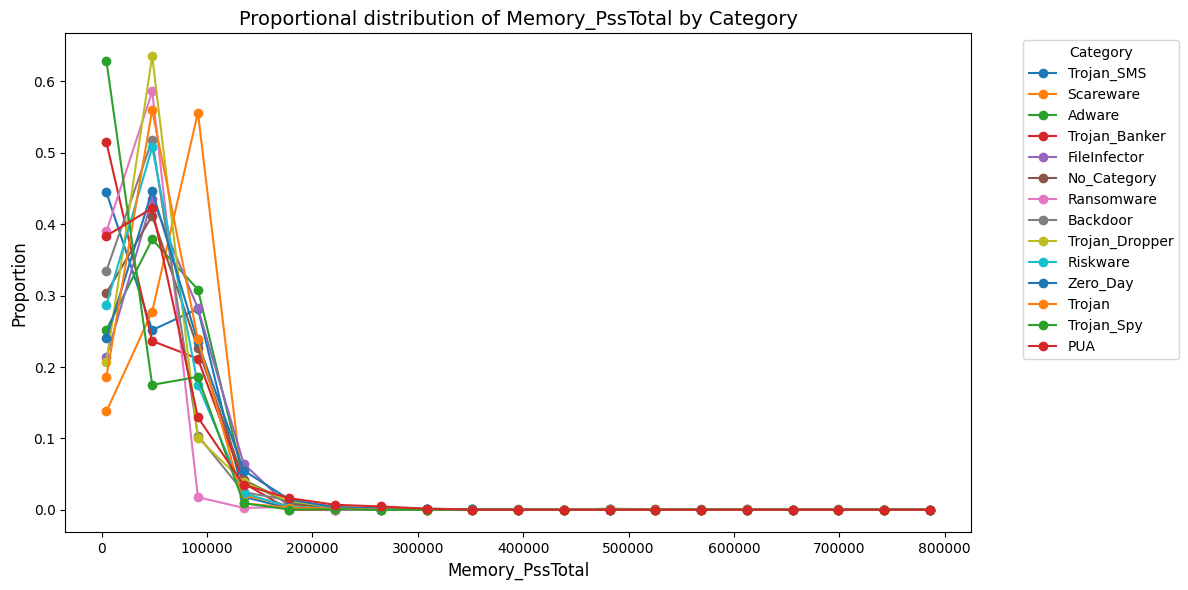

In [35]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Memory_PssTotal",
    category_column="Category"
)

Most malware types show a concentration of samples with lower memory usage, particularly below 100,000 KB. However, Adware and Trojan_Dropper show higher proportions in very low memory usage ranges, suggesting that many of these samples are designed to be lightweight, likely to remain unnoticed by the user or system. 

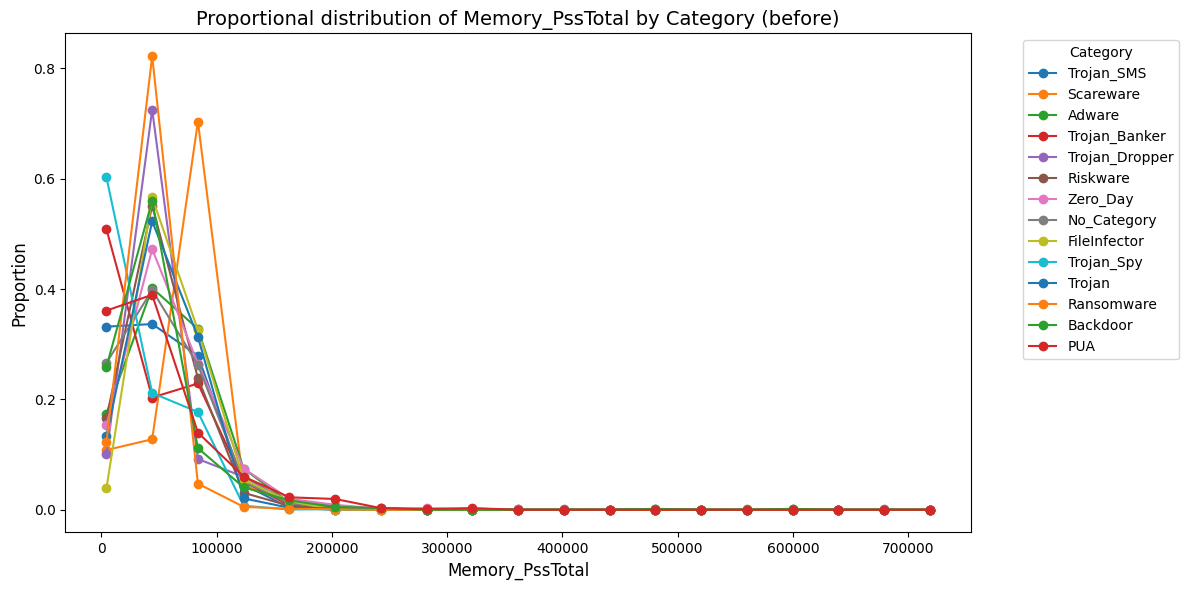

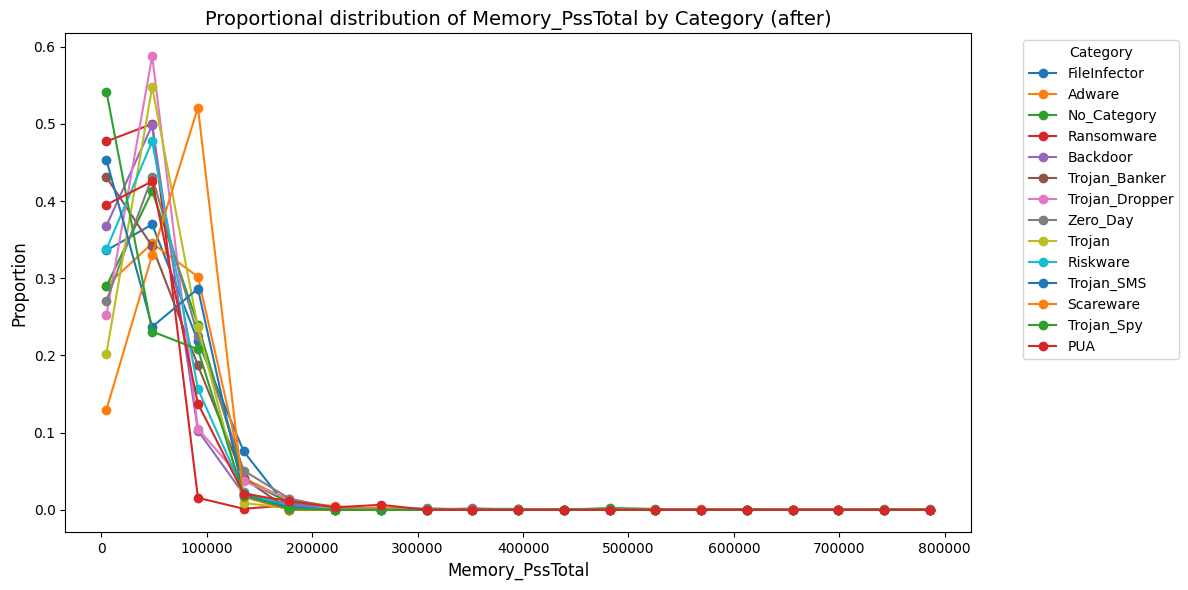

In [36]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Memory_PssTotal",
    category_column="Category",
    by_reboot = True
)

#### Memory_Pss_Clean: Shared and Private

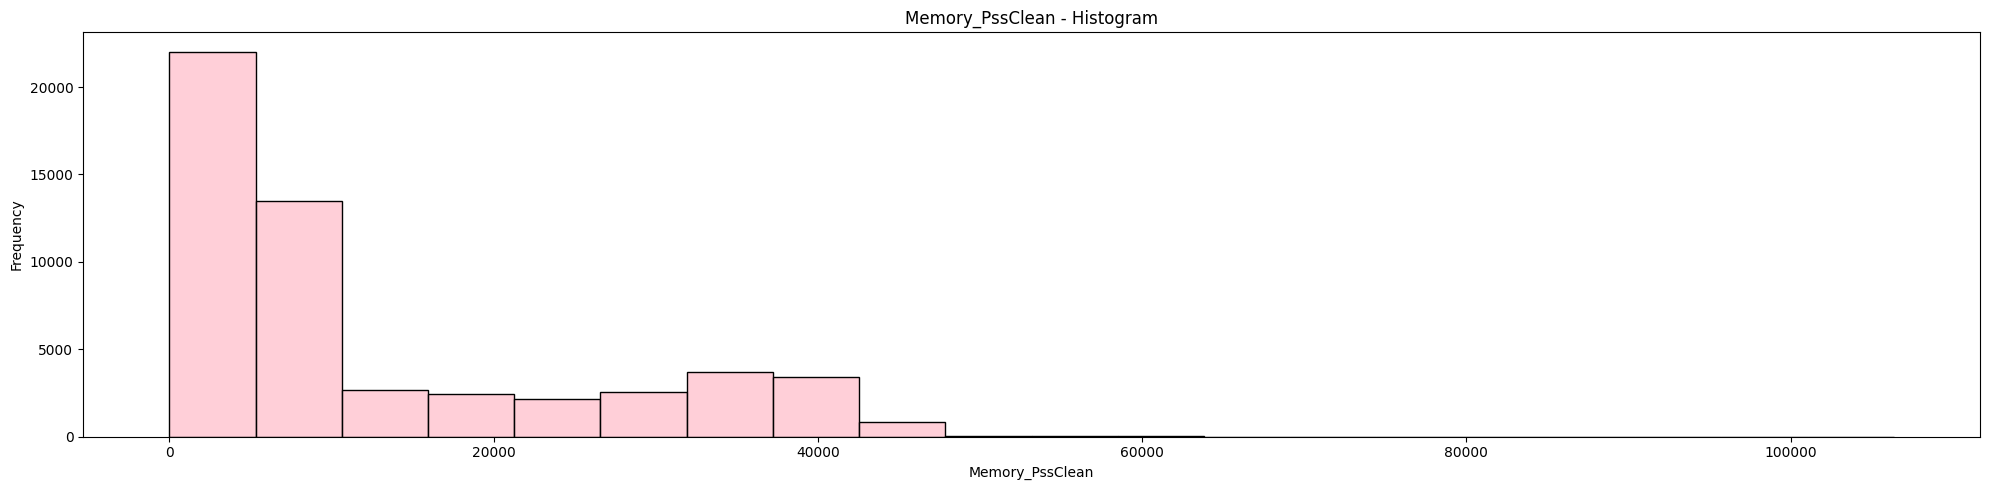

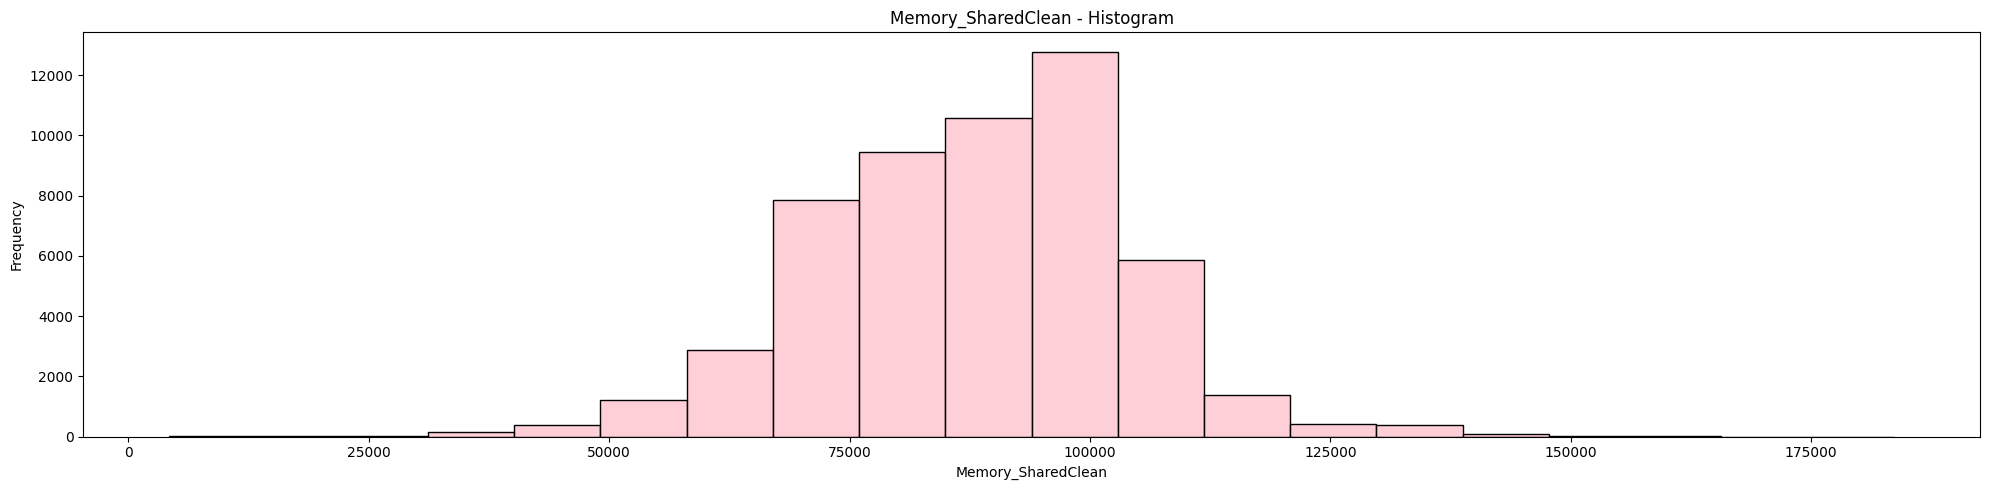

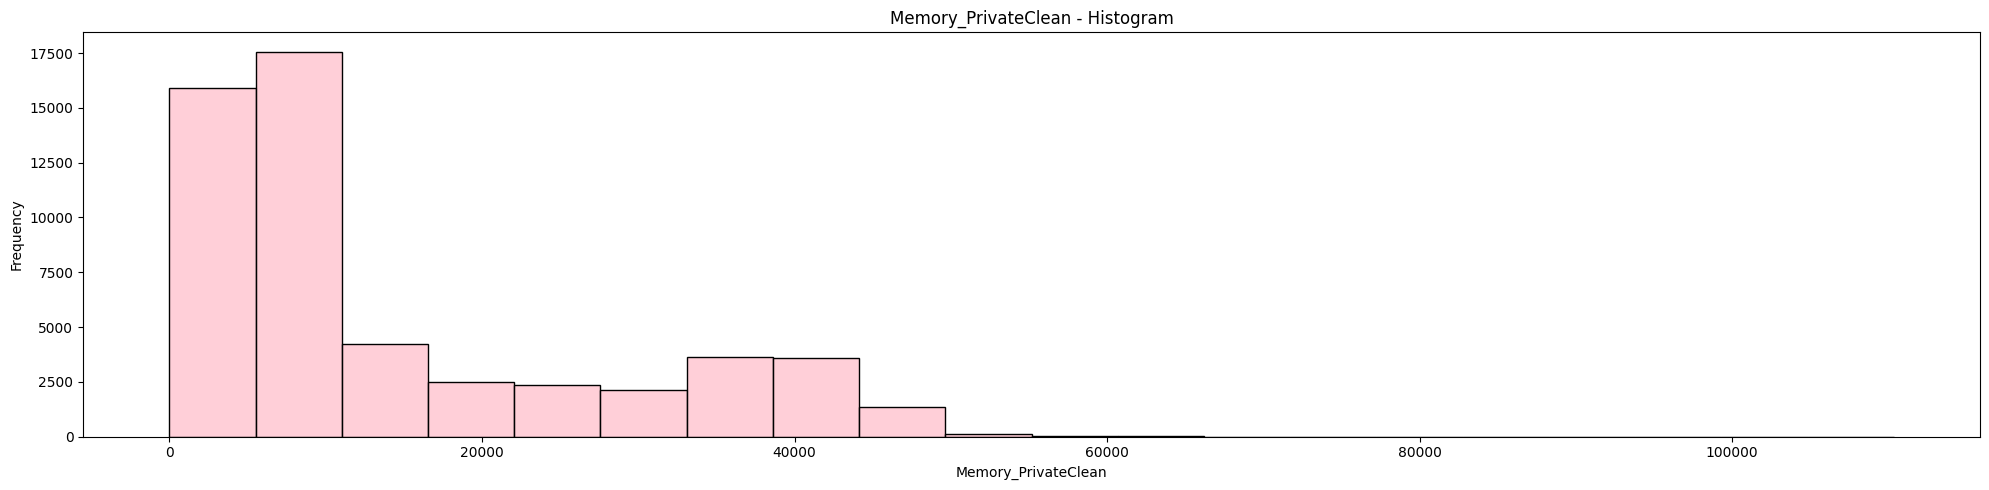

In [37]:
default_pipeline.EDA.plot_histograms(features=["Memory_PssClean"], n_cols=1, bins=20)
default_pipeline.EDA.plot_histograms(features=["Memory_SharedClean"], n_cols=1, bins=20)
default_pipeline.EDA.plot_histograms(features=["Memory_PrivateClean"], n_cols=1, bins=20)

In [38]:
default_pipeline.dataset.df.groupby('Category')['Memory_PssClean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,15741.613115,14063.508342,0.0,4436.0,8132.0,28520.0,56272.0
Backdoor,1137.0,8961.051891,10868.760200,68.0,3780.0,5060.0,7740.0,102320.0
FileInfector,248.0,16491.806452,15122.073528,0.0,4263.0,5834.0,31208.0,44780.0
No_Category,1932.0,13225.552795,13327.507898,0.0,3267.0,6536.0,22988.0,62708.0
PUA,1290.0,8119.677519,10475.622550,0.0,2265.0,3476.0,7863.0,105164.0
Ransomware,3411.0,5504.368220,5846.970870,0.0,2584.0,4844.0,6252.0,47020.0
Riskware,14053.0,14030.660215,12198.188924,0.0,4780.0,7636.0,24012.0,106360.0
Scareware,886.0,30622.988713,14283.361500,0.0,22470.0,38542.0,40859.0,48364.0
Trojan,8437.0,11913.528031,13163.803987,0.0,4128.0,5344.0,13972.0,78380.0


Scareware stands out with a high mean (30,622) and a tight upper quartile, indicating consistent use of clean memory, possibly due to persistent UI components. On the other hand, Ransomware and Trojan_Spy show much lower averages (5,500), implying less emphasis on maintaining clean memory, likely because they prioritize active memory usage.

In [39]:
pss_clean_features = ['Memory_SharedClean', 'Memory_PrivateClean', 'Memory_PssClean']

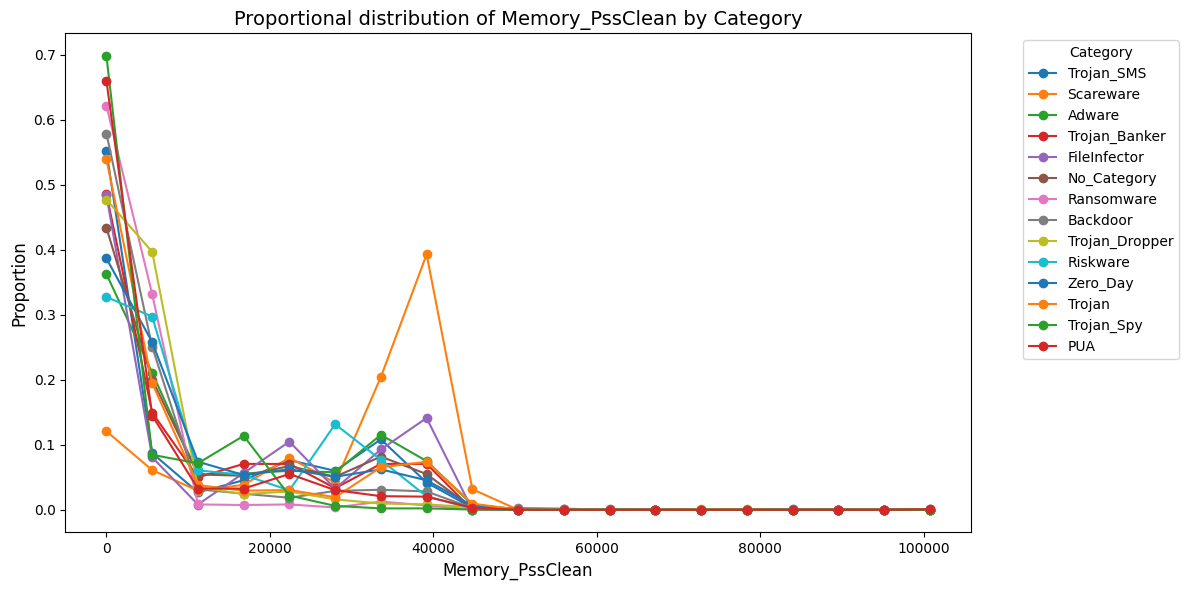

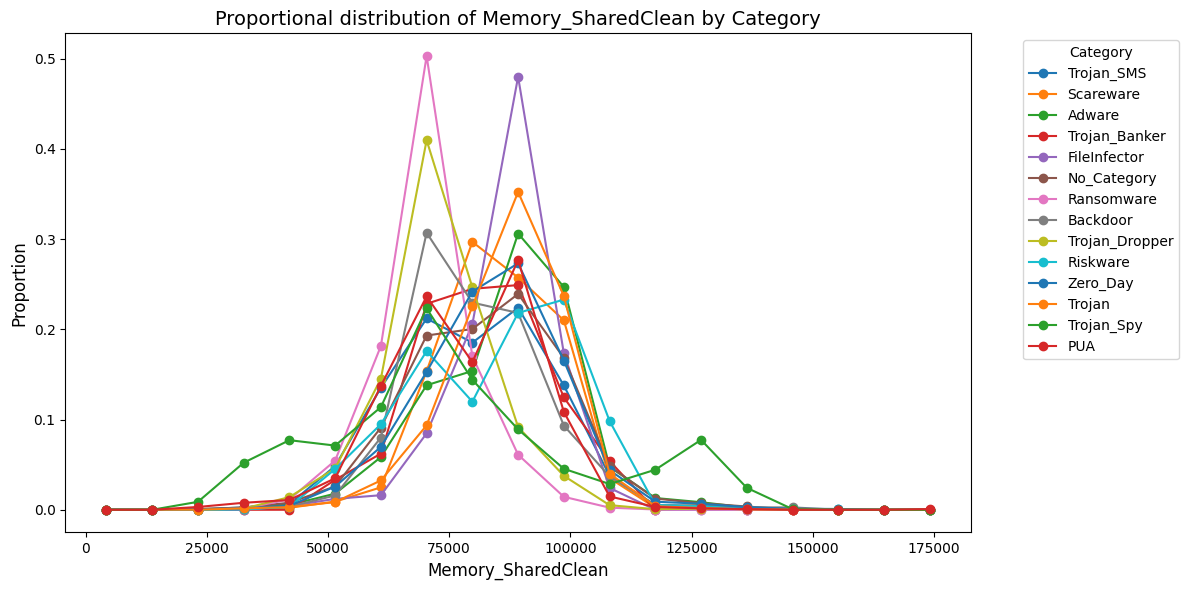

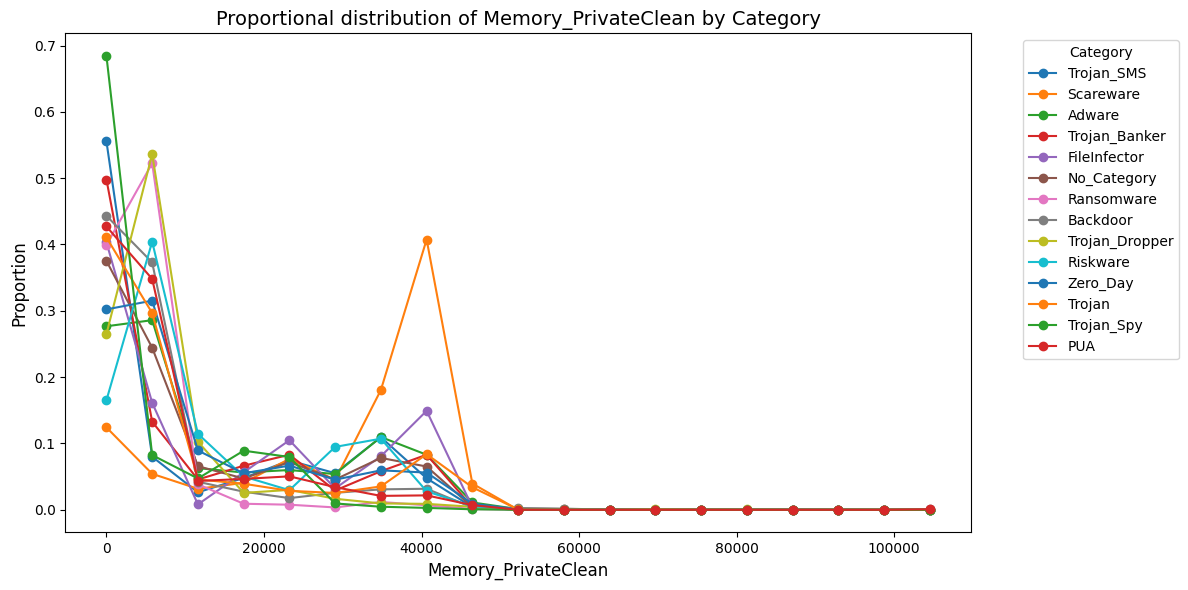

In [40]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Memory_PssClean",
    category_column="Category"
)

default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Memory_SharedClean",
    category_column="Category"
)

default_pipeline.EDA.plot_proportional_feature_frequency_by_category(
    feature="Memory_PrivateClean",
    category_column="Category"
)

In [41]:
default_pipeline.dataset.df[pss_clean_features].describe()

,Memory_SharedClean,Memory_PrivateClean,Memory_PssClean
count,53439.000000,53439.000000,53439.000000
mean,87981.107506,14316.579801,12742.597429
std,15859.495550,13463.546087,12894.559046
min,4268.000000,0.000000,0.000000
25%,76642.000000,4980.000000,3968.000000
50%,89536.000000,8176.000000,6340.000000
75%,99052.000000,21748.000000,20048.000000
max,183600.000000,110336.000000,106360.000000


The distribution of Memory_SharedClean appears significantly more normal compared to Memory_PrivateClean and Memory_PssClean, we can see this in it's lower standard deviation (15,859) and tighter interquartile range. This means that shared clean memory usage across samples is more consistent and less affected by extreme values. In contrast, PrivateClean and PssClean show higher variability and are more heavily right-skewed, with minimums at zero and max values reaching over 100,000 KB. This could be because shared clean memory often includes common libraries or system resources used uniformly across apps, while private memory is more directly tied to the app’s behavior, which varies greatly between malware families.

#### Memory_Pss_Dirty: Shared and Private

In [42]:
default_pipeline.dataset.df['Memory_PrivateDirty'].describe()

count     53439.000000
mean      47633.930650
std       29898.257374
min          12.000000
25%       31968.000000
50%       41432.000000
75%       55358.000000
max      826672.000000
Name: Memory_PrivateDirty, dtype: float64

In [43]:
default_pipeline.dataset.df['Memory_SharedDirty'].describe()

count     53439.000000
mean      10855.112259
std        2144.360998
min        7036.000000
25%       10540.000000
50%       10728.000000
75%       11144.000000
max      446548.000000
Name: Memory_SharedDirty, dtype: float64

Differences in Memory_PrivateDirty and Memory_SharedDirty (After - Before Reboot):
               Difference_PrivateDirty Difference_SharedDirty
Reboot                                                       
Category                                                     
Adware                      800.513859              27.253940
Backdoor                  -3437.897919              32.038192
FileInfector                416.442968             292.123249
No_Category                1385.732531              13.563746
PUA                       -4261.755814              42.163152
Ransomware                  806.281794             245.162158
Riskware                   -559.444420             -17.681246
Scareware                   199.377481              75.834068
Trojan                     -836.492002               3.460742
Trojan_Banker              5361.358137              13.877084
Trojan_Dropper             -675.875003              66.737491
Trojan_SMS                  646.115689           

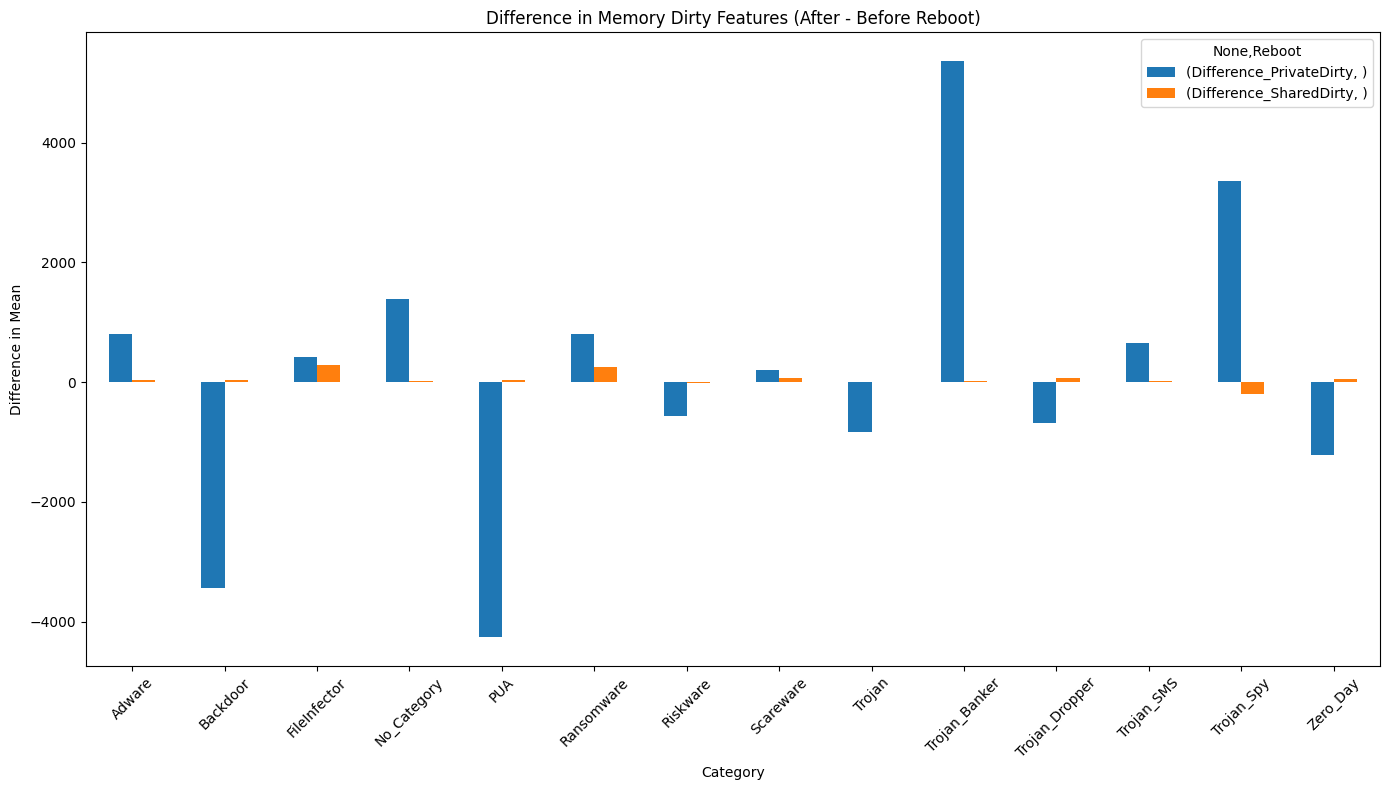

In [44]:
features_of_interest = ["Memory_PrivateDirty", "Memory_SharedDirty"]

category_means_filtered = (
    default_pipeline.dataset.df.groupby(['Category', 'Reboot'])[features_of_interest]
    .mean()
    .unstack()
)

category_means_filtered['Difference_PrivateDirty'] = (
    category_means_filtered[('Memory_PrivateDirty', 'after')] - 
    category_means_filtered[('Memory_PrivateDirty', 'before')]
)
category_means_filtered['Difference_SharedDirty'] = (
    category_means_filtered[('Memory_SharedDirty', 'after')] - 
    category_means_filtered[('Memory_SharedDirty', 'before')]
)

print("Differences in Memory_PrivateDirty and Memory_SharedDirty (After - Before Reboot):")
print(category_means_filtered[['Difference_PrivateDirty', 'Difference_SharedDirty']])

category_means_filtered[['Difference_PrivateDirty', 'Difference_SharedDirty']].plot(
    kind='bar', figsize=(14, 8), title='Difference in Memory Dirty Features (After - Before Reboot)'
)
plt.ylabel('Difference in Mean')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Adware, Ransomware and Trojan_Banker show significant increases in memory usage post-reboot, particularly in the Memory_PrivateDirty feature, which indicates that these types of malware may involve more intensive consumption or initialization processes after a reboot. On the other hand, categories such as Backdoor, PUA and Trojan_Dropper show decreases in memory usage in Memory_PrivateDirty, suggesting that these smaples may be designed to minimize resource usage after a reboot. Interestingly, some categories, like Trojan_Spy and Riskware, show decreases in shared memory but with increases in private dirty memory.

#### Memory_SwapPssDirty

This is the amount of memory that has been swapped out to the disk, this happens when the RAM is full, the OS decides to move less frequently used memory pages to a swap space. Memory_swapPssClean is not a feature.


In [45]:
default_pipeline.dataset.df['Memory_SwapPssDirty'].describe()

count    53439.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Memory_SwapPssDirty, dtype: float64

All values are 0. This means that malware samples aren't consuming enough resources to trigger memory swapping, or they are designed to run efficiently within the available RAM, avoiding the need for swap usage.

### Heap

- Memory_HeapSize
- Memory_HeapAlloc
- Memory_HeapFree

Memory_HeapSize = Memory_HeapAlloc + Memory_HeapFree + 1. The plus 1 is memory that is not used, but it looks like it is not directly used by the program meaning that could be metadata. Becouse of this, we expect HeapAlloc and HeapFree to be really correlated with Heap Size.


In [46]:
heap_features = ['Memory_HeapSize', 'Memory_HeapAlloc', 'Memory_HeapFree']


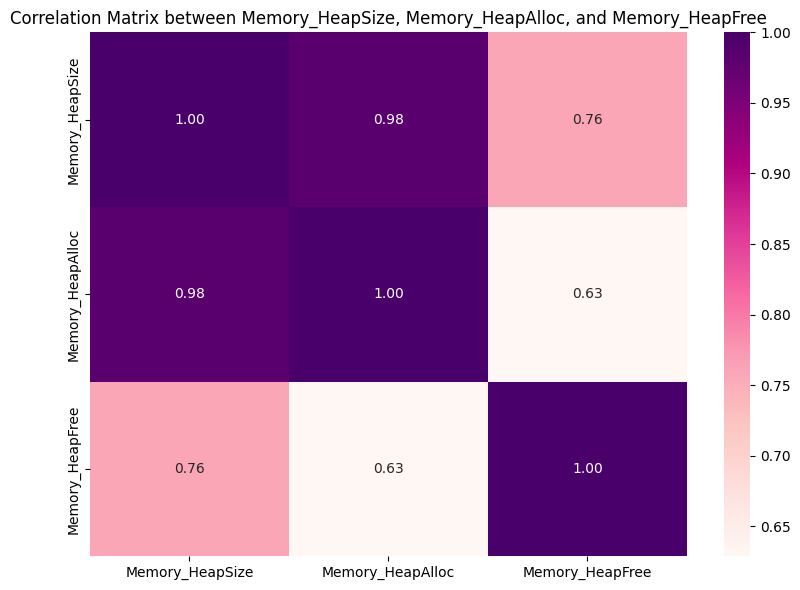

In [47]:
correlation_matrix = default_pipeline.dataset.df[heap_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdPu', fmt='.2f', cbar=True)
plt.title('Correlation Matrix between Memory_HeapSize, Memory_HeapAlloc, and Memory_HeapFree')
plt.tight_layout()
plt.show()



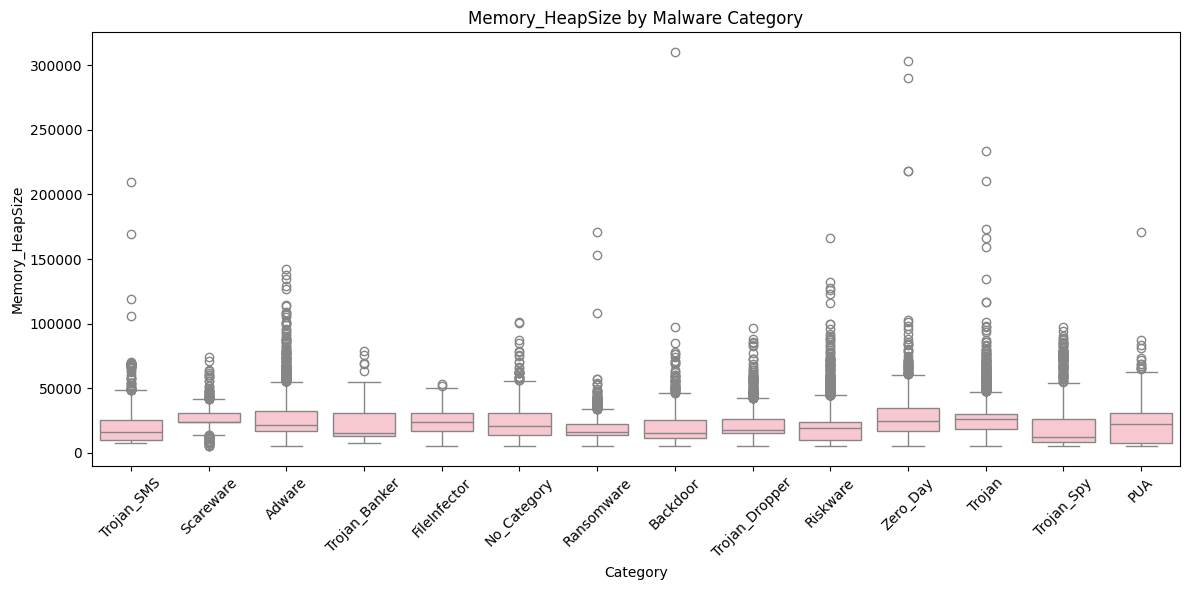

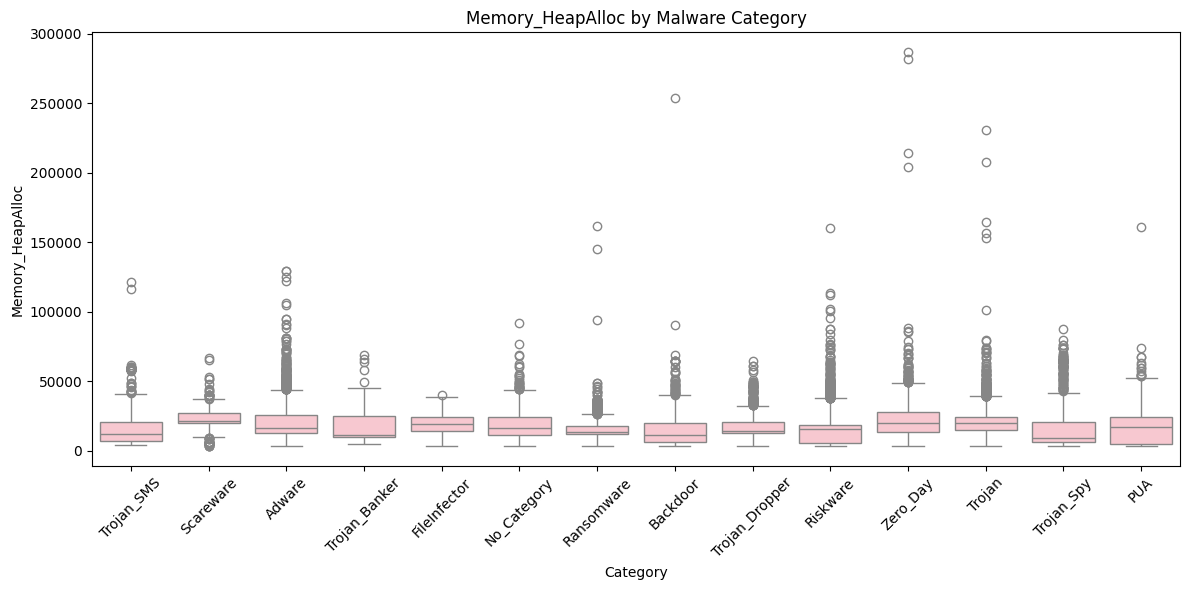

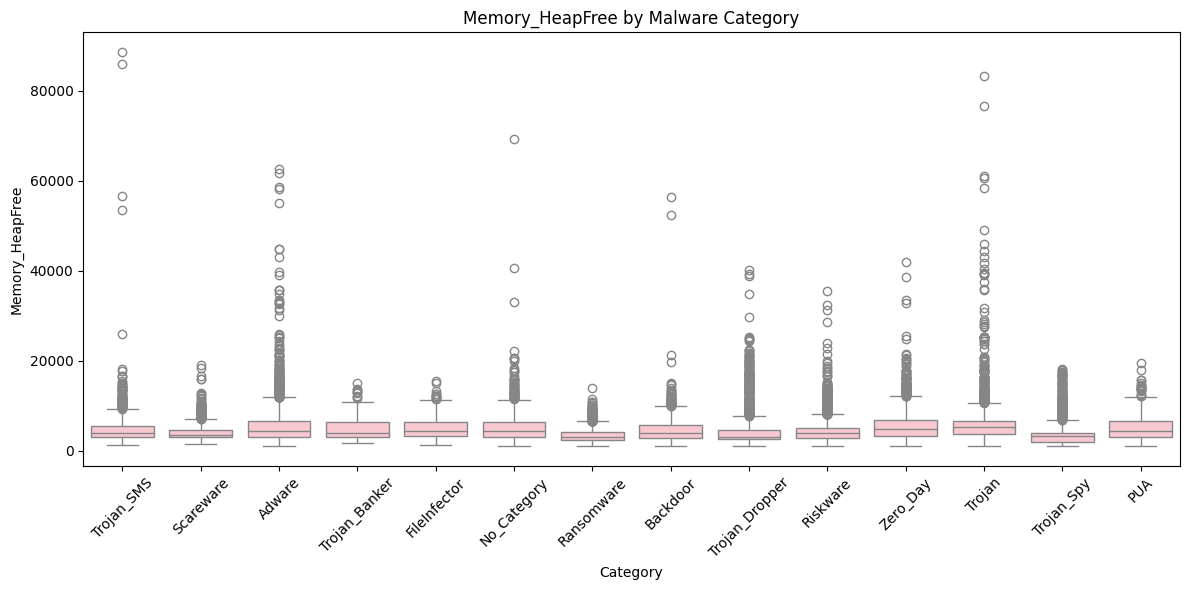

In [48]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_HeapSize', color='pink')
plt.title('Memory_HeapSize by Malware Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_HeapAlloc', color='pink')
plt.title('Memory_HeapAlloc by Malware Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_HeapFree', color='pink')
plt.title('Memory_HeapFree by Malware Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This is one of the few features where we can clearly visualize differences between malware categories, likely due to a wider IQR, fewer extreme outliers, and more consistent behavior within each category. However, the data still shows a general right-skewed distribution across all categories. Trojan is the category with the most consistently high outliers. This could be due to Trojan samples often maintaining in-memory operations or interacting dynamically with the system

In [49]:
heap_features = ['Memory_HeapAlloc', 'Memory_HeapFree']
heap_stats = default_pipeline.dataset.df.groupby('Reboot')[heap_features].describe()
print(heap_stats)

       Memory_HeapAlloc                                                \
                  count          mean           std     min       25%   
Reboot                                                                  
after           25059.0  17696.058143  10434.377887  3249.0  10980.50   
before          28380.0  17405.529281  10477.694412  3435.0  10428.25   

                                   Memory_HeapFree                            \
            50%      75%       max           count         mean          std   
Reboot                                                                         
after   16742.0  22887.0  282065.0         25059.0  4765.345225  2907.394355   
before  16386.0  22808.5  286959.0         28380.0  4710.971388  2930.914917   

                                                  
           min     25%     50%      75%      max  
Reboot                                            
after    983.0  3003.5  4125.0  5875.00  83200.0  
before  1012.0  2985.0  4013.

The overall memory behavior remains relatively stable across reboots, the slight increase in mean heap allocation and free values post-reboot  hints that certain malware types might activate or expand memory-intensive behaviors only after the system has been restarted.

### Memory Views

- Memory_Views: Number of view objects in the process that have been created in the application memory, thai includes all UI elements such as: buttons, textviews, imageviews, layouts
- Memory_ViewRootImpl: The ViewRootImpl is the top of the view hierarchy in android, it doesn't render anything, it is just responsible for the interaction between WIndow and view. This variable shows the number of ViewRootImpl instances that exist in the app. In simpler terms, this shows the number of windows (or active hierarchies) that exist in an app process.

In [50]:
memory_views_features = ['Memory_Views', 'Memory_ViewRootImpl']

In [51]:
default_pipeline.dataset.df[memory_views_features].describe()

,Memory_Views,Memory_ViewRootImpl
count,53439.000000,53439.000000
mean,89.038418,2.917644
std,247.553043,5.648569
min,0.000000,0.000000
25%,9.000000,1.000000
50%,35.000000,2.000000
75%,116.000000,4.000000
max,29850.000000,504.000000


The Memory_Views variable, has a very wide distribution, with an extreme maximum of 29,850. The standard deviation is very high (247.5), indicating significant variability in how different malware families utilize/abuse UI-related resources. For example, adware or scareware might generate a large number of views to flood the user interface with popups, overlays, or fake system alerts. So we expect these 2 categories to peak in these feature.

The Memory_ViewRootImpl feature, shows a lower mean (2.91) but also a surprisingly high maximum of 504. This suggests that while most malicious apps create only one or a few root UI elements, some outliers massively abuse the view hierarchy.

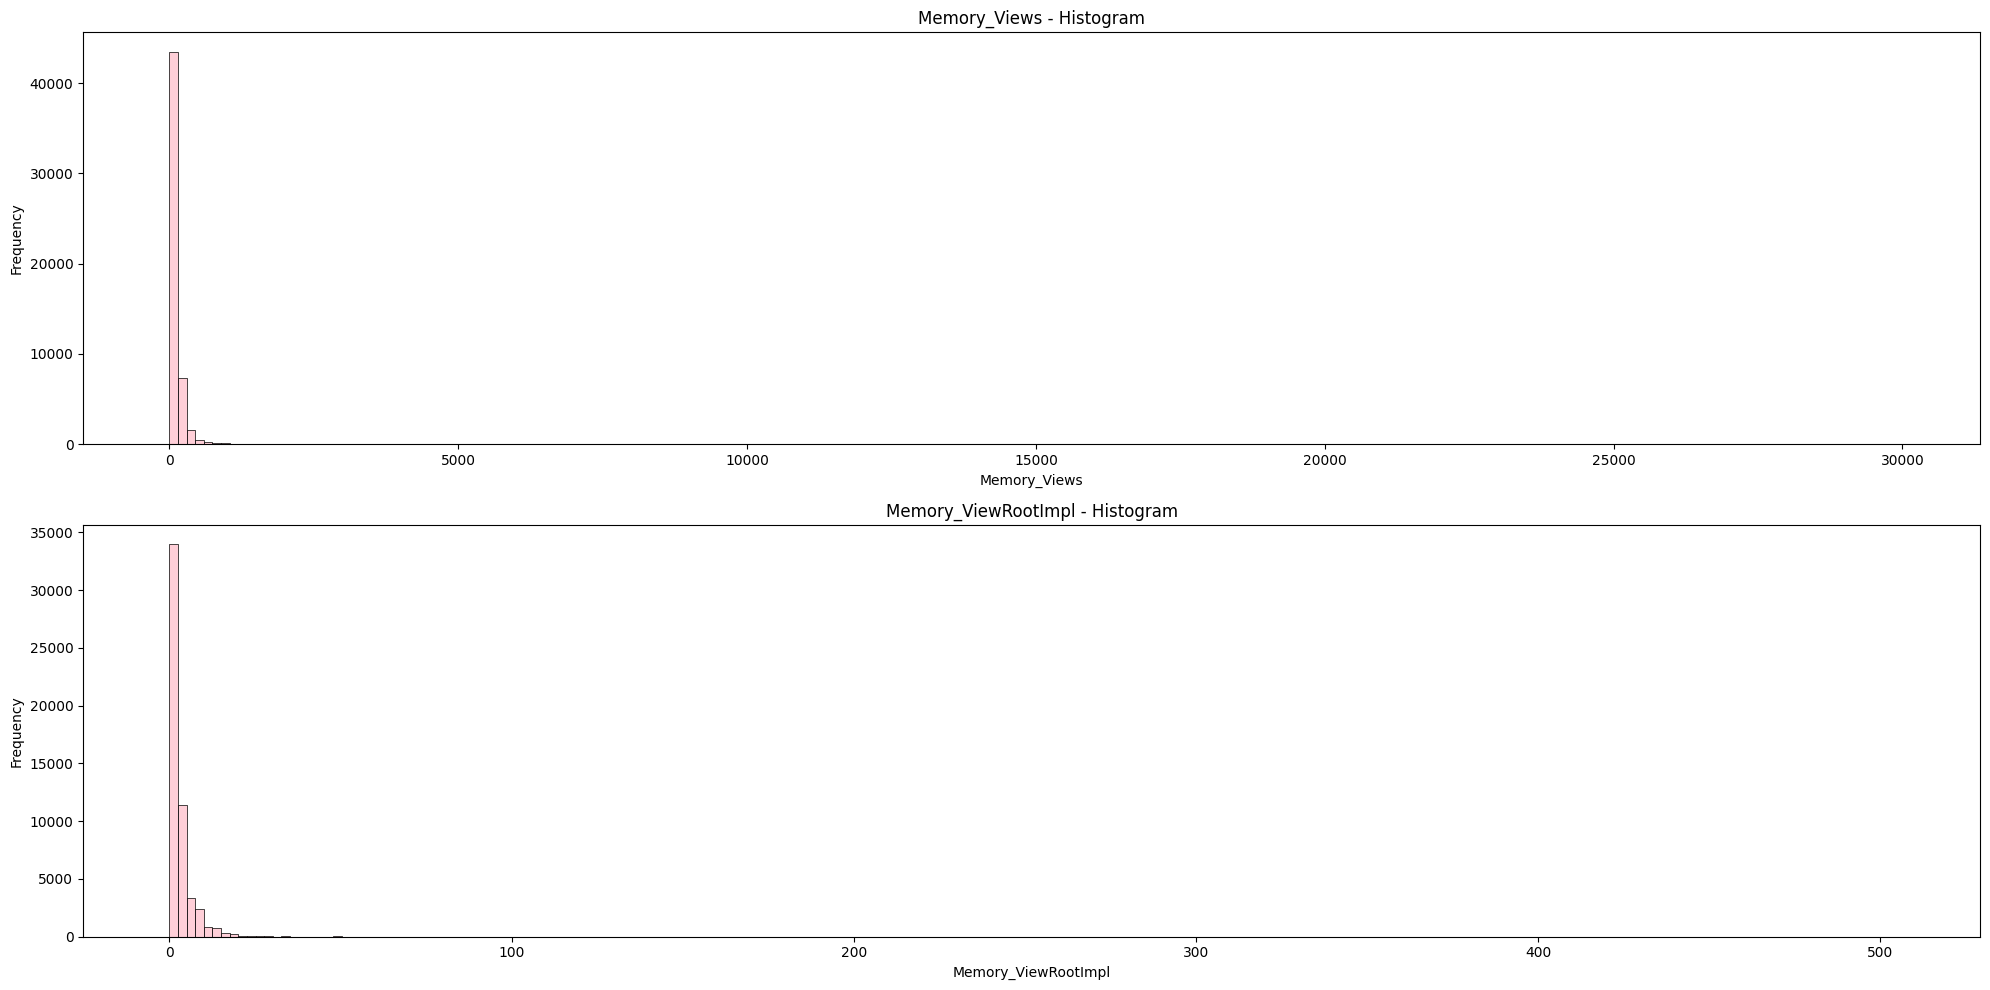

In [52]:
default_pipeline.EDA.plot_histograms(memory_views_features, n_cols=1, bins=200)

Based on the plots, we observe that most values are concentrated on the lower end of the scale. To gain more insights, I prefer focusing the analysis on the outliers

In [53]:
q1 = default_pipeline.dataset.df['Memory_Views'].quantile(0.25)
q3 = default_pipeline.dataset.df['Memory_Views'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = default_pipeline.dataset.df[
    (default_pipeline.dataset.df['Memory_Views'] < lower_bound) | 
    (default_pipeline.dataset.df['Memory_Views'] > upper_bound)
]

outlier_counts = outliers['Category'].value_counts()

print("1.5 * IQR range limits:")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print("\nCategory count for values outside the range:")
print(outlier_counts)


1.5 * IQR range limits:
Lower bound: -151.5
Upper bound: 276.5

Category count for values outside the range:
Category
Riskware          673
Adware            658
Zero_Day          584
Trojan            323
Ransomware        189
PUA               189
No_Category       178
Trojan_SMS        164
Trojan_Dropper     82
Backdoor           57
Trojan_Banker      37
FileInfector       17
Scareware           7
Trojan_Spy          5
Name: count, dtype: int64


The results show that Riskware and Adware samples are the most frequent outliers, with Riskware leading at 673 instances. This suggests that these types of malware tend to generate an unusually high number of memory views compared to the rest of the dataset, possibly due to their nature of interacting broadly with system processes, services, or user interfaces. Riskware and Adware, in particular, often include components that monitor system activity or display persistent advertising.

In [54]:
q1 = default_pipeline.dataset.df['Memory_ViewRootImpl'].quantile(0.25)
q3 = default_pipeline.dataset.df['Memory_ViewRootImpl'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = default_pipeline.dataset.df[
    (default_pipeline.dataset.df['Memory_ViewRootImpl'] < lower_bound) | 
    (default_pipeline.dataset.df['Memory_ViewRootImpl'] > upper_bound)
]

outlier_counts = outliers['Category'].value_counts()

print("1.5 * IQR range limits:")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")
print("\nCategory count for values outside the range:")
print(outlier_counts)



1.5 * IQR range limits:
Lower bound: -3.5
Upper bound: 8.5

Category count for values outside the range:
Category
Riskware          908
Trojan            874
Adware            535
Zero_Day          429
Ransomware        187
No_Category       151
Backdoor          147
Trojan_SMS        137
Trojan_Dropper    117
PUA               112
Trojan_Spy         43
Trojan_Banker      17
Scareware          12
FileInfector       11
Name: count, dtype: int64


From the IQR analysis, we observe that categories like Riskware, Trojan, and Adware have the highest counts of outliers. This suggests that these types of malware often involve more complex or persistent operations, which could involve manipulating multiple windows or processes. Riskware (908 outliers), which includes potentially unwanted software, may create multiple windows to mislead users or carry out intrusive behavior. Similarly, Trojans (874 outliers) tend to hide their malicious activities and may spawn multiple hierarchies as they attempt to evade detection, while Adware (535 outliers) could be responsible for generating excessive pop-ups or ads that require additional view hierarchies. 

### Android Activity and Application

- Memory_AppContexts: this feature tells us how many application context instances exist in the app’s memory. Normally there should be only 1 instance.
- Memory_Activities: how many activity instances are currently alive in the app’s process

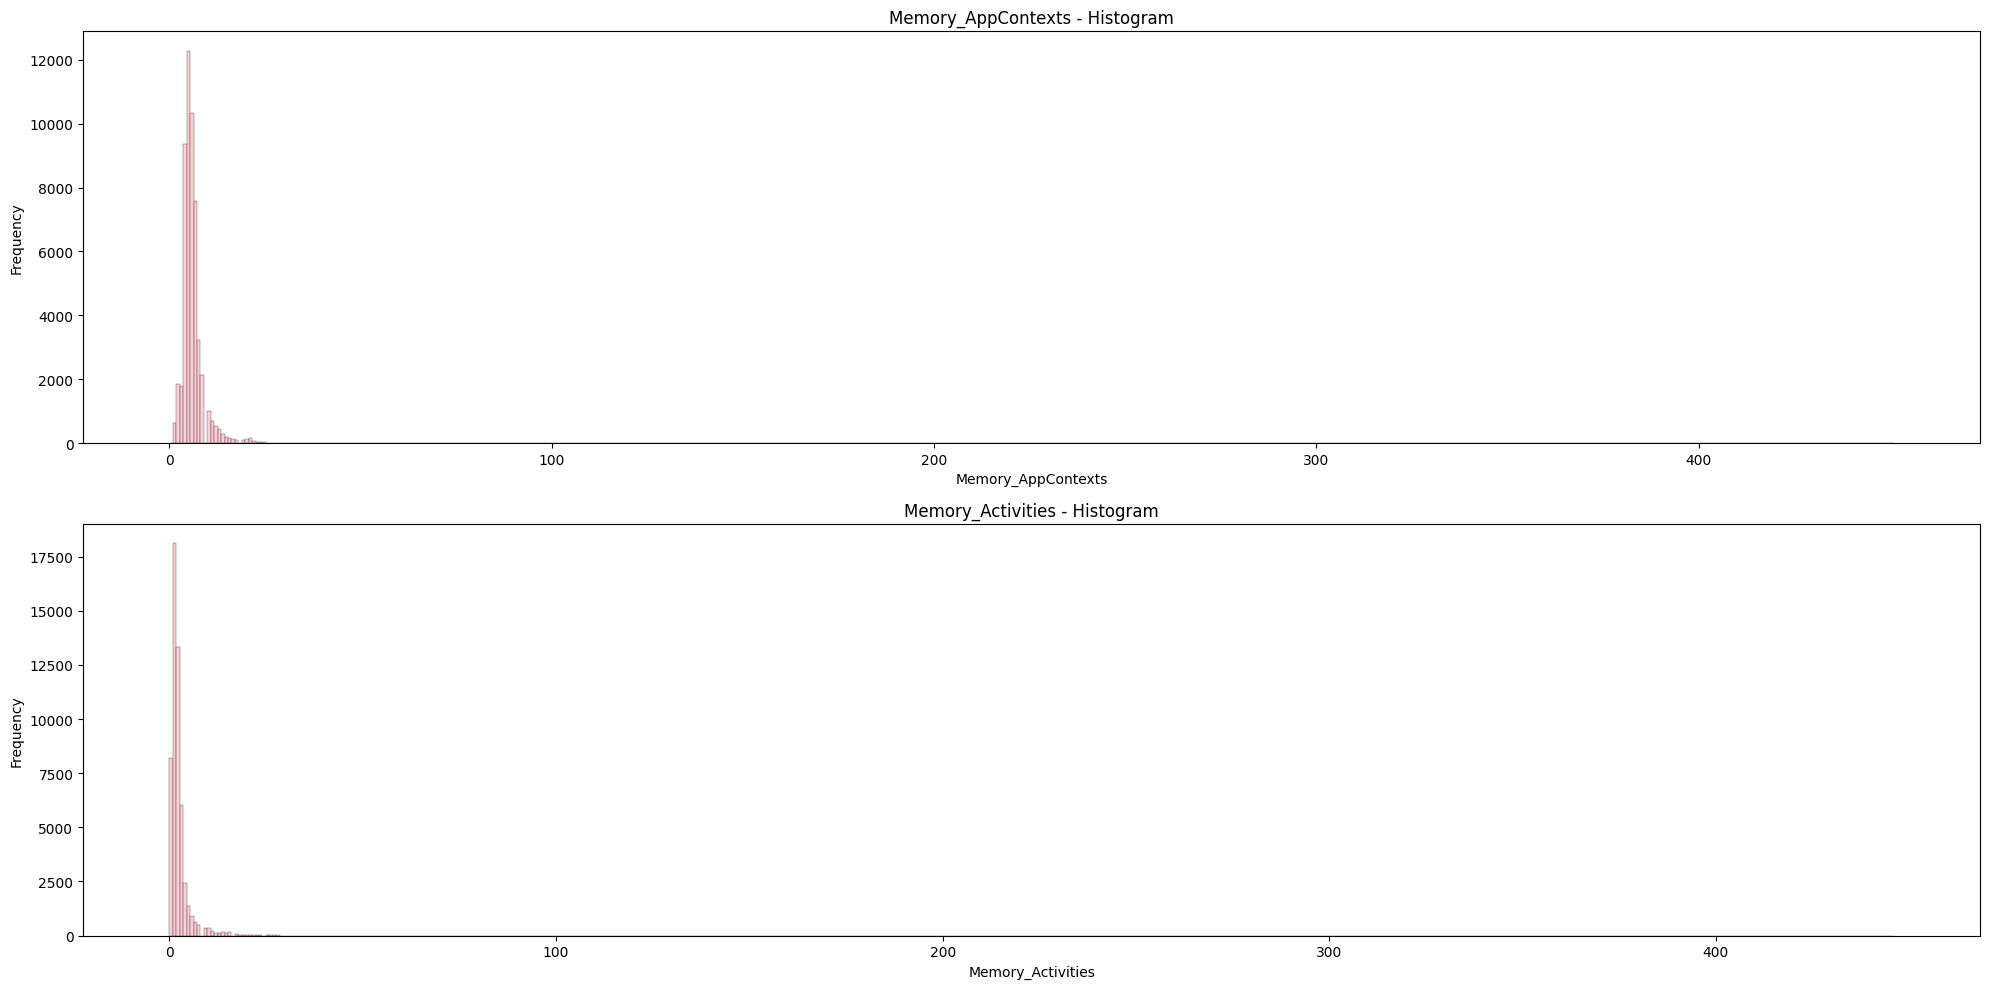

In [55]:
default_pipeline.EDA.plot_histograms(features=["Memory_AppContexts", "Memory_Activities"], n_cols=1, bins=500)

In [56]:
default_pipeline.dataset.df.groupby('Category')['Memory_AppContexts'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,6.227596,3.015372,0.0,4.0,6.0,7.0,62.0
Backdoor,1137.0,5.807388,2.869340,1.0,5.0,6.0,6.0,29.0
FileInfector,248.0,5.508065,2.180131,2.0,5.0,5.0,5.0,18.0
No_Category,1932.0,6.652692,3.942752,1.0,5.0,6.0,7.0,42.0
PUA,1290.0,5.112403,4.066047,1.0,2.0,5.0,6.0,37.0
Ransomware,3411.0,7.540311,9.554708,1.0,5.0,6.0,7.0,248.0
Riskware,14053.0,5.410588,2.616771,0.0,4.0,5.0,6.0,45.0
Scareware,886.0,5.442438,1.718811,1.0,5.0,5.0,5.0,30.0
Trojan,8437.0,6.886927,5.738928,0.0,5.0,7.0,8.0,451.0


Ransomware shows the highest mean memory usage (7.54), which is consistent with expectations. Trojans, particularly Trojan SMS and Trojan Dropper, also show high memory usage, with means of 6.89 and 6.88, respectively, and relatively high maximum values of 432 and 208. Trojan Banker, despite being a type of Trojan, shows a lower mean of 5.95, which suggests less intensive memory usage compared to other Trojans, likely because it focuses specifically on banking transactions and monitoring. 

In [57]:
default_pipeline.dataset.df.groupby('Category')['Memory_Activities'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,2.302004,2.761698,0.0,1.0,1.0,3.0,59.0
Backdoor,1137.0,1.796834,2.314618,0.0,1.0,1.0,2.0,25.0
FileInfector,248.0,1.709677,2.049091,0.0,1.0,1.0,1.0,14.0
No_Category,1932.0,2.692029,3.703383,0.0,1.0,2.0,3.0,39.0
PUA,1290.0,2.155814,3.593987,0.0,0.0,1.0,2.0,34.0
Ransomware,3411.0,2.739666,4.198967,0.0,1.0,1.0,2.0,25.0
Riskware,14053.0,1.936739,2.357749,0.0,1.0,1.0,2.0,42.0
Scareware,886.0,1.668172,1.741628,0.0,1.0,1.0,2.0,27.0
Trojan,8437.0,2.482992,5.585713,0.0,1.0,2.0,3.0,446.0


Trojan Dropper and Trojan SMS show high variability and potential for memory spikes, with very high maximum memory values (203.0 and 427.0 respectively) and large standard deviations (9.04 and 11.10), supporting the idea that they engage in heavy operations. Ransomware, which was also expected to show significant memory use, does indeed have a high mean (2.74) and one of the higher standard deviations (4.20), though its maximum (25.0) is somewhat smaller than expected. 

FileInfector, surprisingly, does not show particularly high memory usage, its mean is low (1.71) and the maximum is only 14. This suggests that either these infections are lightweight or their most resource-intensive operations occur outside of memory tracking windows. Adware and PUA, which were expected to have low memory use, align well with the hypothesis in terms of their low means (2.30 and 2.16 respectively), though Adware does show a relatively high max of 59, possibly due to ad loading spikes.

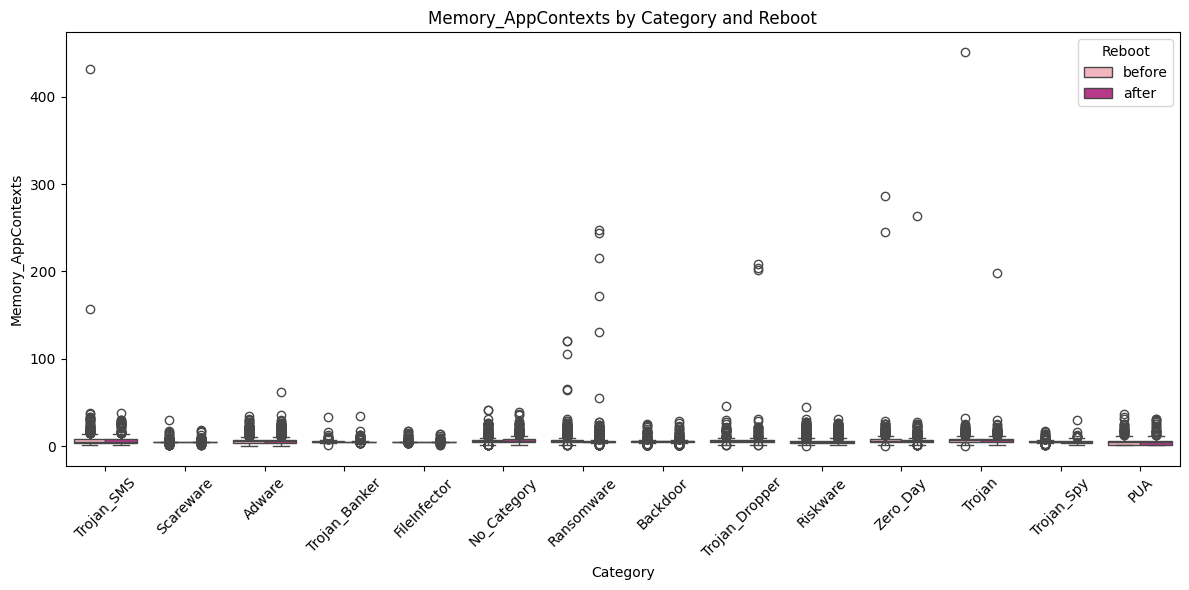

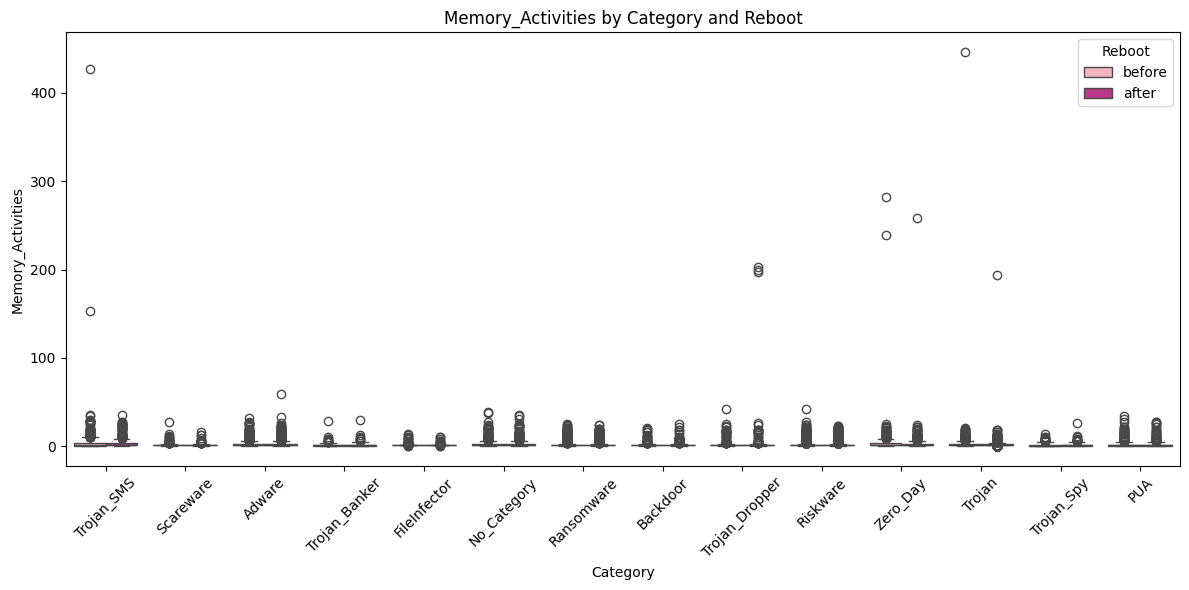

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_AppContexts', hue='Reboot', palette='RdPu')
plt.title('Memory_AppContexts by Category and Reboot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_Activities', hue='Reboot', palette='RdPu')
plt.title('Memory_Activities by Category and Reboot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


As we can see for most categories, the distributions remain similar before and after the reboot, suggesting that the reboot does not drastically alter their memory usage patterns. However, some categories, such as Ransomware, show slight increases in variability after the reboot.

### Assets


- Memory_Assets: stores numbers of asset allocations currently loaded into memory
- Memory_AssetManagers: counts the number of AssetManager instances currently active in memory

In [59]:
assets_features = ['Memory_Assets', 'Memory_AssetManagers']

In [60]:
default_pipeline.dataset.df[assets_features].describe()

,Memory_Assets,Memory_AssetManagers
count,53439.000000,53439.0
mean,2.926664,0.0
std,1.857883,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,2.000000,0.0
75%,4.000000,0.0
max,122.000000,0.0


To access memory assets its not neccesary to use an asset manager to access and manage them. 

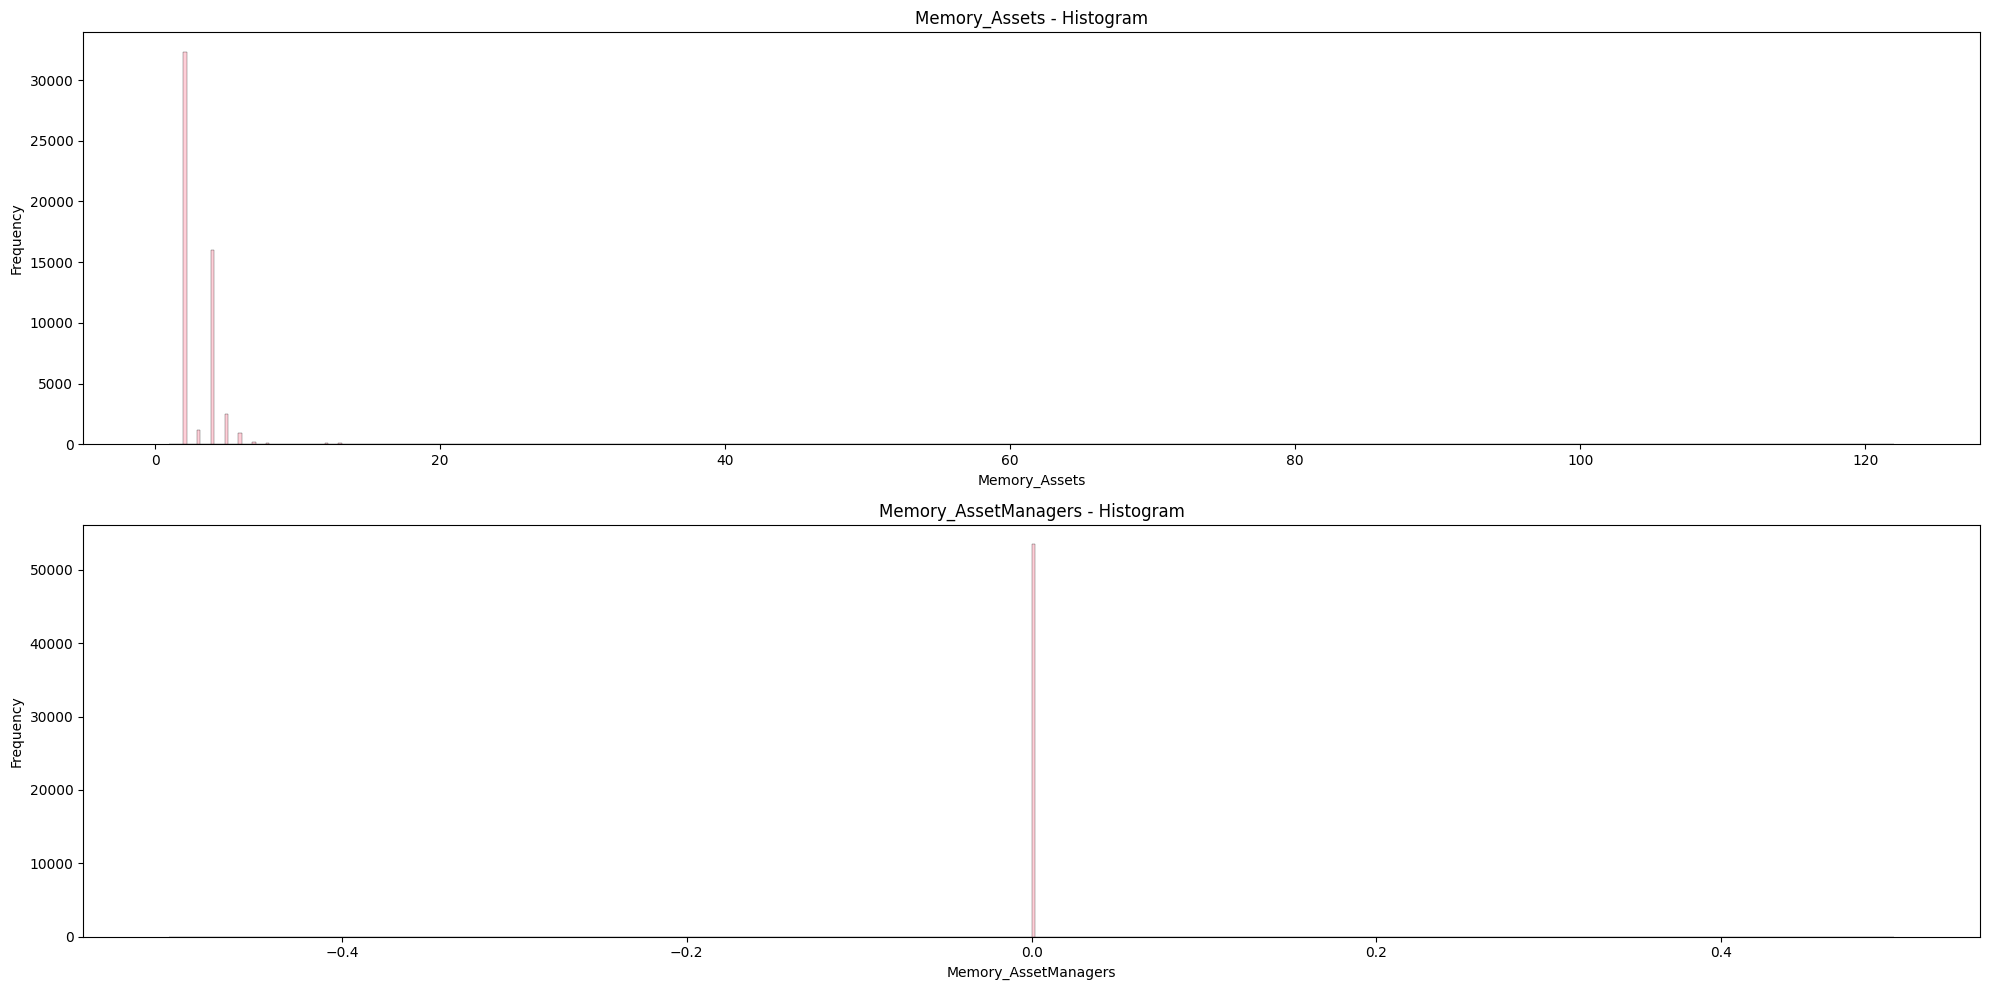

In [61]:
default_pipeline.EDA.plot_histograms(assets_features, n_cols=1, bins=500)

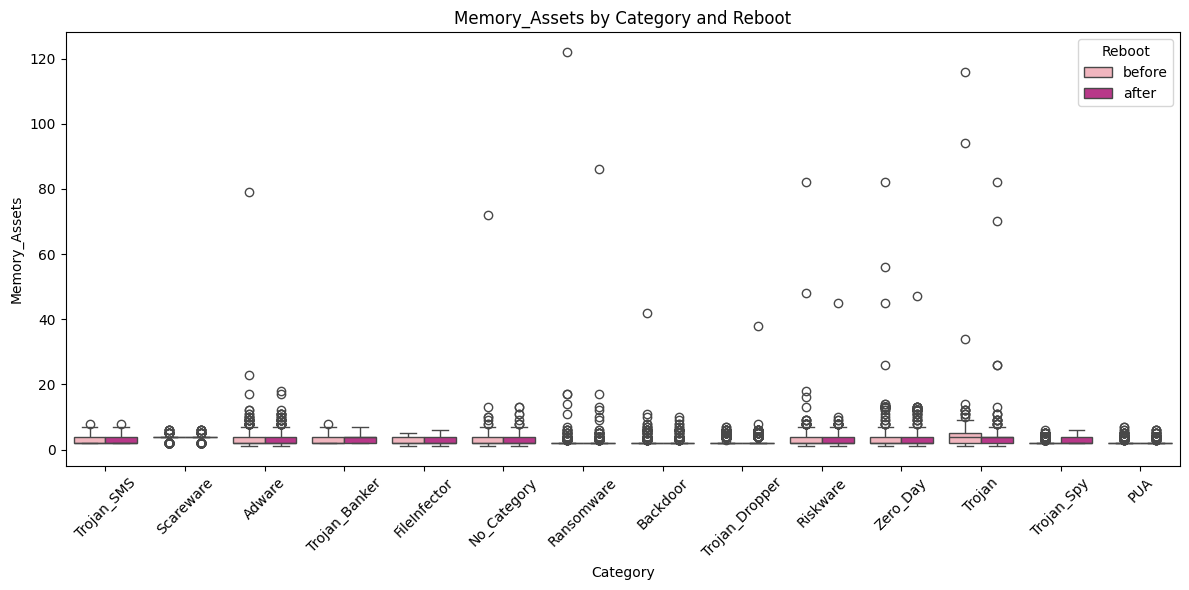

In [62]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_Assets', hue='Reboot', palette='RdPu')
plt.title('Memory_Assets by Category and Reboot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The features that change the most before and after the reboot are Trojan and Trojan_Spy. Let's analyze them further:

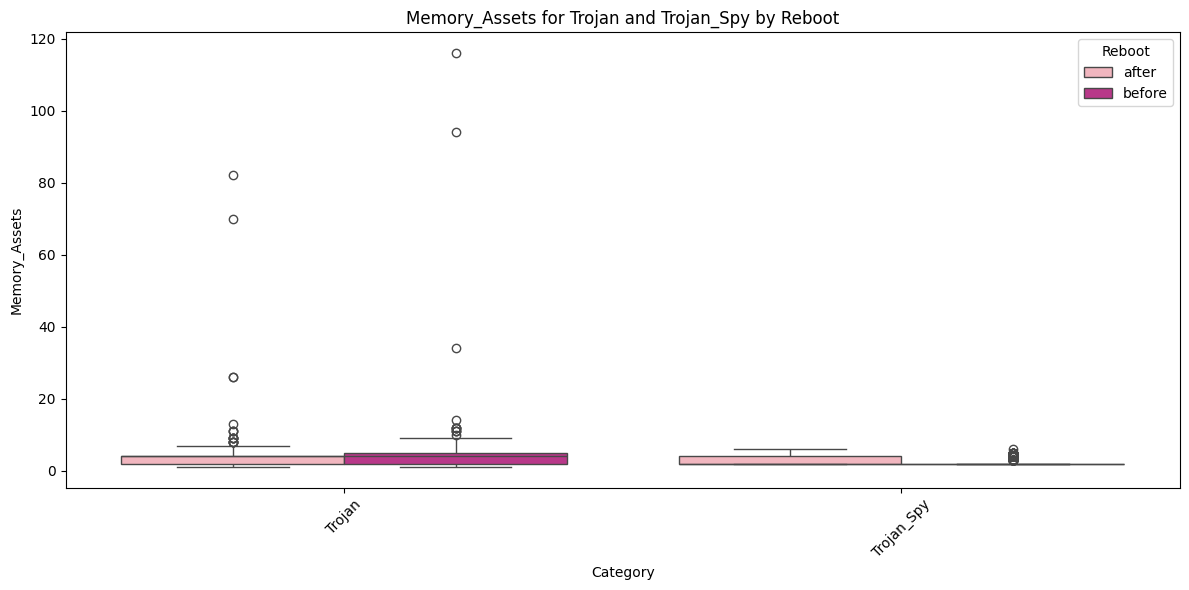

                    count      mean       std  min  25%  50%  75%    max
Category   Reboot                                                       
Trojan     after   4025.0  3.127205  2.032347  1.0  2.0  4.0  4.0   82.0
           before  4412.0  3.381913  2.630906  1.0  2.0  4.0  5.0  116.0
Trojan_Spy after   1039.0  2.615977  0.907990  2.0  2.0  2.0  4.0    6.0
           before  1801.0  2.472515  0.843567  2.0  2.0  2.0  2.0    6.0


In [63]:
filtered_data = default_pipeline.dataset.df[
    default_pipeline.dataset.df['Category'].isin(['Trojan', 'Trojan_Spy'])
]

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x='Category', y='Memory_Assets', hue='Reboot', palette='RdPu')
plt.title('Memory_Assets for Trojan and Trojan_Spy by Reboot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

describe_stats = filtered_data.groupby(['Category', 'Reboot'])['Memory_Assets'].describe()
print(describe_stats)


For Trojan malware, there is a slight decrease in average memory asset usage after reboot, with standard deviation also decreasing, suggesting that post-reboot behavior becomes slightly more consistent and less variable. The maximum number of assets used also drops, possibly due to some processes being reset.

In contrast, Trojan_Spy shows a slight increase in average memory assets after reboot. The maximum memory usage remains similar in both cases, but the interquartile range widens post-reboot, suggesting that while the majority of these samples remain equal, a few instances may become slightly more active or complex after the system restarts.

### Binders

- Memory_LocalBinders: counts how many local binder objects exist within an app’s process.
- Memory_ProxyBinders: counts how many proxy binder objects exist in the app’s process

In [64]:
binder_features = ['Memory_LocalBinders', 'Memory_ProxyBinders']

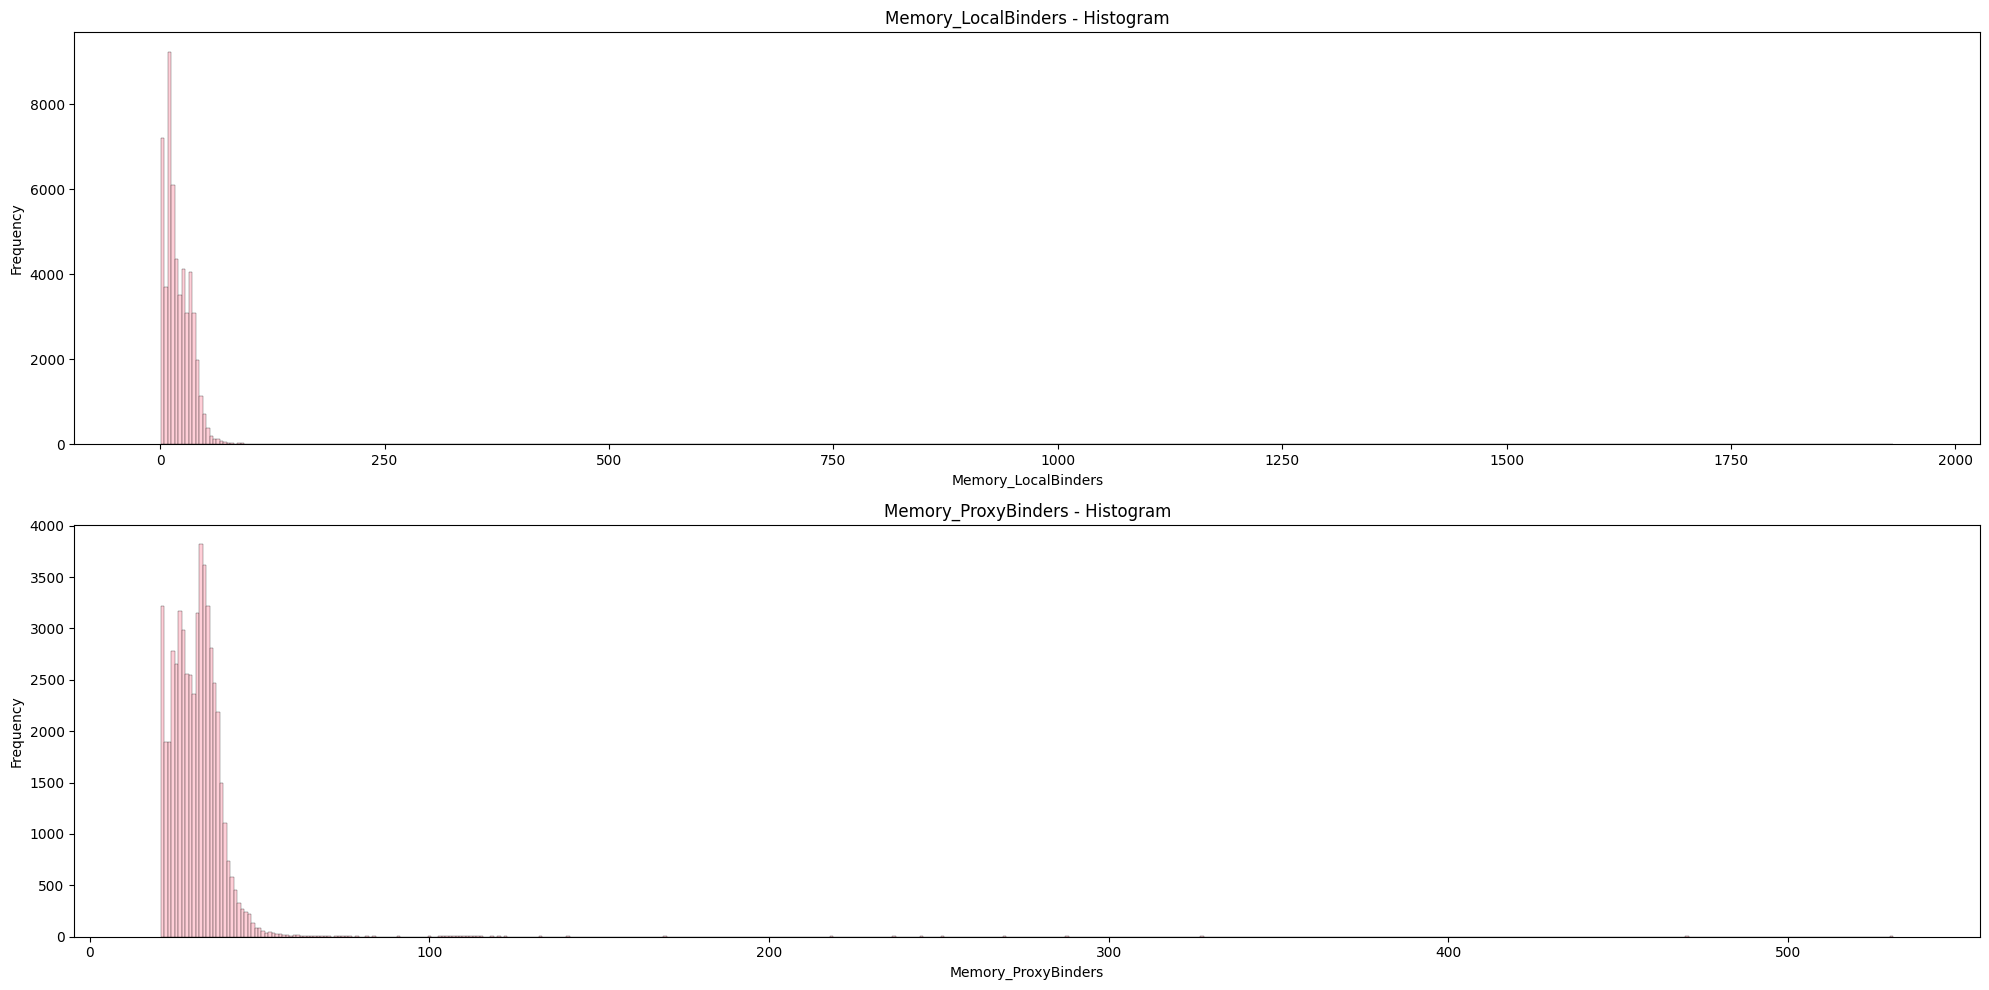

In [65]:
default_pipeline.EDA.plot_histograms(binder_features, n_cols=1, bins=500)

In [66]:
default_pipeline.dataset.df[binder_features].describe()

,Memory_LocalBinders,Memory_ProxyBinders
count,53439.000000,53439.000000
mean,20.422051,31.720391
std,18.587868,7.677878
min,1.000000,21.000000
25%,10.000000,27.000000
50%,17.000000,32.000000
75%,30.000000,36.000000
max,1931.000000,531.000000


In [67]:
default_pipeline.dataset.df.groupby('Category')['Memory_LocalBinders'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,23.147450,16.571523,1.0,10.0,20.0,35.0,329.0
Backdoor,1137.0,16.457344,12.949597,2.0,8.0,13.0,22.0,82.0
FileInfector,248.0,23.802419,16.608534,2.0,10.0,16.0,33.0,97.0
No_Category,1932.0,22.645963,17.732138,2.0,9.0,19.0,33.0,211.0
PUA,1290.0,16.821705,15.744099,2.0,2.0,15.0,26.0,103.0
Ransomware,3411.0,16.567575,13.660453,2.0,10.0,11.0,19.0,137.0
Riskware,14053.0,17.597239,15.221770,2.0,5.0,15.0,25.0,467.0
Scareware,886.0,26.730248,9.646552,2.0,24.0,28.0,31.0,85.0
Trojan,8437.0,24.255778,16.140438,2.0,13.0,26.0,33.0,894.0


When it comes to local binders, Trojan malware has the highest mean values (24.26), which shows a significant interaction with local system resources, such as persistent background services or system components. This could be attributed to Trojans' tendency to establish long-term persistence, often using local communication channels to stay hidden, execute commands, or propagate within the system. Scareware has the second-highest mean (26.73), suggesting that while it may be designed primarily to intimidate users with false warnings and demands, it still employs substantial communication to manipulate or interact with system components, likely triggering local Binder calls to push notifications or simulate legitimate processes. On the other hand, Trojan_Spy shows a mean of 14.47, which reflects the more passive nature of this malware, as it typically focuses on monitoring user data.

In [68]:
default_pipeline.dataset.df.groupby('Category')['Memory_ProxyBinders'].describe()


,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,32.031785,6.253968,21.0,27.0,33.0,36.0,91.0
Backdoor,1137.0,30.774846,6.194639,21.0,27.0,29.0,35.0,54.0
FileInfector,248.0,31.270161,5.227186,21.0,27.0,30.0,35.0,47.0
No_Category,1932.0,32.682712,7.273402,21.0,27.0,32.0,36.0,84.0
PUA,1290.0,29.595349,6.553756,21.0,24.0,29.0,34.0,60.0
Ransomware,3411.0,30.492817,6.918007,22.0,26.0,28.0,32.0,141.0
Riskware,14053.0,30.811570,6.234294,21.0,26.0,31.0,34.0,169.0
Scareware,886.0,33.920993,3.862681,21.0,33.0,35.0,35.0,56.0
Trojan,8437.0,33.619296,9.334590,21.0,29.0,33.0,37.0,470.0


When it comes to proxy binders, malware like Adware and Trojan have relatively high mean values (32.03 and 33.62). Adware, may use these binders for communicating with external servers to serve advertisements or collect data, resulting in higher memory usage. Trojans, might use proxy binders for maintaining communication with command and control servers. 

Malware in the Scareware category exhibits the highest average (33.92), but with a much smaller standard deviation (3.86), implying consistent, targeted behaviors.

### Parcel

- Memory_ParcelMemory: total memory allocated for active IPC parcels
- Memory_ParcelCount: number of parcels currently in use for IPC transactions

In [69]:
parcel_features = ['Memory_ParcelMemory', 'Memory_ParcelCount']

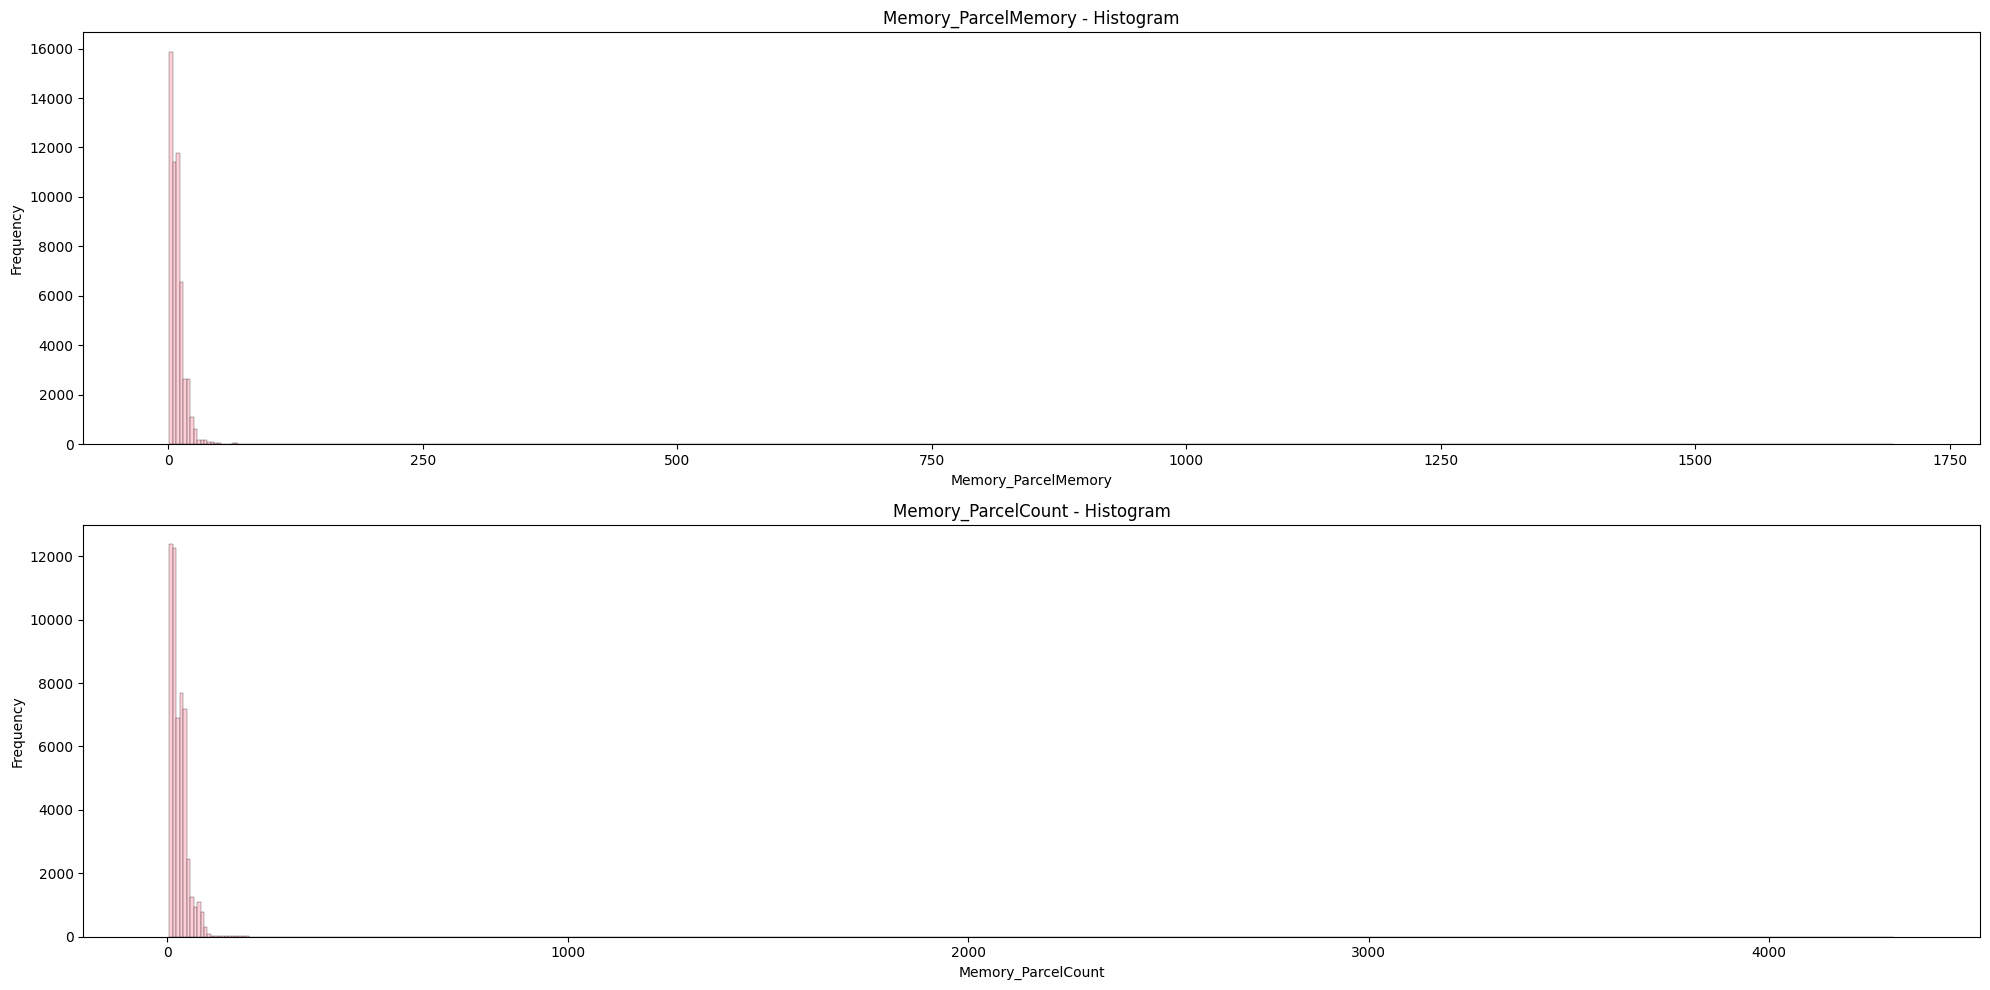

In [70]:
default_pipeline.EDA.plot_histograms(parcel_features, n_cols=1, bins=500)

In [71]:
default_pipeline.dataset.df[parcel_features].describe()

,Memory_ParcelMemory,Memory_ParcelCount
count,53439.000000,53439.000000
mean,9.277007,30.765883
std,14.612777,33.224723
min,1.000000,6.000000
25%,4.000000,15.000000
50%,7.000000,25.000000
75%,12.000000,41.000000
max,1695.000000,4311.000000


C:\Users\Cate\AppData\Local\Temp\ipykernel_24024\605397417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=default_pipeline.dataset.df, x='Category', y=feature, palette='RdPu')


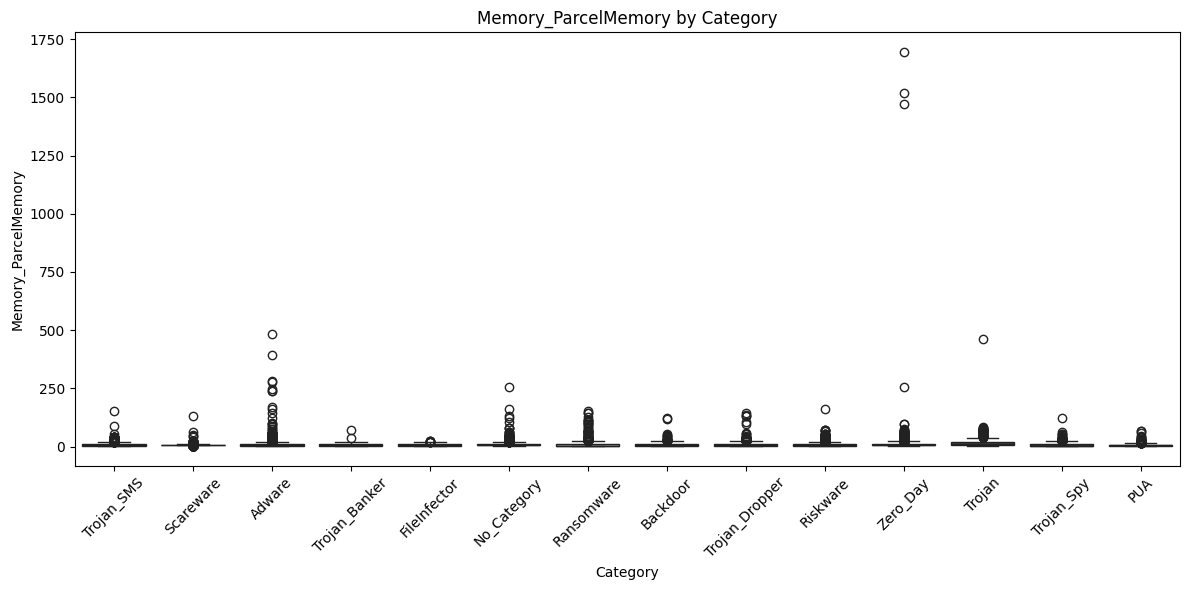

C:\Users\Cate\AppData\Local\Temp\ipykernel_24024\605397417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=default_pipeline.dataset.df, x='Category', y=feature, palette='RdPu')


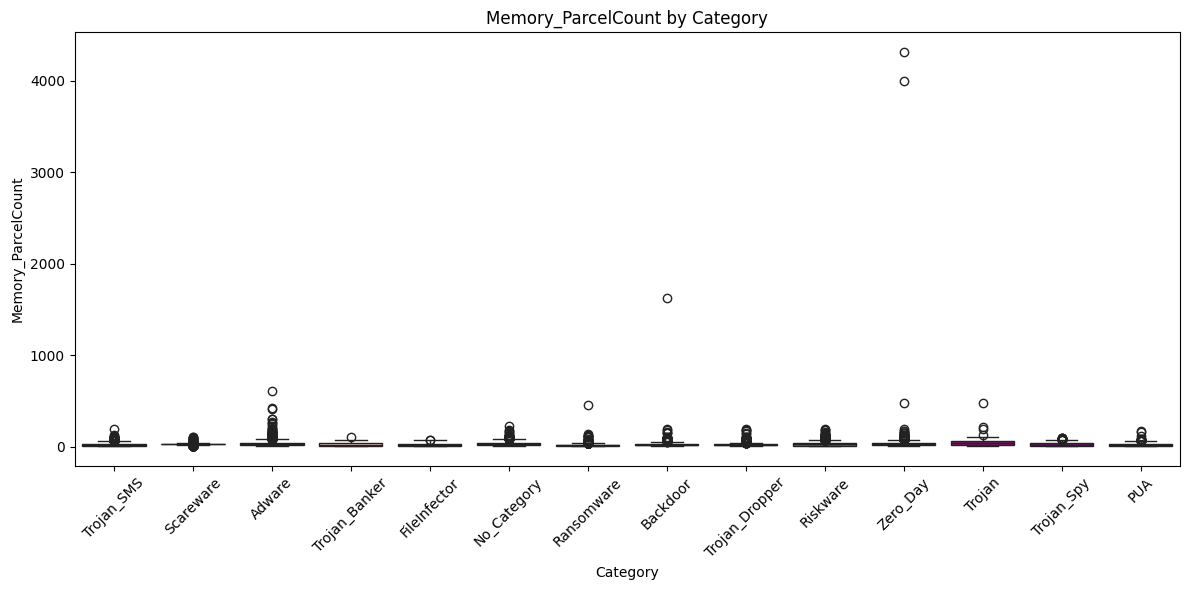

In [72]:
for feature in parcel_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=default_pipeline.dataset.df, x='Category', y=feature, palette='RdPu')
    plt.title(f'{feature} by Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The boxplots appear quite similar across all features, with only a few outliers distinguishing them.

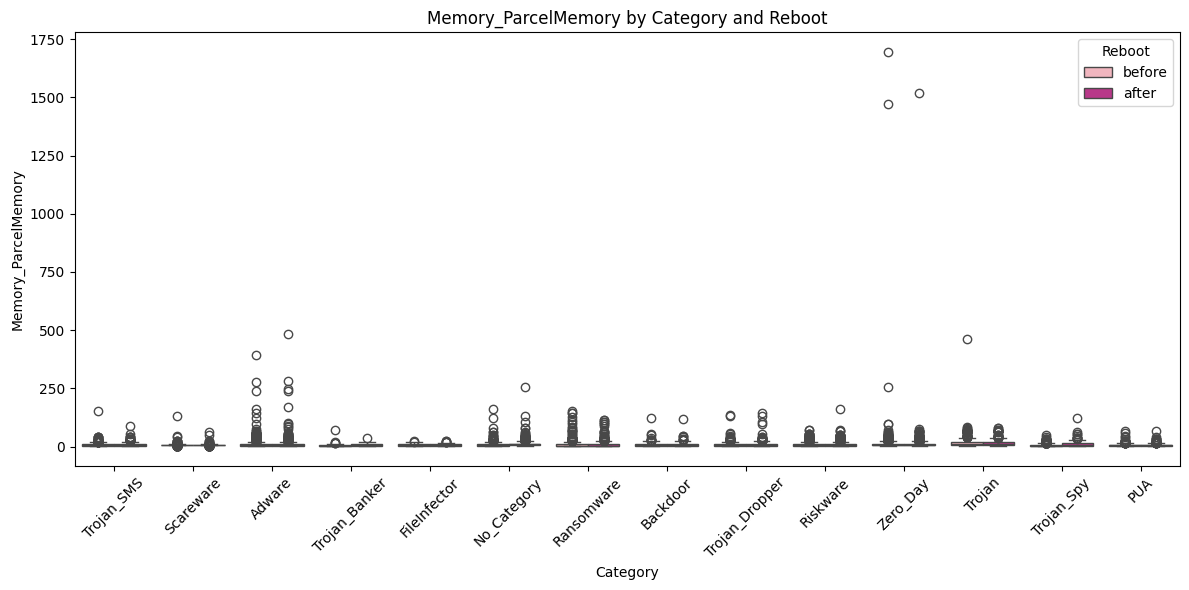

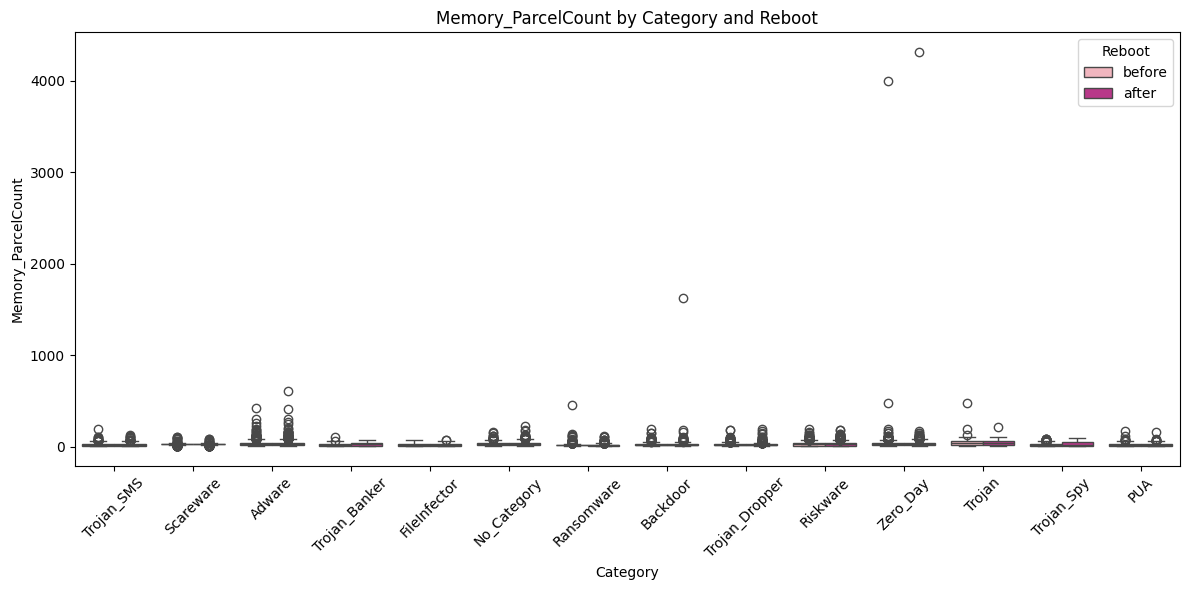

In [73]:
for feature in parcel_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=default_pipeline.dataset.df, x='Category', y=feature, hue='Reboot', palette='RdPu')
    plt.title(f'{feature} by Category and Reboot')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Overall, there is no significant difference in Parcel Memory or Parcel Count values before and after reboot across most malware categories. The distributions remain largely consistent, suggesting that these malware families rely on mechanisms that reinitialize their communication patterns upon system restart.

### Other

- Memory_DeathRecipients: tracks how many death recipient callbacks have been registered in the current process i.e. how many remote objects or services the app is monitoring for death.
- Memory_OpenSSLSockets: Number of OpenSSL socket connections. 

In [74]:
default_pipeline.dataset.df.groupby('Category')['Memory_DeathRecipients'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,1.281694,1.534487,0.0,0.0,0.0,3.0,9.0
Backdoor,1137.0,0.413369,1.091628,0.0,0.0,0.0,0.0,6.0
FileInfector,248.0,1.366935,1.560661,0.0,0.0,0.0,3.0,4.0
No_Category,1932.0,0.981884,1.383555,0.0,0.0,0.0,2.0,7.0
PUA,1290.0,0.572093,1.165776,0.0,0.0,0.0,0.0,9.0
Ransomware,3411.0,0.088830,0.469630,0.0,0.0,0.0,0.0,4.0
Riskware,14053.0,0.901943,1.501467,0.0,0.0,0.0,2.0,11.0
Scareware,886.0,2.744921,1.326118,0.0,3.0,3.0,4.0,4.0
Trojan,8437.0,0.688515,1.247825,0.0,0.0,0.0,1.0,7.0


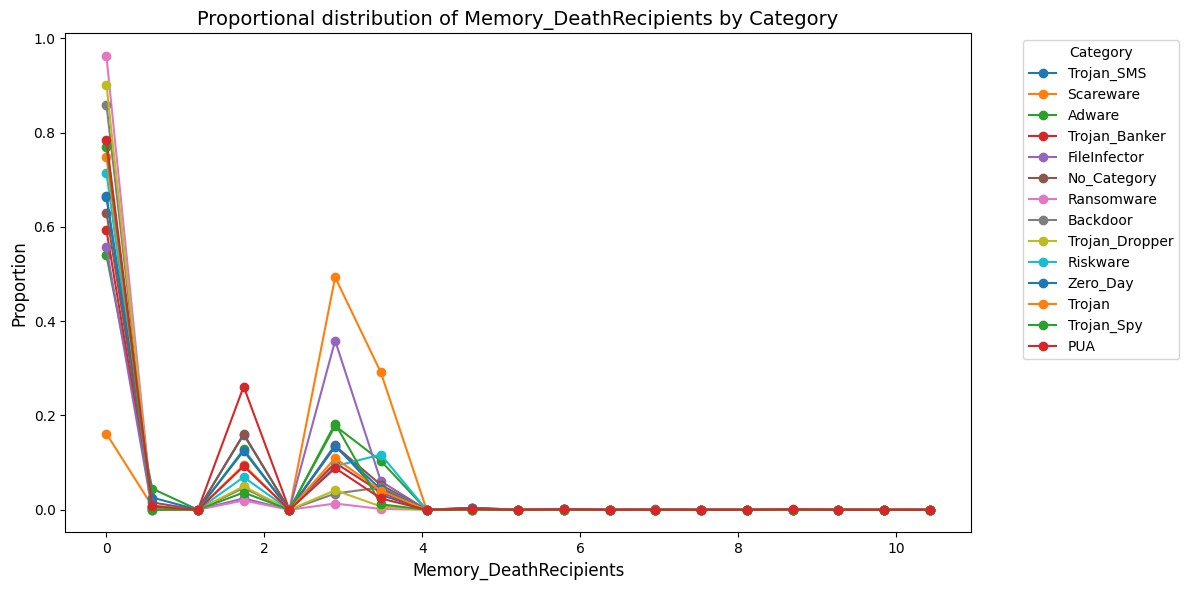

In [75]:
default_pipeline.EDA.plot_proportional_feature_frequency_by_category(feature="Memory_DeathRecipients", category_column="Category")

The plot and statistics show that the majority of malware categories show a high proportion of samples with zero Memory_DeathRecipients, meaning that these malware types rarely maintain strong binder-related IPC ties that would require death recipient monitoring. However, Scareware stands out with a significantly higher average and tighter distribution centered around 3, suggesting a more persistent use of binder IPC mechanisms, possibly for user interaction or persistence. Categories like FileInfector and Adware also show elevated values compared to others, likely due to their tendency to hook into system processes more aggressively. 

In [76]:
default_pipeline.dataset.df.groupby(['Category'])['Memory_OpenSSLSockets'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,0.653279,2.947472,0.0,0.0,0.0,0.0,77.0
Backdoor,1137.0,0.356201,1.563993,0.0,0.0,0.0,0.0,23.0
FileInfector,248.0,0.129032,0.582717,0.0,0.0,0.0,0.0,4.0
No_Category,1932.0,0.471014,2.306339,0.0,0.0,0.0,0.0,43.0
PUA,1290.0,0.391473,3.188335,0.0,0.0,0.0,0.0,55.0
Ransomware,3411.0,0.006450,0.087081,0.0,0.0,0.0,0.0,2.0
Riskware,14053.0,0.183591,1.582226,0.0,0.0,0.0,0.0,92.0
Scareware,886.0,0.125282,1.949966,0.0,0.0,0.0,0.0,38.0
Trojan,8437.0,0.057366,0.457309,0.0,0.0,0.0,0.0,22.0


Malware categories open very few SSL sockets, with mean values consistently at zero, suggesting limited use of secure communications during execution. However, a few categories like Adware and PUA stand out with higher means and large standard deviations. In contrast, categories such as Ransomware, Trojan_Spy, and Trojan show almost negligible SSL socket usage

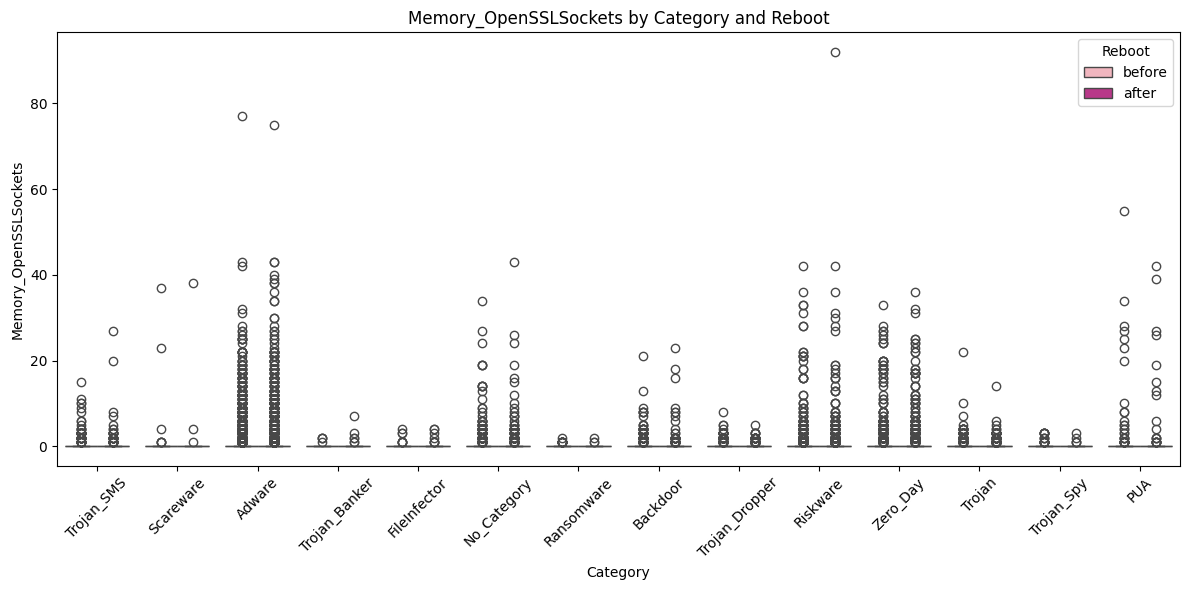

In [77]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='Memory_OpenSSLSockets', hue='Reboot', palette='RdPu')
plt.title('Memory_OpenSSLSockets by Category and Reboot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [78]:

default_pipeline.dataset.df.groupby(['Category', 'Reboot'])['Memory_OpenSSLSockets'].describe()

count      mean       std  min  25%  50%  75%   max
Category       Reboot                                                      
Adware         after   5142.0  0.687281  3.163174  0.0  0.0  0.0  0.0  75.0
               before  5838.0  0.623330  2.743401  0.0  0.0  0.0  0.0  77.0
Backdoor       after    546.0  0.305861  1.642286  0.0  0.0  0.0  0.0  23.0
               before   591.0  0.402707  1.487892  0.0  0.0  0.0  0.0  21.0
FileInfector   after    119.0  0.142857  0.628230  0.0  0.0  0.0  0.0   4.0
               before   129.0  0.116279  0.539501  0.0  0.0  0.0  0.0   4.0
No_Category    after    884.0  0.447964  2.333615  0.0  0.0  0.0  0.0  43.0
               before  1048.0  0.490458  2.284014  0.0  0.0  0.0  0.0  34.0
PUA            after    625.0  0.345600  2.991802  0.0  0.0  0.0  0.0  42.0
               before   665.0  0.434586  3.364280  0.0  0.0  0.0  0.0  55.0
Ransomware     after   1550.0  0.002581  0.062184  0.0  0.0  0.0  0.0   2.0
               before  1861.0  0.009672  0.103243  0.0  0.0  0.0  0.0   2.0
Riskware       after   6792.0  0.180065  1.709536  0.0  0.0  0.0  0.0  92.0
               before  7261.0  0.186889  1.453190  0.0  0.0  0.0  0.0  42.0
Scareware      after    424.0  0.101415  1.855692  0.0  0.0  0.0  0.0  38.0
               before   462.0  0.147186  2.034407  0.0  0.0  0.0  0.0  37.0
Trojan         after   4025.0  0.050932  0.386964  0.0  0.0  0.0  0.0  14.0
               before  4412.0  0.063237  0.513115  0.0  0.0  0.0  0.0  22.0
Trojan_Banker  after    123.0  0.130081  0.735063  0.0  0.0  0.0  0.0   7.0
               before   118.0  0.059322  0.327966  0.0  0.0  0.0  0.0   2.0
Trojan_Dropper after    733.0  0.163711  0.485239  0.0  0.0  0.0  0.0   5.0
               before   837.0  0.248507  0.732296  0.0  0.0  0.0  0.0   8.0
Trojan_SMS     after    911.0  0.147091  1.239590  0.0  0.0  0.0  0.0  27.0
               before  1028.0  0.158560  0.977425  0.0  0.0  0.0  0.0  15.0
Trojan_Spy     after   1039.0  0.007700  0.123915  0.0  0.0  0.0  0.0   3.0
               before  1801.0  0.019434  0.205912  0.0  0.0  0.0  0.0   3.0
Zero_Day       after   2146.0  0.606710  2.535534  0.0  0.0  0.0  0.0  36.0
               before  2329.0  0.634178  2.563315  0.0  0.0  0.0  0.0  33.0

If we compare the data before and after reboot across different malware categories, it shows minimal variation, indicating that rebooting does not significantly affect this behavior

## API

### Network (Java, Apache, .com)

Features: 
- java.net.URL_openConnection: tracks the calls of openConnection(), this is a java method to open a network connection, once opened its used to send /receive data on the internet.
- org.apache.http.impl.client.AbstractHttpClient_execute: tracks the calls of execute(), which executes and HTTP process like GET, POST, PUT, DELETE
- HttpURLConnectionImpl_getInputStream: after a network connection is opened, getInputStream() reads the response data from the server (Image, text files, malicious binary..).
    - Huc: Compared to the next feature this one is designed to mimic the behavior of the official Java HttpURLConnection. The app is probably using standard-looking Java networking code (but internally it’s backed by OkHttp)
    - HTTP: This feature is used inside the OkHttp library itself to manage lower-level HTTP interactions

The only 2 related features are the last 2, so we are going to perform three different analysis

#### java.net.URL_openConnection

In [139]:
default_pipeline.dataset.df["API_Network_java.net.URL_openConnection"].describe()

count    53439.000000
mean         9.327439
std         56.661542
min          0.000000
25%          0.000000
50%          0.000000
75%          7.000000
max       8636.000000
Name: API_Network_java.net.URL_openConnection, dtype: float64

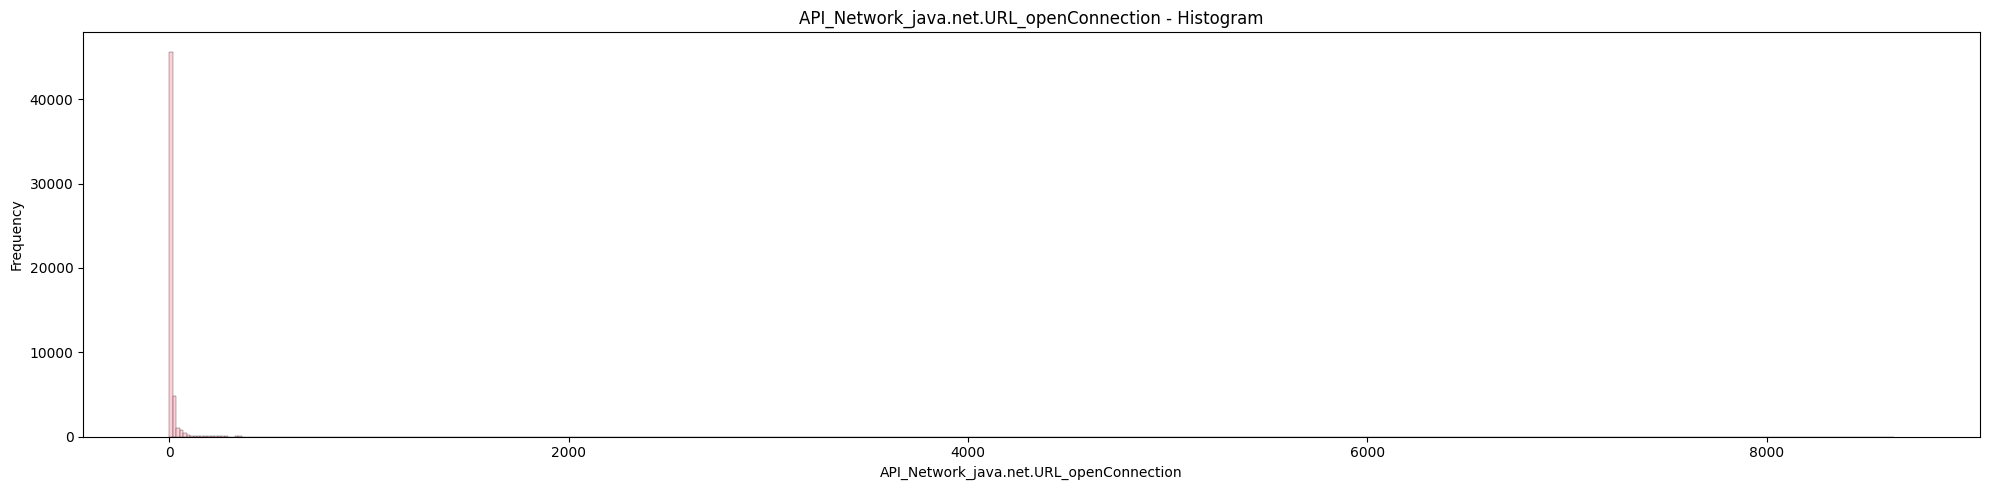

In [79]:
default_pipeline.EDA.plot_histograms(features=["API_Network_java.net.URL_openConnection"], n_cols=1, bins=500)

In [157]:
default_pipeline.dataset.df.groupby('Category')['API_Network_java.net.URL_openConnection'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,12.526594,100.318829,0.0,0.0,3.0,16.0,8636.0
Backdoor,1137.0,12.781882,49.591624,0.0,0.0,0.0,2.0,653.0
FileInfector,248.0,4.504032,22.749471,0.0,0.0,0.0,0.0,292.0
No_Category,1932.0,7.427019,21.905979,0.0,0.0,0.0,4.0,295.0
PUA,1290.0,5.933333,16.944034,0.0,0.0,0.0,1.0,148.0
Ransomware,3411.0,0.250953,3.418733,0.0,0.0,0.0,0.0,76.0
Riskware,14053.0,14.291681,50.593493,0.0,1.0,4.0,18.0,4909.0
Scareware,886.0,1.480813,10.581253,0.0,0.0,0.0,0.0,197.0
Trojan,8437.0,4.047410,27.704452,0.0,0.0,0.0,1.0,1002.0


Adware and Riskware generate a lot of network traffic. Trojans, Backdoors generate moderate but focused network traffic.



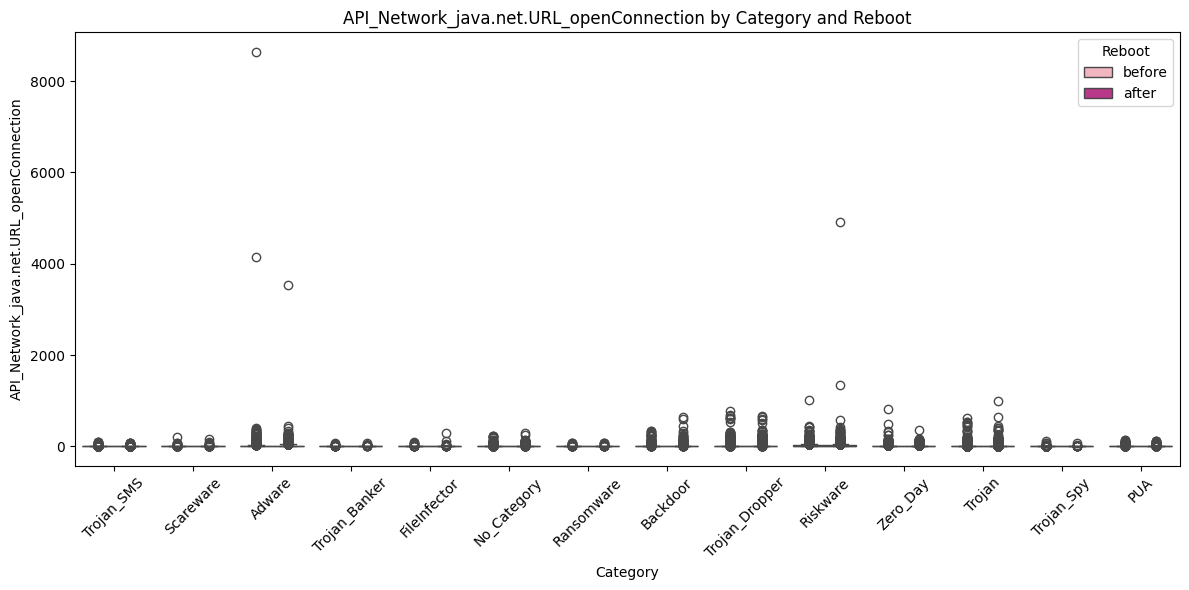

In [165]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=default_pipeline.dataset.df, x='Category', y='API_Network_java.net.URL_openConnection', hue='Reboot', palette='RdPu')
plt.title('API_Network_java.net.URL_openConnection by Category and Reboot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [171]:
q1 = default_pipeline.dataset.df["API_Network_java.net.URL_openConnection"].quantile(0.25)
q3 = default_pipeline.dataset.df["API_Network_java.net.URL_openConnection"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = default_pipeline.dataset.df[
    (default_pipeline.dataset.df["API_Network_java.net.URL_openConnection"] < lower_bound) | 
    (default_pipeline.dataset.df["API_Network_java.net.URL_openConnection"] > upper_bound)
]
print(outliers[["Category", "API_Network_java.net.URL_openConnection"]])

         Category  API_Network_java.net.URL_openConnection
9      Trojan_SMS                                       23
21     Trojan_SMS                                       26
25     Trojan_SMS                                       31
29     Trojan_SMS                                       20
30     Trojan_SMS                                       60
...           ...                                      ...
53398         PUA                                       37
53400         PUA                                       38
53402         PUA                                       22
53410         PUA                                       61
53423         PUA                                       72

[7777 rows x 2 columns]


Proportion of outliers by category:
Category
Riskware          25.419580
Adware            16.097902
Zero_Day           4.076923
Trojan             1.958042
Trojan_Dropper     1.951049
No_Category        1.720280
PUA                0.902098
Backdoor           0.895105
Trojan_SMS         0.797203
Trojan_Banker      0.181818
Scareware          0.125874
FileInfector       0.090909
Ransomware         0.090909
Trojan_Spy         0.076923
Name: count, dtype: float64


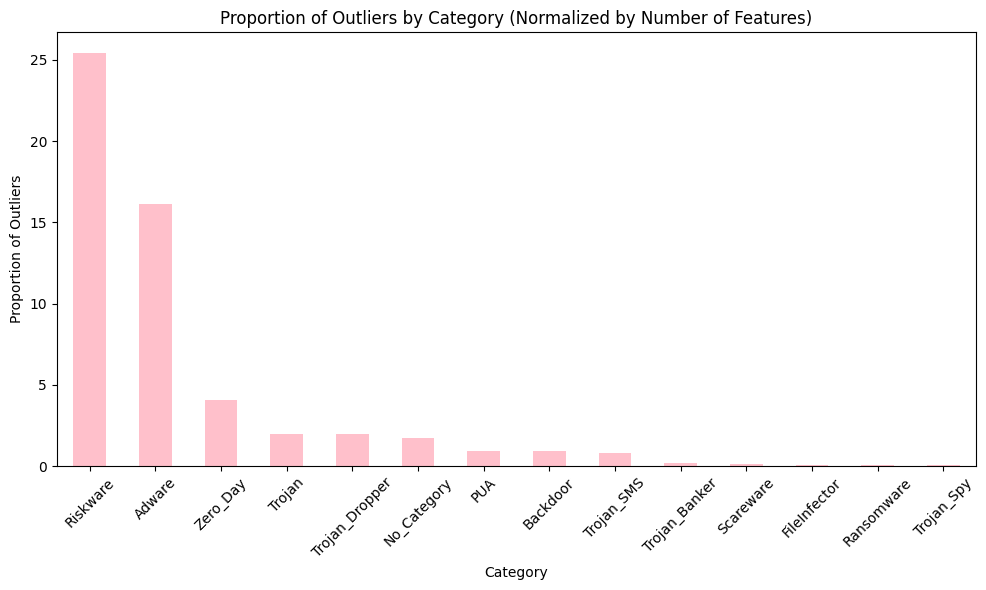

In [181]:
category_counts = outliers["Category"].value_counts()

num_features = len(default_pipeline.dataset.df.columns)

proportion_outliers = (category_counts / num_features).sort_values(ascending=False)

print("Proportion of outliers by category:")
print(proportion_outliers)

proportion_outliers.plot(kind='bar', color='pink', figsize=(10, 6))
plt.title("Proportion of Outliers by Category (Normalized by Number of Features)")
plt.xlabel("Category")
plt.ylabel("Proportion of Outliers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Outliers found mainly in: Riskware (25% of outliers), Adware (16% of outliers), Zero_Day (4%) and Trojan (2%). 

Riskware and Adware behave much more "aggressively" in networking than most other categories.


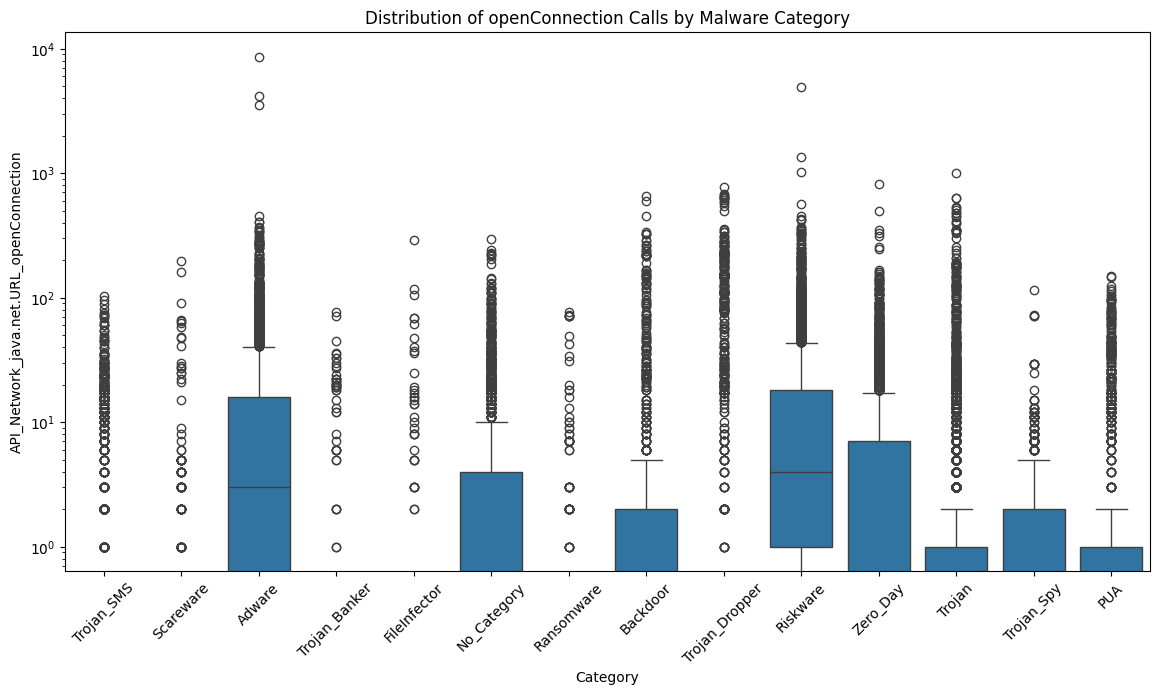

In [180]:
import seaborn as sns
plt.figure(figsize=(14,7))
sns.boxplot(x="Category", y="API_Network_java.net.URL_openConnection", data=default_pipeline.dataset.df)
plt.xticks(rotation=45)
plt.yscale("log") 
plt.title("Distribution of openConnection Calls by Malware Category")
plt.show()

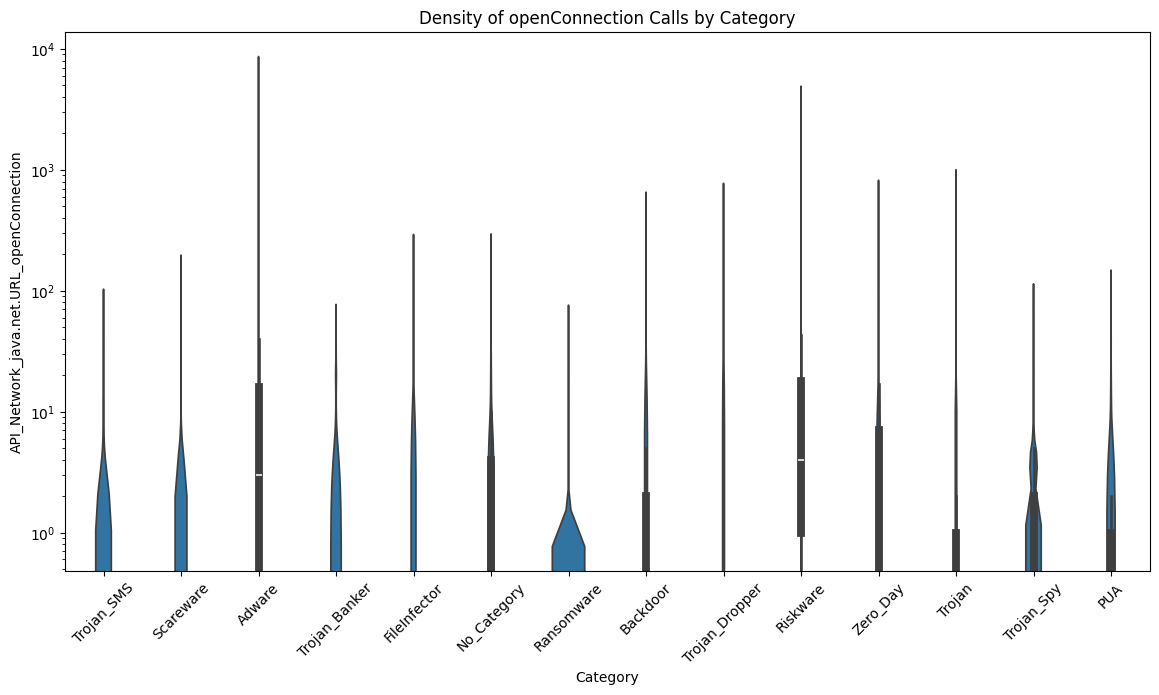

In [178]:
plt.figure(figsize=(14,7))
sns.violinplot(x="Category", y="API_Network_java.net.URL_openConnection", data=default_pipeline.dataset.df, cut=0)
plt.xticks(rotation=45)
plt.yscale("log")
plt.title("Density of openConnection Calls by Category")
plt.show()


Ransomware seems to barely use openConnection, ransomware usually encrypts local files and might only make one call (example: for key exchange).

Creating a binary feature to indicate samples with high numbers of openConnection calls can be specially useful for categories like Adware and Riskware, which frequently have extremely high connection counts. Since different malware categories naturally have varying baseline behaviors, constructing a category-relative feature (such as the ratio between a sample connection count and its category median) can be more useful in general 

#### org.apache.http.impl.client.AbstractHttpClient_execute

#### HttpURLConnectionImpl_getInputStream (Huc and HTTP)

### Dex Class Loader

### Base 64 

### System Manager

### SMS

- API_SMS_android.telephony.SmsManager_sendTextMessage: allows an app to send a single, standard SMS message. Typically used to send short text messages to a specific phone number, where the message size is within the limit (160 characters)
- API_SMS_android.telephony.SmsManager_sendMultipartTextMessage: This is another method in the SmsManager class that allows for sending a text message that exceeds the normal 160 character limit.


In [182]:
sms_features = [
    "API_SMS_android.telephony.SmsManager_sendTextMessage",
    "API_SMS_android.telephony.SmsManager_sendMultipartTextMessage"
]


In [183]:
print(default_pipeline.dataset.df[sms_features].describe())

       API_SMS_android.telephony.SmsManager_sendTextMessage  \
count                                       53439.000000      
mean                                            0.364359      
std                                             8.297365      
min                                             0.000000      
25%                                             0.000000      
50%                                             0.000000      
75%                                             0.000000      
max                                           570.000000      

       API_SMS_android.telephony.SmsManager_sendMultipartTextMessage  
count                                       53439.000000              
mean                                            0.024495              
std                                             0.430527              
min                                             0.000000              
25%                                             0.000000              
50%   

API_SMS_android.telephony.SmsManager_sendTextMessage


These 2 methods are called really infrequently, the average number of times this method is called per record is about 0.364. However the value of 8.297 indicates that the number of calls to this method varies greatly. There are some entries where the method is used a lot (up to 570 calls), while most use it very little or not at all.

API_SMS_android.telephony.SmsManager_sendMultipartTextMessage
he average number of calls to this method per record is 0.0245, which is much lower than for sendTextMessage, mking it an even more rare event, the variabilit is also much lower. 




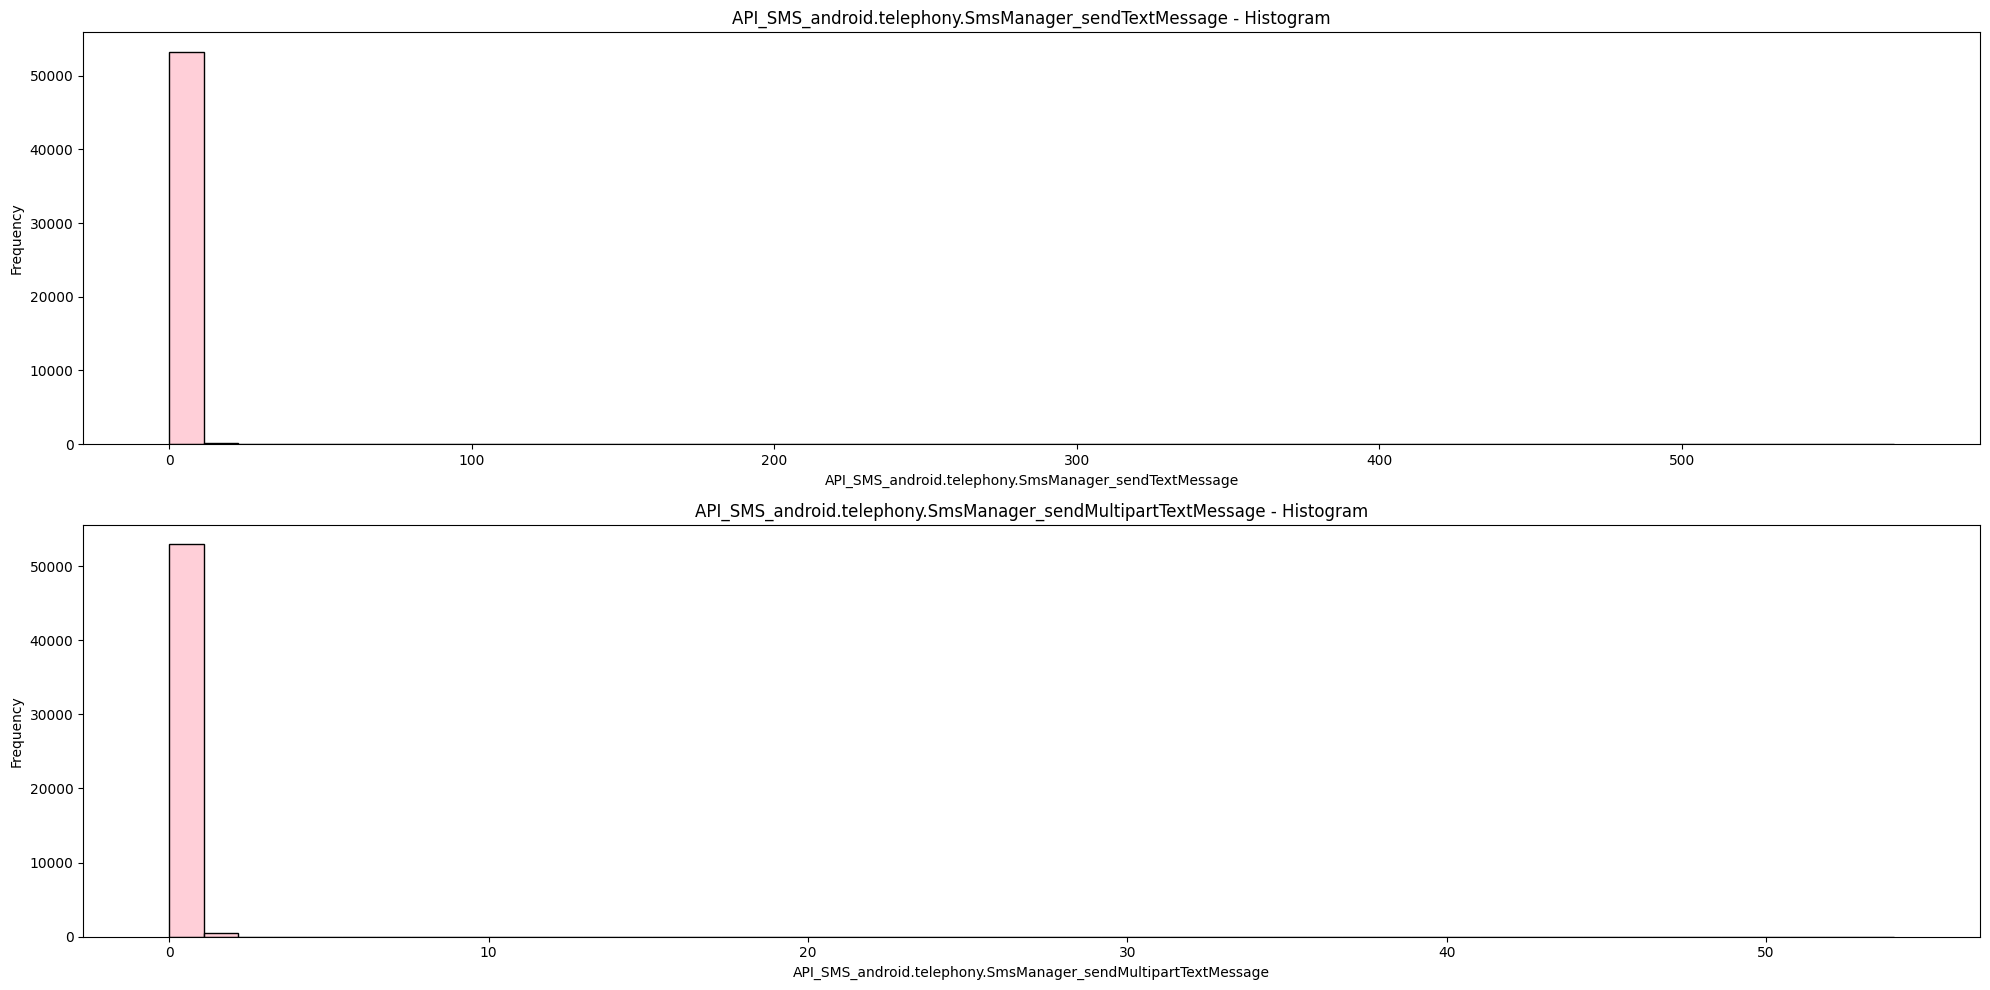

In [184]:
default_pipeline.EDA.plot_histograms(features=sms_features, n_cols=1, bins=50)

In [186]:
for feature in sms_features:
    print(f"\n{feature}:")
    print(default_pipeline.dataset.df.groupby("Category")[feature].describe())


API_SMS_android.telephony.SmsManager_sendTextMessage:
                  count      mean        std  min  25%  50%  75%    max
Category                                                               
Adware          10980.0  0.012659   0.434763  0.0  0.0  0.0  0.0   25.0
Backdoor         1137.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
FileInfector      248.0  0.205645   1.142680  0.0  0.0  0.0  0.0   10.0
No_Category      1932.0  0.597308   3.370502  0.0  0.0  0.0  0.0   56.0
PUA              1290.0  0.000000   0.000000  0.0  0.0  0.0  0.0    0.0
Ransomware       3411.0  0.635298   4.727604  0.0  0.0  0.0  0.0   78.0
Riskware        14053.0  0.049456   0.594035  0.0  0.0  0.0  0.0   40.0
Scareware         886.0  0.019187   0.224675  0.0  0.0  0.0  0.0    3.0
Trojan           8437.0  0.157639   3.356846  0.0  0.0  0.0  0.0  300.0
Trojan_Banker     241.0  0.053942   0.226373  0.0  0.0  0.0  0.0    1.0
Trojan_Dropper   1570.0  0.000637   0.025238  0.0  0.0  0.0  0.0    1.0
Trojan_SM

API_SMS_android.telephony.SmsManager_sendTextMessage: Trojan and Ransomware categories are the most frequent users of sendTextMessage.


API_SMS_android.telephony.SmsManager_sendMultipartTextMessage: For adware, backdoor, file infector, PUA, riskware, scareware and trojan banker they dont sen any long message. Multipart messages are rare accross al categories ransomware and trojan malware use multipart messages only in very specific cases, with very low frequency.


API_SMS_android.telephony.SmsManager_sendTextMessage:
Normalized counts:
Category
Adware            0.001366
Backdoor               NaN
FileInfector      0.040323
No_Category       0.076087
PUA                    NaN
Ransomware        0.047493
Riskware          0.017221
Scareware         0.007901
Trojan            0.050255
Trojan_Banker     0.053942
Trojan_Dropper    0.000637
Trojan_SMS        0.186178
Trojan_Spy        0.239437
Zero_Day          0.150615
dtype: float64


C:\Users\Cate\AppData\Local\Temp\ipykernel_24024\1396081176.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x="Category", y=feature, palette="RdPu")


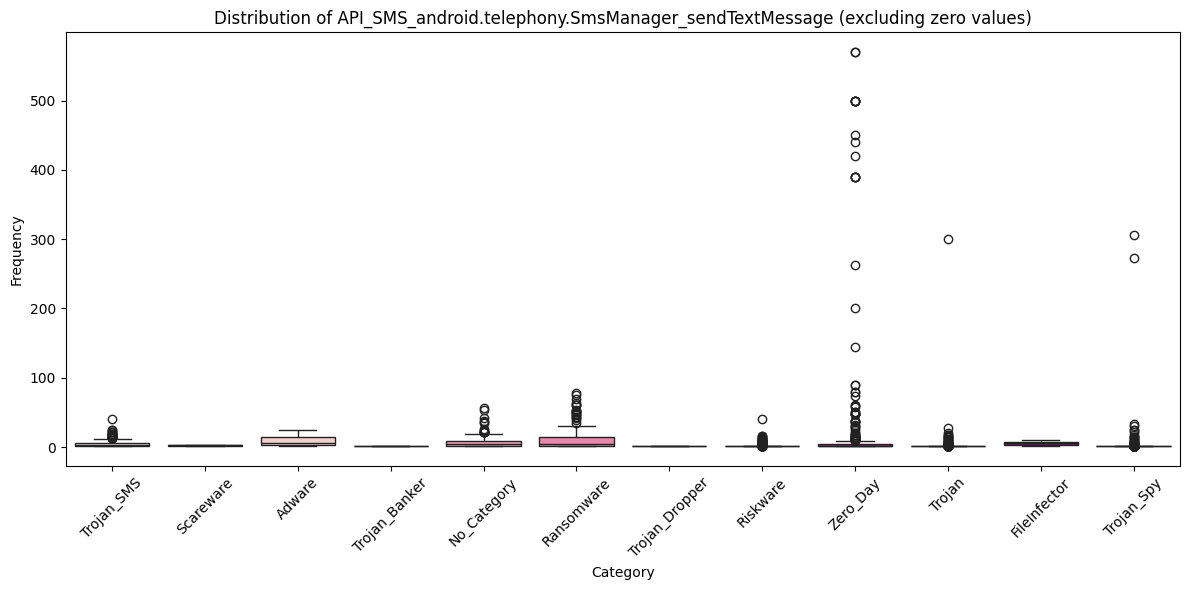

In [196]:
feature = "API_SMS_android.telephony.SmsManager_sendTextMessage"

print(f"\n{feature}:")
non_zero_counts = (
    default_pipeline.dataset.df[default_pipeline.dataset.df[feature] > 0]
    .groupby("Category")[feature]
    .count()
)
total_counts = default_pipeline.dataset.df["Category"].value_counts()
normalized_counts = non_zero_counts / total_counts
    
# Display the normalized results
print("Normalized counts:")
print(normalized_counts)

filtered_data = default_pipeline.dataset.df[default_pipeline.dataset.df[feature] > 0]
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x="Category", y=feature, palette="RdPu")
plt.title(f"Distribution of {feature} (excluding zero values)")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Tthe Trojan_Spy category, which has a remarkably high normalized count of 0.239. This suggests that Spyware Trojans heavily rely on SMS messages, likely for surveillance purposes, such as sending back stolen information or receiving commands from a remote attacker. Trojan_SMS also exhibits significant use with a normalized count of 0.186, this is not surprising as SMS is a key method for spreading this particular Trojan.


API_SMS_android.telephony.SmsManager_sendMultipartTextMessage:
Normalized counts:
Category
Adware                 NaN
Backdoor               NaN
FileInfector           NaN
No_Category       0.005694
PUA                    NaN
Ransomware        0.001759
Riskware               NaN
Scareware              NaN
Trojan            0.000474
Trojan_Banker          NaN
Trojan_Dropper    0.000637
Trojan_SMS        0.003610
Trojan_Spy        0.186620
Zero_Day          0.000223
dtype: float64


C:\Users\Cate\AppData\Local\Temp\ipykernel_24024\2621055589.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x="Category", y=feature, palette="RdPu")


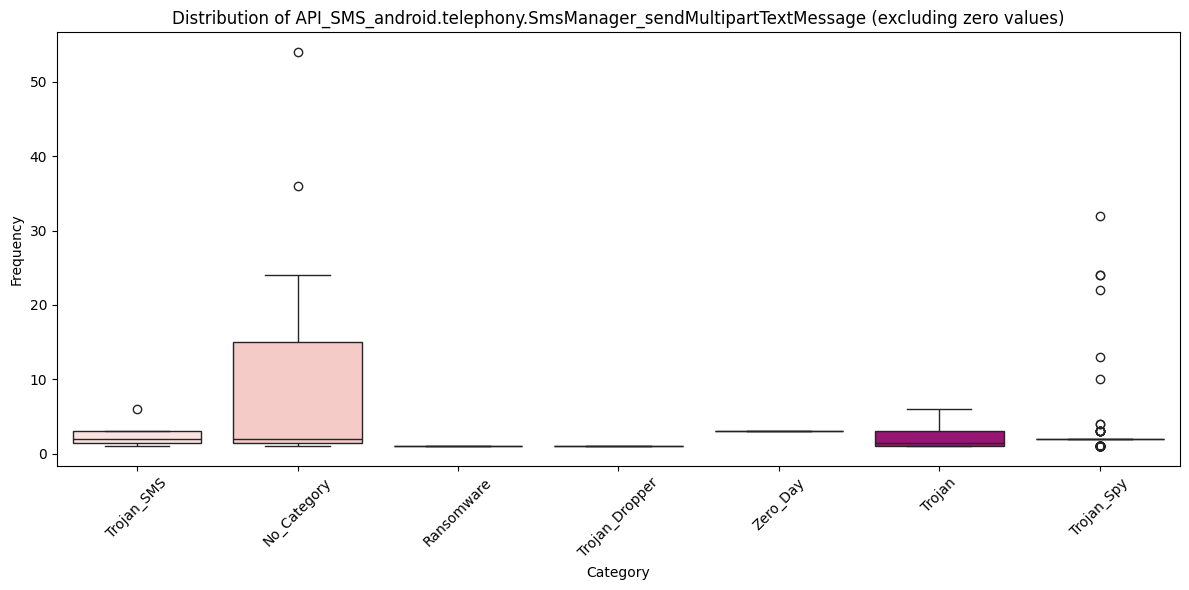

In [195]:
feature = "API_SMS_android.telephony.SmsManager_sendMultipartTextMessage"

print(f"\n{feature}:")
non_zero_counts = (
    default_pipeline.dataset.df[default_pipeline.dataset.df[feature] > 0]
    .groupby("Category")[feature]
    .count()
)
total_counts = default_pipeline.dataset.df["Category"].value_counts()
normalized_counts = non_zero_counts / total_counts
    
# Display the normalized results
print("Normalized counts:")
print(normalized_counts)

filtered_data = default_pipeline.dataset.df[default_pipeline.dataset.df[feature] > 0]
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x="Category", y=feature, palette="RdPu")
plt.title(f"Distribution of {feature} (excluding zero values)")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In this feature, Trojan_Spy is exceptionally high compared to other categories. Trojan_SMS has a normalized count of 0.00361, which is higher than other Trojan variants but still much lower than Trojan_Spy. Categories such as Adware, Backdoor, FileInfector, Riskware, Scareware, and PUA show NaN (Not a Number) values, indicating that multipart SMS messages are either never used or are so infrequent that they don’t contribute to the data in any meaningful way. 


Proportion of outliers by category:
Category
Trojan_Spy        4.755245
Zero_Day          4.713287
Trojan            2.965035
Trojan_SMS        2.524476
Riskware          1.692308
Ransomware        1.132867
No_Category       1.027972
Adware            0.104895
Trojan_Banker     0.090909
FileInfector      0.069930
Scareware         0.048951
Trojan_Dropper    0.006993
Name: count, dtype: float64


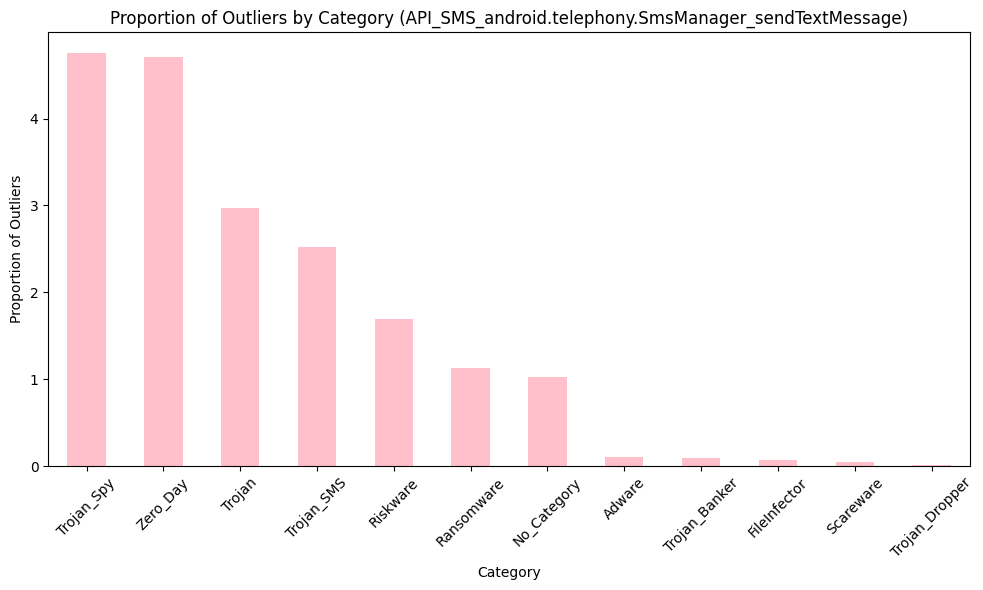


Proportion of outliers by category:
Category
Trojan_Spy        3.706294
No_Category       0.076923
Trojan_SMS        0.048951
Ransomware        0.041958
Trojan            0.027972
Zero_Day          0.006993
Trojan_Dropper    0.006993
Name: count, dtype: float64


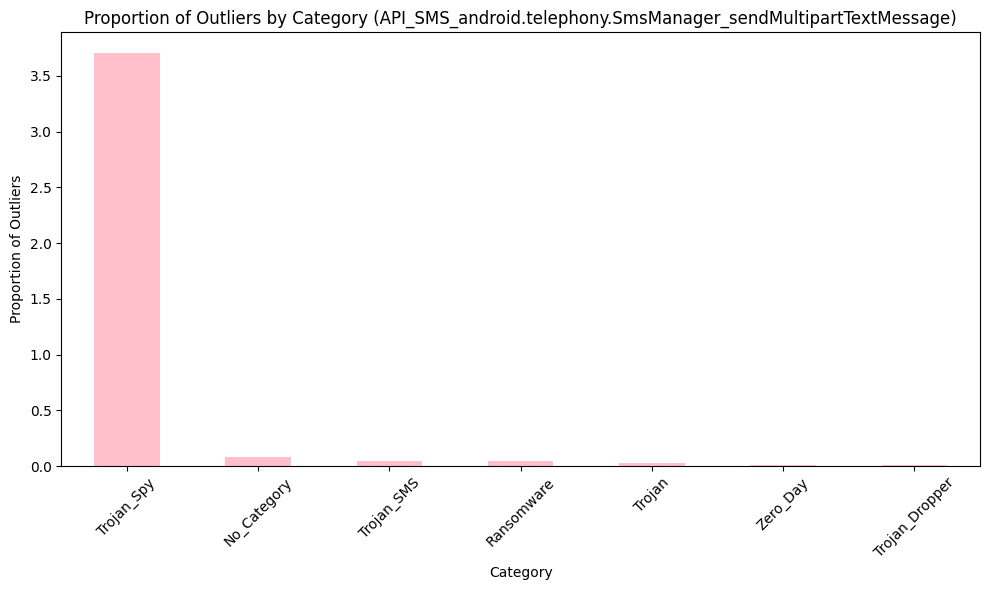

In [ ]:
for feature in sms_features:
    q1 = default_pipeline.dataset.df[feature].quantile(0.25)
    q3 = default_pipeline.dataset.df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = default_pipeline.dataset.df[
        (default_pipeline.dataset.df[feature] < lower_bound) |
        (default_pipeline.dataset.df[feature] > upper_bound)
    ]

    # Proportion of outliers by category
    category_counts = outliers["Category"].value_counts()
    num_features = len(default_pipeline.dataset.df.columns)
    proportion_outliers = (category_counts / num_features).sort_values(ascending=False)

    print("\nProportion of outliers by category:")
    print(proportion_outliers)

    proportion_outliers.plot(kind="bar", color="pink", figsize=(10, 6))
    plt.title(f"Proportion of Outliers by Category ({feature})")
    plt.xlabel("Category")
    plt.ylabel("Proportion of Outliers")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


API_SMS_android.telephony.SmsManager_sendTextMessage: Trojan_Spy and Trojan_SMS are the most prominent categories with outliers. Trojan_Spy shows an extraordinarily high proportion of outliers, with a proportion of 4.755, meaning that a significant number of entries from this category fall outside the normal range for sendTextMessage activity. Ransomware shows a proportion of 1.132, which is lower than Trojans but still notable. The presence of outliers here suggests that while SMS may not be the primary communication method for ransomware, but it is still used in certain attacks.

API_SMS_android.telephony.SmsManager_sendMultipartTextMessage: as we have seen in the analysis, Trojan Spy is the main feature, with 3.71% of all features coming from outliers in this category, over 50× higher than the next category


In [201]:
default_pipeline.dataset.df[sms_features].corr()

,API_SMS_android.telephony.SmsManager_sendTextMessage,API_SMS_android.telephony.SmsManager_sendMultipartTextMessage
API_SMS_android.telephony.SmsManager_sendTextMessage,1.000000,0.048451
API_SMS_android.telephony.SmsManager_sendMultipartTextMessage,0.048451,1.000000


The correlation of 0.048 between sendTextMessage and sendMultipartTextMessage is extremely low, suggesting that there is almost no relationship between these two features. This is important because it indicates that sending regular text messages (SMS) and sending multipart messages (SMS split across multiple parts) are not used interchangeably or concurrently by the same malware or devices in a highly correlated manner.

**Why is Trojan Spy more important than Trojan SMS?????**

In [ ]:
# before and after reboot
default_pipeline.dataset.df.groupby('Reboot')[sms_features].describe()

API_SMS_android.telephony.SmsManager_sendTextMessage            \
                                                      count      mean   
Reboot                                                                  
after                                             25059.0    0.367772   
before                                            28380.0    0.361346   

                                             \
             std  min  25%  50%  75%    max   
Reboot                                        
after   9.183926  0.0  0.0  0.0  0.0  570.0   
before  7.427252  0.0  0.0  0.0  0.0  570.0   

       API_SMS_android.telephony.SmsManager_sendMultipartTextMessage  \
                                                               count   
Reboot                                                                 
after                                             25059.0              
before                                            28380.0              

                                                      
            mean       std  min  25%  50%  75%   max  
Reboot                                                
after   0.006624  0.458202  0.0  0.0  0.0  0.0  54.0  
before  0.040275  0.403872  0.0  0.0  0.0  0.0  36.0

For API_SMS_android.telephony.SmsManager_sendTextMessage, in both scenarios, the mean values are quite close (0.367772 after reboot and 0.361346 before reboot), indicating a relatively consistent level of text message sending regardless of reboot status. However, the standard deviation is notably high (9.183926 after reboot and 7.427252 before reboot), suggesting that while most instances involve few or no text messages, there are occasional spikes with a small number of devices sending a high volume of messages. 

On the other hand, API_SMS_android.telephony.SmsManager_sendMultipartTextMessage the average number of multipart messages sent after a reboot (0.006624) is much lower than before the reboot (0.040275), with the before-reboot mean being more than six times higher. This suggests that multipart messages are relatively rare in both cases, but there is a slight increase in activity before a reboot, which might be linked to malware's attempt to initiate more complex SMS-based communication during the initial stages of device operation.

### Device Data

### Sessions
- Integer
- Definition: refers to a period during which an Android application interacts with an external server or service via an API (Application Programming Interface). An API session typically involves a series of requests and responses exchanged between the app and a remote server or service.


In [204]:
default_pipeline.dataset.df['API__sessions'].describe()

count    53439.000000
mean         6.873482
std          8.345614
min          0.000000
25%          1.000000
50%          2.000000
75%         11.000000
max         80.000000
Name: API__sessions, dtype: float64

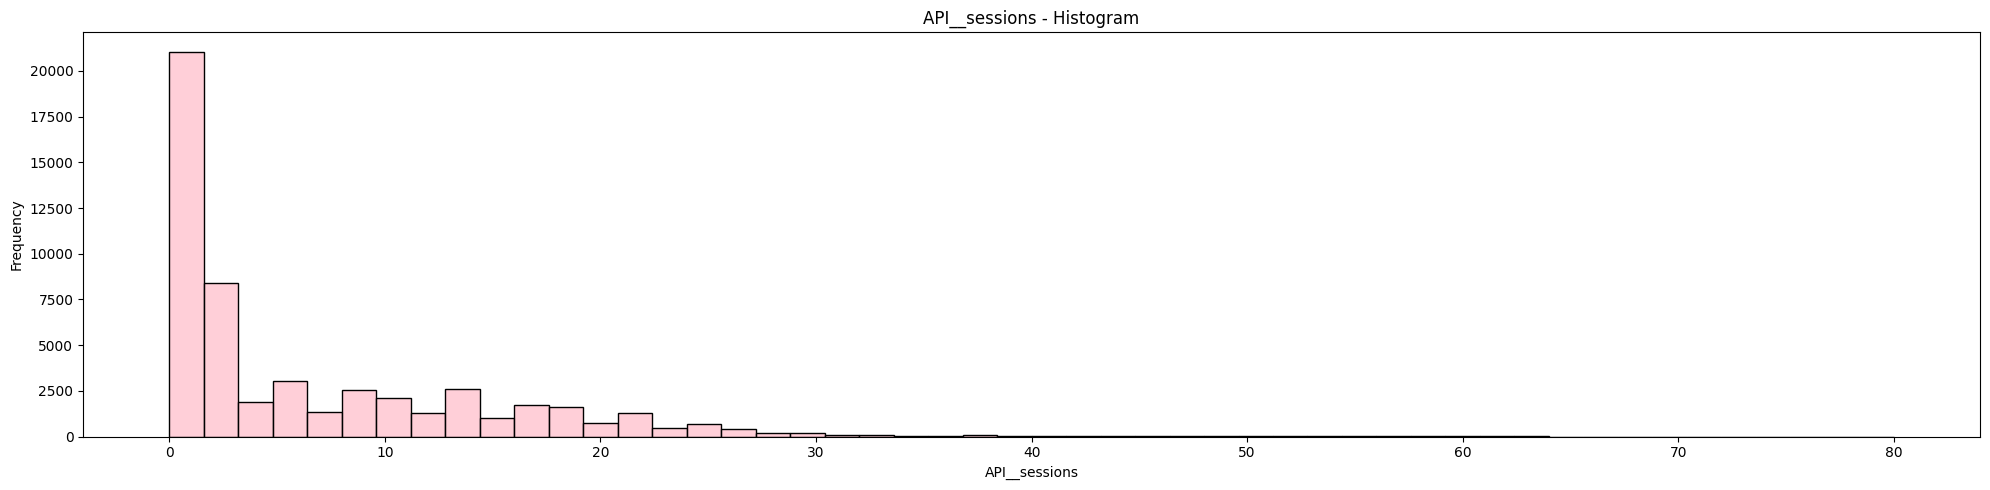

In [206]:
default_pipeline.EDA.plot_histograms(features=['API__sessions'], n_cols=1, bins=50)

Unsurprisingly the data is right-skewed...

In [207]:
default_pipeline.dataset.df.groupby('Category')['API__sessions'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,7.553734,8.058587,0.0,1.0,5.0,12.00,71.0
Backdoor,1137.0,7.675462,8.854320,0.0,1.0,4.0,11.00,38.0
FileInfector,248.0,6.096774,5.249900,0.0,1.0,5.0,10.00,20.0
No_Category,1932.0,5.778468,7.126990,0.0,1.0,2.0,9.00,34.0
PUA,1290.0,8.658915,10.729118,0.0,1.0,1.0,19.75,37.0
Ransomware,3411.0,3.961888,4.443290,0.0,1.0,2.0,6.00,31.0
Riskware,14053.0,10.609123,10.603682,0.0,1.0,8.0,18.00,73.0
Scareware,886.0,8.791196,5.907992,0.0,2.0,11.0,13.00,59.0
Trojan,8437.0,3.877326,4.966412,0.0,1.0,1.0,5.00,80.0


The standard deviation (std) values indicate significant variability in the number of API sessions within most categories. For example, Riskware (10.60) and PUA (10.73) show extremely high variability. These categories often include a mix of benign and malicious behaviors, making their activity patterns more varied. rojan_Spy and Ransomware exhibit low API activity and narrow interquartile ranges, these malware types prioritize avoiding detection over frequent interactions, focusing on specific tasks like data theft or encryption. Riskware (mean = 10.61) and Scareware (mean = 8.79) exhibit the highest average API session counts. These categories are designed to interact heavily with external systems, such as displaying ads, sending notifications, or collecting user data.


API__sessions:
Normalized counts:
Category
Adware            0.986976
Backdoor          0.981530
FileInfector      0.995968
No_Category       0.986542
PUA               0.958140
Ransomware        0.996482
Riskware          0.980004
Scareware         0.993228
Trojan            0.995022
Trojan_Banker     0.904564
Trojan_Dropper    0.992357
Trojan_SMS        0.981434
Trojan_Spy        0.996831
Zero_Day          0.986369
dtype: float64


C:\Users\Cate\AppData\Local\Temp\ipykernel_24024\2161531904.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_data, x="Category", y=feature, palette="RdPu")


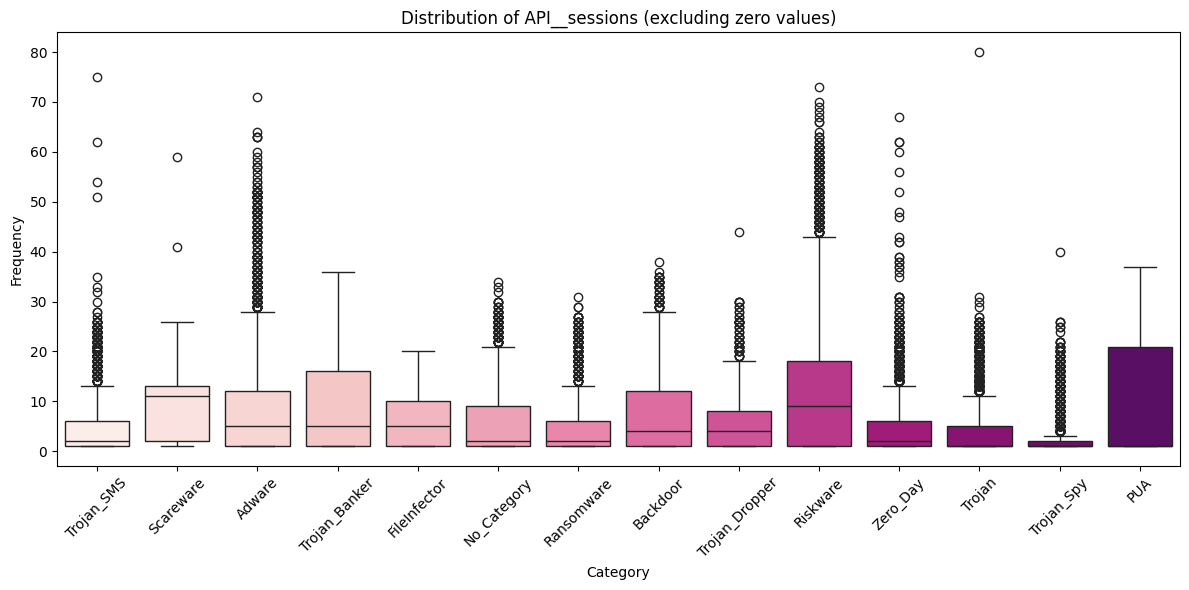

In [208]:
feature = "API__sessions"
print(f"\n{feature}:")
non_zero_counts = (
    default_pipeline.dataset.df[default_pipeline.dataset.df[feature] > 0]
    .groupby("Category")[feature]
    .count()
)
total_counts = default_pipeline.dataset.df["Category"].value_counts()
normalized_counts = non_zero_counts / total_counts
    
# Display the normalized results
print("Normalized counts:")
print(normalized_counts)

filtered_data = default_pipeline.dataset.df[default_pipeline.dataset.df[feature] > 0]
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_data, x="Category", y=feature, palette="RdPu")
plt.title(f"Distribution of {feature} (excluding zero values)")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Most malware categories exhibit high normalized counts, indicating that API interactions are a common characteristic of malware behavior. This aligns with the need for malware to communicate with external servers for data exfiltration, command execution, or payload delivery. 


Proportion of outliers by category:
Category
Riskware          5.398601
Adware            2.062937
PUA               0.839161
Backdoor          0.433566
Zero_Day          0.237762
No_Category       0.202797
Trojan_Dropper    0.076923
Trojan_SMS        0.076923
Ransomware        0.055944
Trojan_Banker     0.048951
Trojan            0.041958
Scareware         0.013986
Trojan_Spy        0.006993
Name: count, dtype: float64


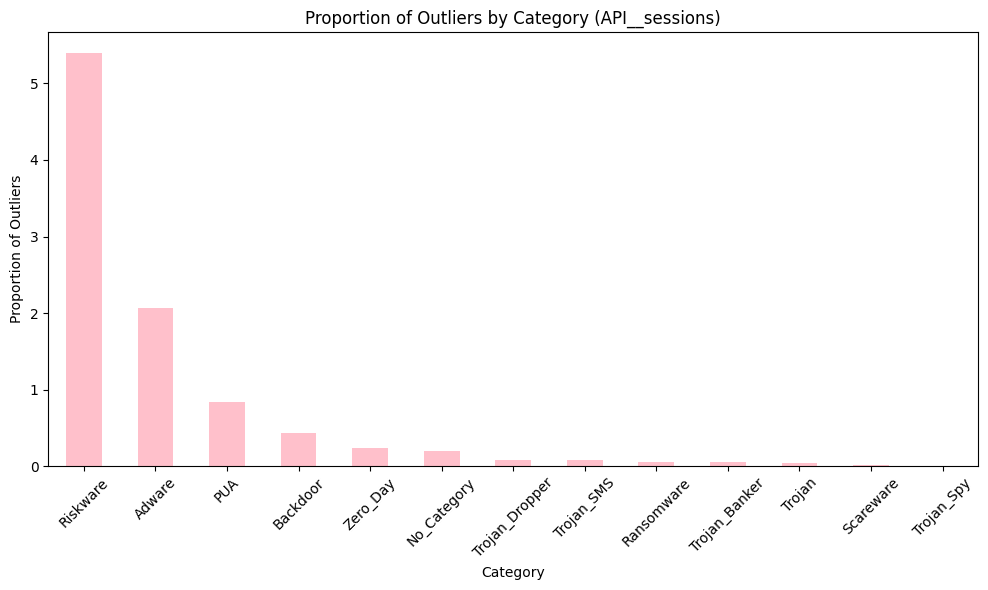

In [209]:
q1 = default_pipeline.dataset.df[feature].quantile(0.25)
q3 = default_pipeline.dataset.df[feature].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = default_pipeline.dataset.df[
        (default_pipeline.dataset.df[feature] < lower_bound) |
        (default_pipeline.dataset.df[feature] > upper_bound)
]

# Proportion of outliers by category
category_counts = outliers["Category"].value_counts()
num_features = len(default_pipeline.dataset.df.columns)
proportion_outliers = (category_counts / num_features).sort_values(ascending=False)

print("\nProportion of outliers by category:")
print(proportion_outliers)

proportion_outliers.plot(kind="bar", color="pink", figsize=(10, 6))
plt.title(f"Proportion of Outliers by Category ({feature})")
plt.xlabel("Category")
plt.ylabel("Proportion of Outliers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Riskware has the biggest proportion of outliers by a significant number, many samples in this category engage in unusually high API session activity. 

In [210]:
default_pipeline.dataset.df.groupby('Reboot')[feature].describe()

,count,mean,std,min,25%,50%,75%,max
Reboot,,,,,,,,
after,25059.0,7.384572,8.746966,0.0,1.0,3.0,12.0,75.0
before,28380.0,6.422199,7.947330,0.0,1.0,2.0,10.0,80.0


## Logcat

- Logcat_verbose: Captures verbose log messages which are the most detailed log level. They offer info such as: method calls, variable values, or debugging details.
- Logcat_debug: Captures debug log messages, these provide information about the app behavior during development or debugging
- Logcat_info: Captures info log messages, these provide information about the general flow of the application or important state changes
- Logcat_warning: Captures warning log messages, these provide information about  potential problems or issues that might not necessarily cause a crash but could lead to undesirable behavior
- Logcat_error: Captures error log messages, these provide information about serious problems or exceptions that prevent an app from functioning as expected 

In [80]:
logcat_features = ['Logcat_verbose', 'Logcat_debug', 'Logcat_info', 'Logcat_warning', 'Logcat_error']

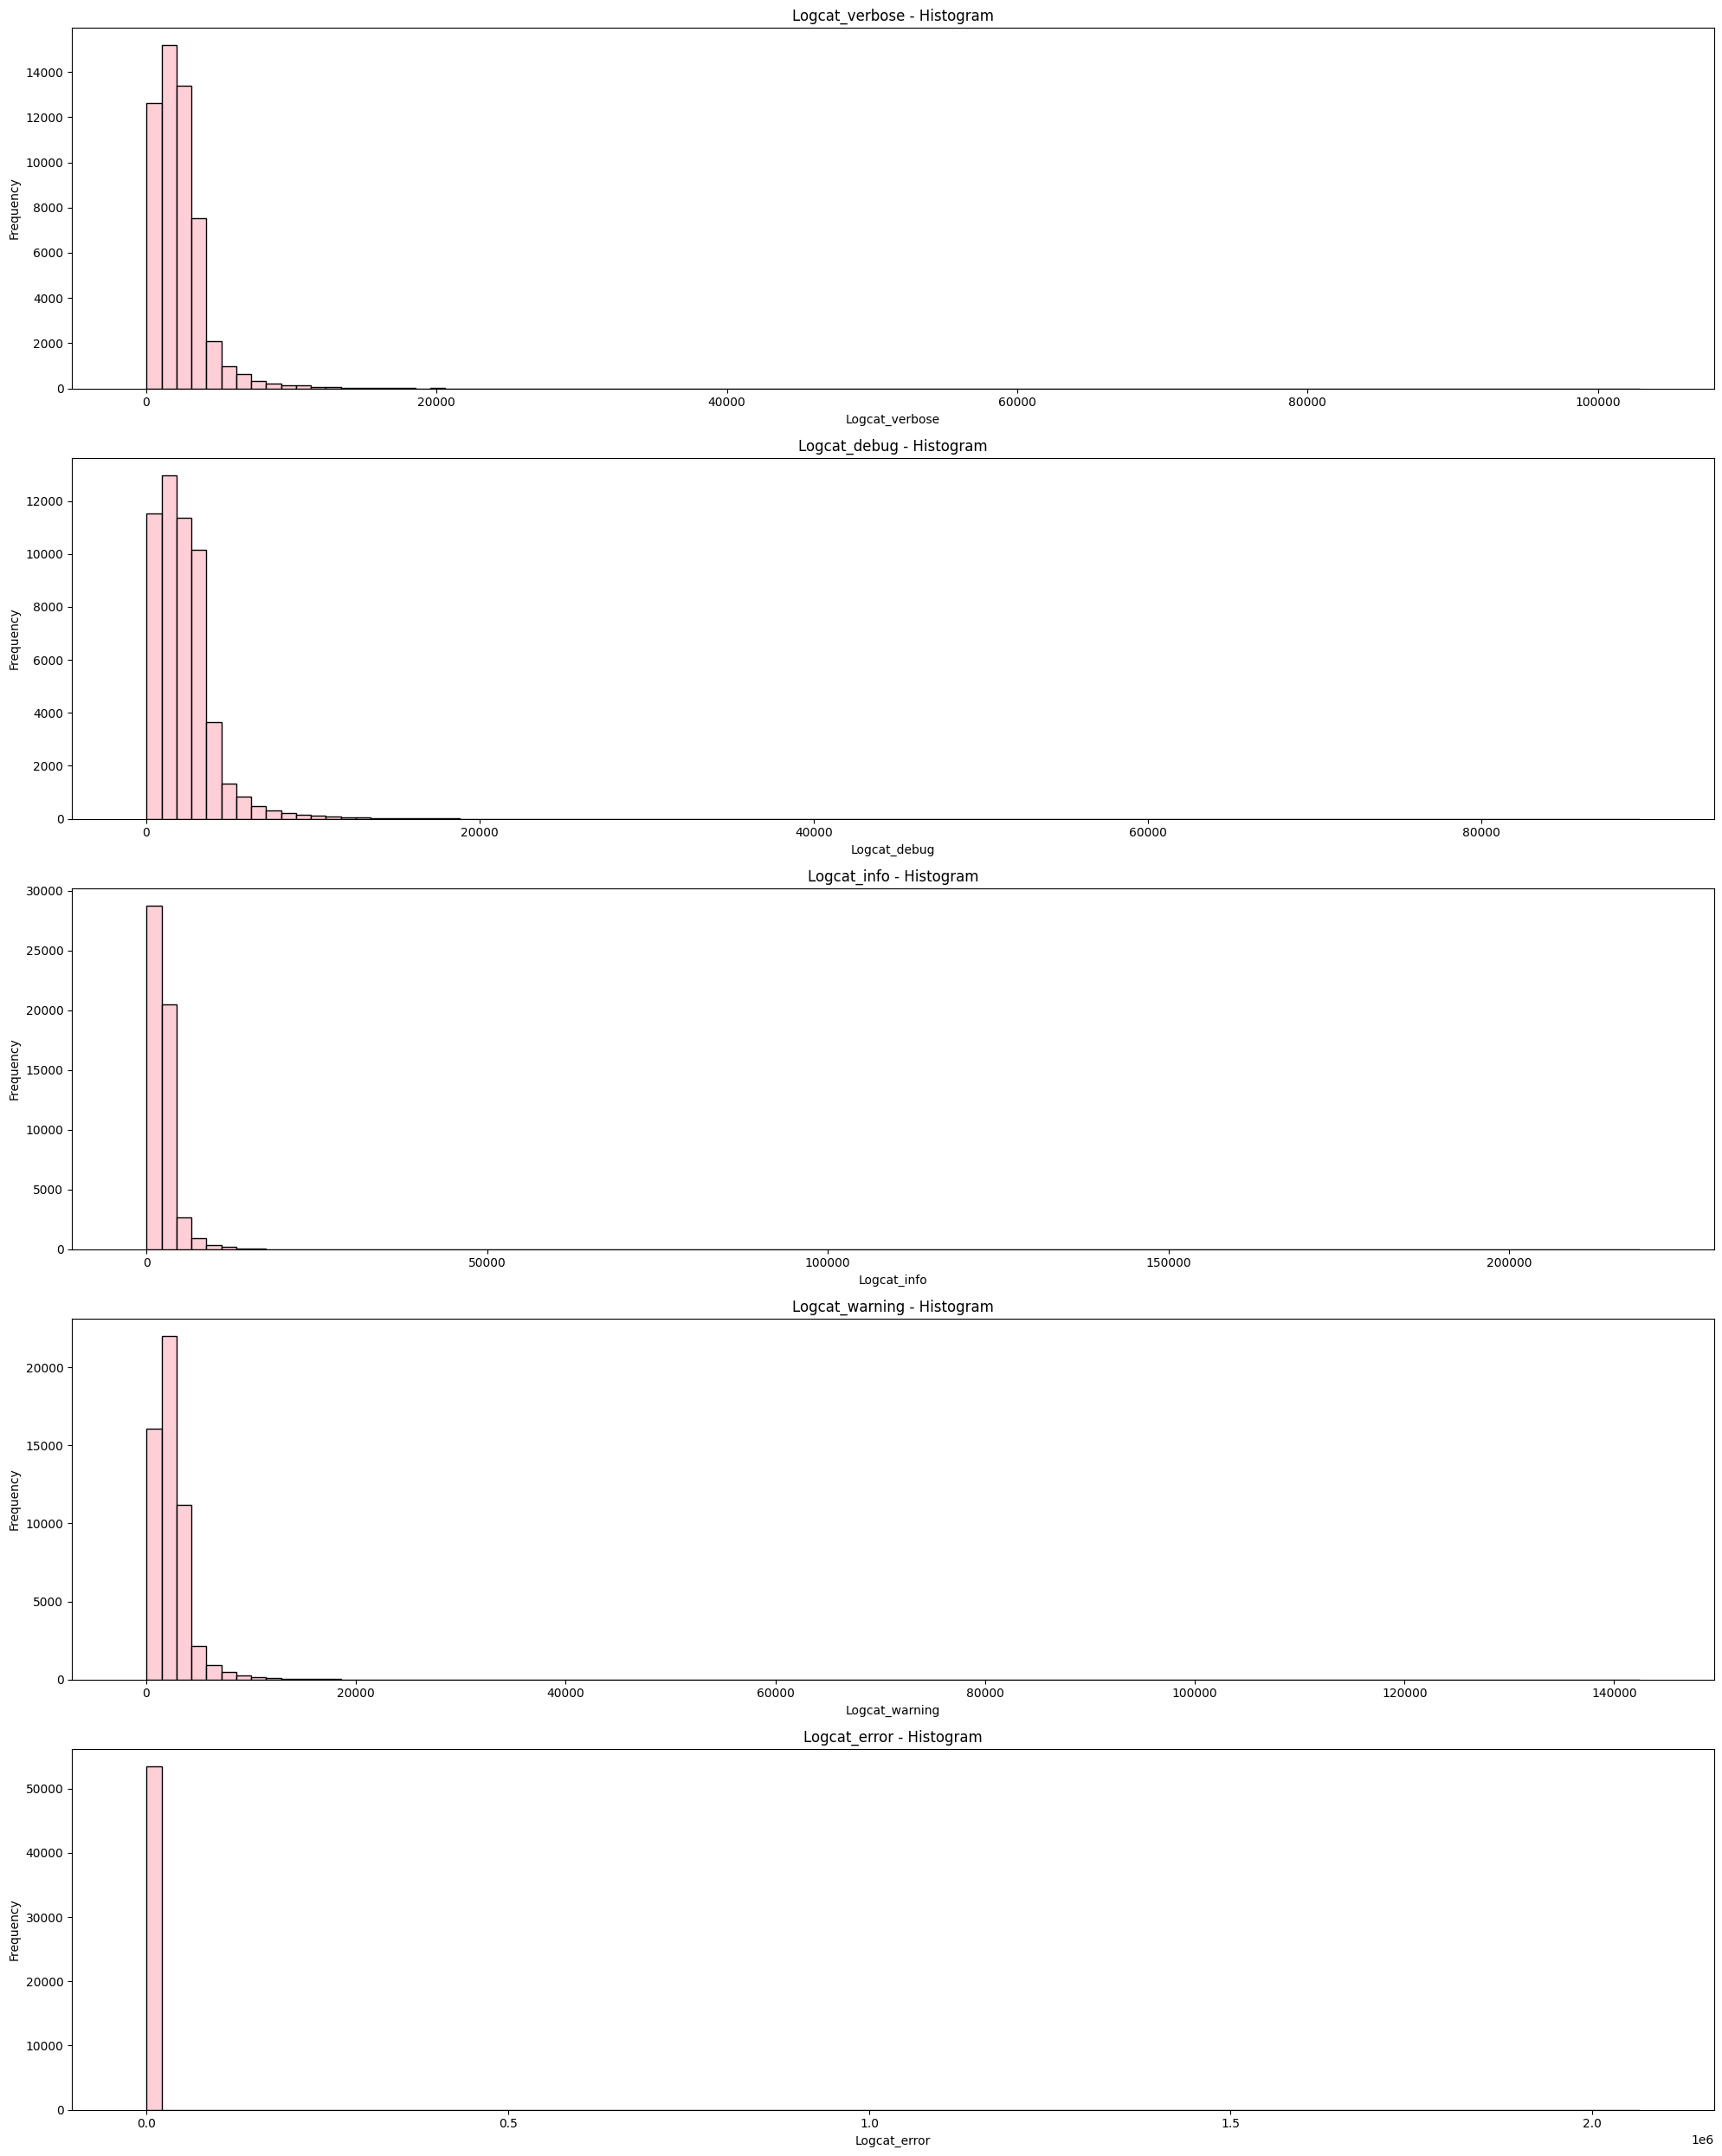

In [81]:
default_pipeline.EDA.plot_histograms(features=logcat_features, n_cols=1, bins=100)

As we can see, most of the logcat features have a really similar distribution with a range in the same order of magnitude. However Logcat error has a significant difference in distribution and in range of the values, some of them being in the millions.

In [82]:
default_pipeline.dataset.df[logcat_features].describe()

,Logcat_verbose,Logcat_debug,Logcat_info,Logcat_warning,Logcat_error
count,53439.000000,53439.000000,53439.000000,53439.000000,5.343900e+04
mean,2297.199629,2299.034825,2342.177717,2298.847845,2.357353e+03
std,1971.010444,2053.110481,2273.059991,2271.006005,9.360781e+03
min,33.000000,40.000000,6.000000,36.000000,4.000000e+01
25%,1137.000000,1099.000000,1155.000000,1108.000000,1.098000e+03
50%,2007.000000,2014.000000,2040.000000,2006.000000,2.021000e+03
75%,3033.000000,3024.000000,3054.000000,3028.000000,3.029000e+03
max,102860.000000,89456.000000,219143.000000,142420.000000,2.066046e+06


On average, info logs are the most frequent, slightly higher than the others, while error logs, despite being the least common, show a significantly higher variability (std = 9360) and a massive maximum value of over 2 million.

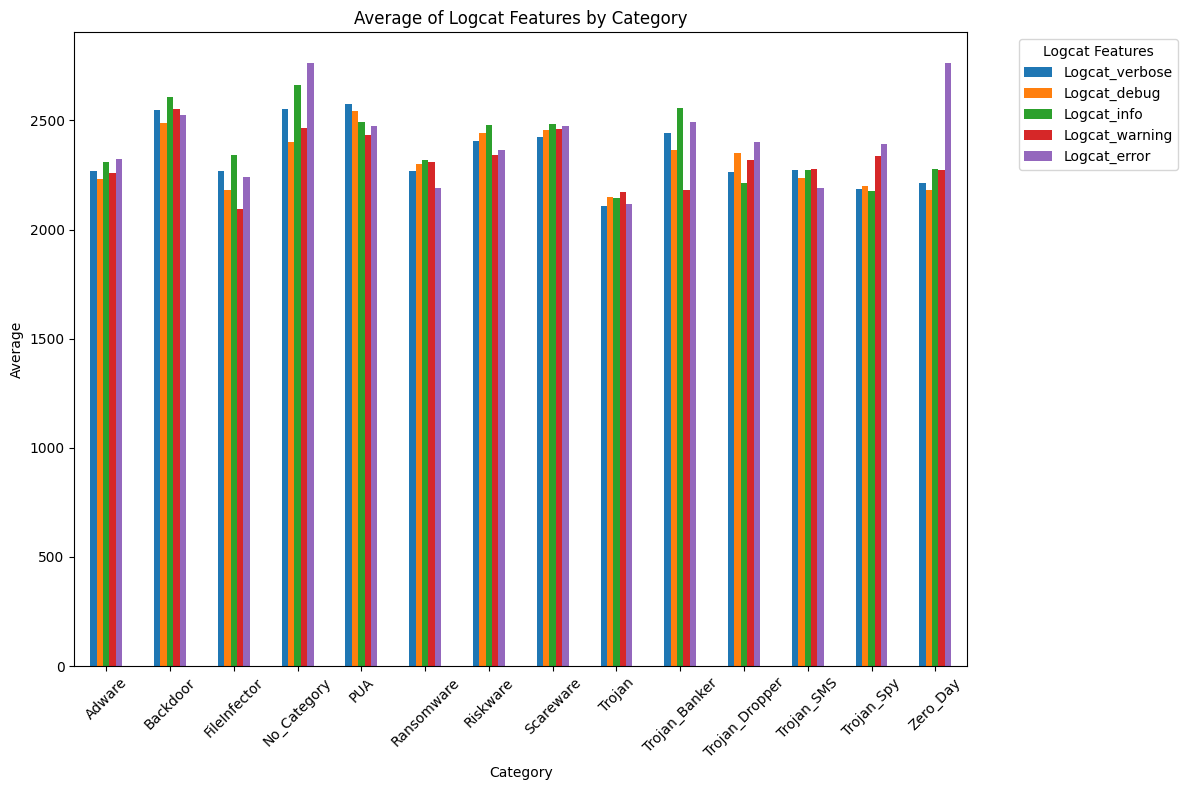

In [83]:
logcat_means = default_pipeline.dataset.df.groupby('Category')[logcat_features].mean()

logcat_means.plot(kind='bar', figsize=(12, 8))

plt.title('Average of Logcat Features by Category')
plt.ylabel('Average')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Logcat Features', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


We observe that the mean values for each logcat feature are fairly consistent within most categories, suggesting similar logging behaviors or patterns across samples in each category. However, two notable exceptions emerge: Trojan_Banker and FileInfector. These categories exhibit significantly lower values for logcat warning and logcat debug messages. These types of malware either suppress logging to evade detection or fail to trigger common system warnings and debug outputs during execution.

Let's analyze further logcat error

In [84]:
default_pipeline.dataset.df['Logcat_error'].describe()


count    5.343900e+04
mean     2.357353e+03
std      9.360781e+03
min      4.000000e+01
25%      1.098000e+03
50%      2.021000e+03
75%      3.029000e+03
max      2.066046e+06
Name: Logcat_error, dtype: float64

This suggests that the majority of cases generate a few thousand errors, but a small number of samples are generating high error values, potentially due to malfunctioning, or heavily misbehaving malware. Let's see which category is making this data spike.

In [85]:
default_pipeline.dataset.df.groupby('Category')['Logcat_error'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Adware,10980.0,2323.503005,3744.194397,43.0,1200.75,2076.0,3048.25,254169.0
Backdoor,1137.0,2526.320141,2223.329975,88.0,928.00,2104.0,3260.00,16254.0
FileInfector,248.0,2239.810484,2013.571744,96.0,920.00,1847.5,2706.00,12018.0
No_Category,1932.0,2765.409420,6121.780936,52.0,1139.75,2039.0,3176.75,178903.0
PUA,1290.0,2474.494574,2057.852247,84.0,1235.00,1935.5,3301.50,21438.0
Ransomware,3411.0,2190.221636,1824.376909,61.0,914.00,1848.0,2853.50,18305.0
Riskware,14053.0,2362.487298,1987.518899,40.0,1126.00,2148.0,3118.00,79353.0
Scareware,886.0,2474.944695,2013.378663,61.0,1218.25,1901.0,3181.25,13162.0
Trojan,8437.0,2117.753585,1809.726742,94.0,894.00,1928.0,2916.00,96606.0


How do the logcat features change before and after the reboot? 

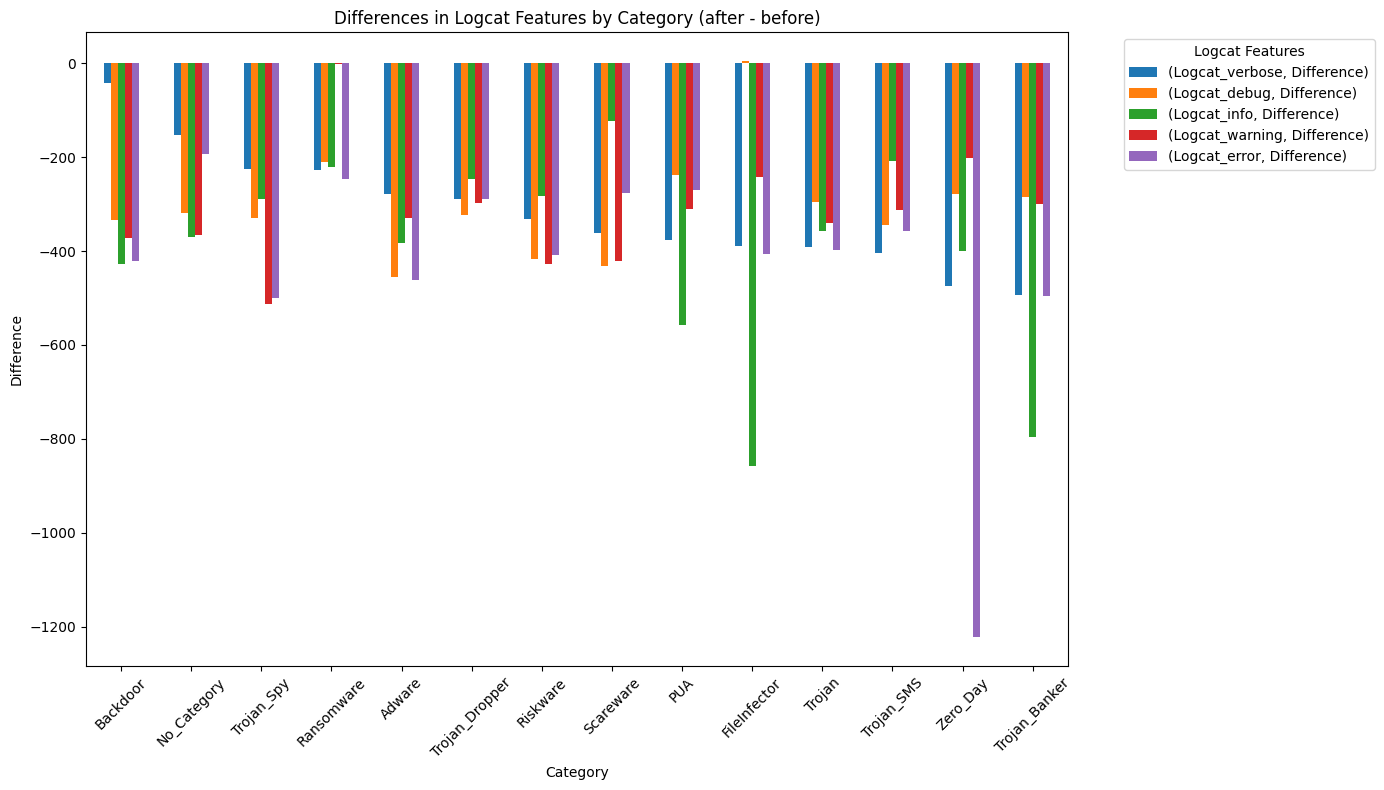

In [86]:
logcat_means = default_pipeline.dataset.df.groupby(['Category', 'Reboot'])[logcat_features].mean().unstack()

for feature in logcat_features:
    logcat_means[(feature, 'Difference')] = logcat_means[(feature, 'after')] - logcat_means[(feature, 'before')]

logcat_means_sorted = logcat_means.sort_values(by=('Logcat_verbose', 'Difference'), ascending=False)

logcat_means_sorted[[('Logcat_verbose', 'Difference'), 
                     ('Logcat_debug', 'Difference'), 
                     ('Logcat_info', 'Difference'), 
                     ('Logcat_warning', 'Difference'), 
                     ('Logcat_error', 'Difference')]].plot(kind='bar', figsize=(14, 8))

plt.title('Differences in Logcat Features by Category (after - before)')
plt.ylabel('Difference')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Logcat Features', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The post-reboot analysis of Logcat logs reveals that, counterintuitively, all malware categories actually habe lower logging activity after reboot. This is particularly evident in categories like PUA, FIle Infector and Trojan_Banker, which show decreases of 600 to 1200 logs on average after reboot. While some malwares are designed to persist or activate only after a reboot, the drop in logs suggests that either the malware becomes more sneaky post-reboot, or that certain initialization behaviors generating logs happen only once during the initial infection phase. 

## Summary Statistics Overview

## Histograms


In [87]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot histograms
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

'# Select only numerical features\nnumerical_cols = dataset.df.select_dtypes(include=[np.number]).columns\n\n# Define number of rows and columns for subplots\nnum_features = len(numerical_cols)\ncols = 4  # Number of columns per row\nrows = math.ceil(num_features / cols)  # Calculate required rows\n\n# Create subplots\nfig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))\naxes = axes.flatten()  # Flatten to easily iterate\n\n# Plot histograms\nfor i, col in enumerate(numerical_cols):\n    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # kde=True for smooth curve\n    axes[i].set_title(col)\n\n# Remove empty subplots\nfor i in range(num_features, len(axes)):\n    fig.delaxes(axes[i])\n\nplt.tight_layout()\nplt.show()'

We can see most distributions tend to be right-skewed and only a small portion follows a normal distribution. This right-skewness will be dealt in feature-engineering.

In [88]:
"""# Select only numerical features
numerical_cols = dataset.df.select_dtypes(include=[np.number]).columns

# Define number of rows and columns for subplots
num_features = len(numerical_cols)
cols = 4  # Number of columns per row
rows = math.ceil(num_features / cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
axes = axes.flatten()  # Flatten to easily iterate

# Plot boxplots
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature
    axes[i].set_title(col)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()"""

'# Select only numerical features\nnumerical_cols = dataset.df.select_dtypes(include=[np.number]).columns\n\n# Define number of rows and columns for subplots\nnum_features = len(numerical_cols)\ncols = 4  # Number of columns per row\nrows = math.ceil(num_features / cols)  # Calculate required rows\n\n# Create subplots\nfig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))\naxes = axes.flatten()  # Flatten to easily iterate\n\n# Plot boxplots\nfor i, col in enumerate(numerical_cols):\n    sns.boxplot(x=dataset.df[col], ax=axes[i])  # Boxplot for each feature\n    axes[i].set_title(col)\n\n# Remove empty subplots\nfor i in range(num_features, len(axes)):\n    fig.delaxes(axes[i])\n\nplt.tight_layout()\nplt.show()'

## Numerical Features

Seemed to be grouped by prefixes: Memory, Network, Battery, Logcat, Process y API.

According to dataset authors to capture how various malware families and categories behave at runtime, the analysis relies on six distinct sets of features obtained after executing each sample within a controlled emulated environment. These feature groups offer a comprehensive view of the malware's dynamic activity.

This categories appear before the first _ in every feature label and are defined as:


"Memory: Memory features define activities performed by malware by utilizing memory.

API: Application Programming Interface (API) features delineate the communication between two applications.

Network: Network features describe the data transmitted and received between other devices in the network. It indicates foreground and background network usage.

Battery: Battery features describe the access to battery wakelock and services by malware.

Logcat: Logcat features write log messages corresponding to a function performed by malware.

Process: Process features count the interaction of malware with total number of processes."



In [89]:
"""numeric_cols = dataset.df.select_dtypes(include='number').columns

# Grouping based on the first prefix before "_"
prefix_groups = defaultdict(list)

for col in numeric_cols:
    prefix = col.split("_")[0]  # Get the first word before the underscore
    prefix_groups[prefix].append(col)

for prefix, columns in prefix_groups.items():
    print(f"\n {prefix} ({len(columns)} features):")
    for col in columns:
        print(f"  - {col}")"""

'numeric_cols = dataset.df.select_dtypes(include=\'number\').columns\n\n# Grouping based on the first prefix before "_"\nprefix_groups = defaultdict(list)\n\nfor col in numeric_cols:\n    prefix = col.split("_")[0]  # Get the first word before the underscore\n    prefix_groups[prefix].append(col)\n\nfor prefix, columns in prefix_groups.items():\n    print(f"\n {prefix} ({len(columns)} features):")\n    for col in columns:\n        print(f"  - {col}")'

## Categorical Features

In [90]:
"""#Statistical summary for categorical features
dataset.df.describe(include=["object", "category", "bool"])"""

'#Statistical summary for categorical features\ndataset.df.describe(include=["object", "category", "bool"])'

In [91]:
"""print(dataset.df[['Hash', 'Category', 'Family']].head())"""

"print(dataset.df[['Hash', 'Category', 'Family']].head())"

Hash: unique identifier that represents each malware sample. <<<>>>THIS IS PROBABLY WRONG<<<>>>

Category: general classification of the malware sample based on its behavior.

Family: more fine-grained grouping of malware based on its codebase or origin

For hash, it will first be checked if the same malware before and after reboot contains the same hash value.

In [92]:
"""# Count how many times each hash appears in 'before' and 'after'
hash_reboot_counts =dataset.df.groupby(['Hash', 'reboot']).size().unstack(fill_value=0)

# Hashes in both with exactly one in each
hashes_with_one_each = hash_reboot_counts[
    (hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1)
].index

# Hashes in both but with extra rows
hashes_in_both_but_not_clean = hash_reboot_counts[
    (hash_reboot_counts['before'] > 0) &
    (hash_reboot_counts['after'] > 0) &
    ~((hash_reboot_counts['before'] == 1) & (hash_reboot_counts['after'] == 1))
].index

# Total unique hashes
total_unique_hashes = dataset.df['Hash'].nunique()

# Hashes in only one reboot condition
hashes_in_one_condition = hash_reboot_counts[
    (hash_reboot_counts['before'] == 0) | (hash_reboot_counts['after'] == 0)
]

# Only once in one reboot condition
only_once_in_one = hashes_in_one_condition[
    (hashes_in_one_condition['before'] == 1) | (hashes_in_one_condition['after'] == 1)
]

# More than once in one reboot condition
more_than_once_in_one = hashes_in_one_condition[
    ((hashes_in_one_condition['before'] > 1) & (hashes_in_one_condition['after'] == 0)) |
    ((hashes_in_one_condition['after'] > 1) & (hashes_in_one_condition['before'] == 0))
]

# Split those into counts
more_than_once_in_before = more_than_once_in_one[more_than_once_in_one['before'] > 1]
more_than_once_in_after = more_than_once_in_one[more_than_once_in_one['after'] > 1]

# --- PRINT RESULTS ---
print(f"Hashes with EXACTLY one row in BOTH before and after: {len(hashes_with_one_each)}")
print(f"Hashes in BOTH, BUT with extra rows: {len(hashes_in_both_but_not_clean)}")

print(f"\nHashes in ONLY ONE reboot condition:")
print(f"• Appearing ONLY ONCE: {len(only_once_in_one)}")
print(f"• Appearing MORE THAN ONCE: {len(more_than_once_in_one)}")
print(f"   - More than once in BEFORE: {len(more_than_once_in_before)}")
print(f"   - More than once in AFTER: {len(more_than_once_in_after)}")

print(f"\nTotal breakdown:")
print(f"• In BOTH (any): {len(hashes_with_one_each) + len(hashes_in_both_but_not_clean)}")
print(f"• In ONLY ONE reboot: {len(hashes_in_one_condition)}")
print(f"• TOTAL unique hashes: {total_unique_hashes}")
"""

'# Count how many times each hash appears in \'before\' and \'after\'\nhash_reboot_counts =dataset.df.groupby([\'Hash\', \'reboot\']).size().unstack(fill_value=0)\n\n# Hashes in both with exactly one in each\nhashes_with_one_each = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] == 1) & (hash_reboot_counts[\'after\'] == 1)\n].index\n\n# Hashes in both but with extra rows\nhashes_in_both_but_not_clean = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] > 0) &\n    (hash_reboot_counts[\'after\'] > 0) &\n    ~((hash_reboot_counts[\'before\'] == 1) & (hash_reboot_counts[\'after\'] == 1))\n].index\n\n# Total unique hashes\ntotal_unique_hashes = dataset.df[\'Hash\'].nunique()\n\n# Hashes in only one reboot condition\nhashes_in_one_condition = hash_reboot_counts[\n    (hash_reboot_counts[\'before\'] == 0) | (hash_reboot_counts[\'after\'] == 0)\n]\n\n# Only once in one reboot condition\nonly_once_in_one = hashes_in_one_condition[\n    (hashes_in_one_condition[\'before\'] == 1) 

A total of 19,169 hashes appear exactly once in both before and after conditions. These are highly reliable for paired  comparisons, ideal for understanding how reboot affects malware behavior.


There are 158 hashes that appear in both reboot states but not exactly once in each. These extra instances may come from inconsistencies in data capture like multiple logs for the same sample and should be checked.

A significant portion of samples appear only in one reboot condition. This is consistent with limitations described in the original dataset paper, where some malware samples failed to execute after the reboot. However, what is curious is that some still have been logged more than once.


In [93]:
"""dataset.df.drop(columns=['Hash'], inplace=True)
'''
The Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.
It serves as an identifier for each malware sample. Including this column in modeling
would not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are
sensitive to high-cardinality categorical features.
 <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the 
  argumentation in a text cell not in this type of comments. <<<>>>
'''"""

"dataset.df.drop(columns=['Hash'], inplace=True)\n'''\nThe Hash column is a high-cardinality feature, containing unique values for a high number of rows in the dataset.\nIt serves as an identifier for each malware sample. Including this column in modeling\nwould not only offer no predictive value but could also lead to overfitting or cause issues with algorithms that are\nsensitive to high-cardinality categorical features.\n <<<>>> J.N: may be better to focus the argumentation on ID not being useful rather than high-cardinality per se. Also write the \n  argumentation in a text cell not in this type of comments. <<<>>>\n'''"

This research will be using both Category and Family as the target variables for classification.

## Reboot Analysis

In [94]:
"""print(dataset.df["reboot"].value_counts())"""

'print(dataset.df["reboot"].value_counts())'

The imbalance observed in the dataset, with 28,380 samples collected before reboot and only 25,059 after reboot, is explained by limitations found during the dynamic analysis. The authors of the dataset note that "there was no entry point in some Android malware samples and some Android malware samples stopped abruptly." This means that certain malware applications either failed to launch or terminated unexpectedly during execution, preventing the collection of dynamic behavior data, particularly after the reboot phase.

Additionally, the study highlights another critical limitation: "the dynamic analysis is performed in an emulator. Some malware samples are able to detect the emulated environment and are not executed." This behavior reflects common anti-analysis techniques used by sophisticated malware, which can detect when they are running in a sandbox or emulator and intentionally suspend their malicious actions.




<<<>>>THIS ANALYSIS IS SUPER GOOD (you can delete this comment)<<<>>>

The displayed features are the top 10  most affected by reboot showing a clear reboot-sensitive behavior.

In [95]:
"""#Category distribution across reboot
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset.df, x='Category', hue='reboot')
plt.title("Malware Categories by Reboot Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()"""


'#Category distribution across reboot\nplt.figure(figsize=(12, 6))\nsns.countplot(data=dataset.df, x=\'Category\', hue=\'reboot\')\nplt.title("Malware Categories by Reboot Condition")\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()'

To identify which numeric features are most influenced by the reboot condition, the dataset will be grouped by the reboot variable, separating entries collected before and after the device reboot. Within each group, the mean of every numeric feature will be computed, allowing for the comparison of average behavior across both states.

A new column labeled 'diff' was then added, representing the difference between the mean values after and before the reboot for each feature. A positive value indicates that the feature increased after reboot, while a negative value shows it decreased.

In [96]:
"""reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T
reboot_means['diff'] = reboot_means['after'] - reboot_means['before']
reboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)

reboot_means_sorted.head(10)"""

"reboot_means = dataset.df.groupby('reboot').mean(numeric_only=True).T\nreboot_means['diff'] = reboot_means['after'] - reboot_means['before']\nreboot_means_sorted = reboot_means.sort_values(by='diff', ascending=False)\n\nreboot_means_sorted.head(10)"

The results reveal that several features show clear shifts after reboot. Specially, network-related features such as Network_TotalReceivedBytes and Network_TotalTransmittedBytes demonstrate significant increases, suggesting that some malware types intensify data transmission once the device has rebooted. Memory features like Memory_SharedClean, Memory_HeapSize, and Memory_HeapAlloc also show increased values after reboot, indicating greater memory use or altered memory management after reboot.
This shows that the reboot condition plays an important role in runtime behavior and should be treated as an important factor in exploratory analysis and modeling.

Ranking of categories with the greatest change after reboot:
Category
Trojan             578.726641
Adware             327.743903
Trojan_Spy         105.269549
No_Category         50.918777
Ransomware          36.761889
Scareware            4.452183
Trojan_SMS         -12.413125
Trojan_Dropper     -34.343986
Riskware           -37.602201
FileInfector       -39.688572
Trojan_Banker      -97.602385
Backdoor          -181.516775
Zero_Day          -258.774379
PUA              -2295.648788
dtype: float64


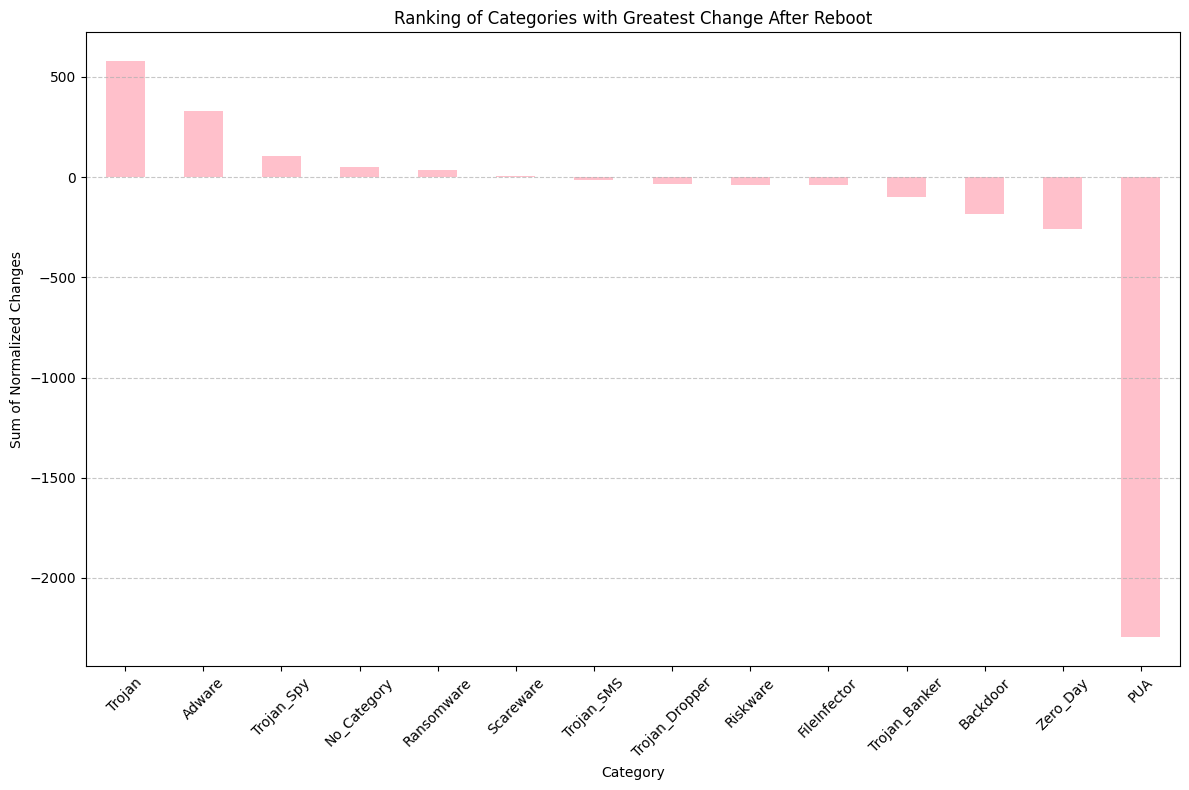

In [97]:
category_means = default_pipeline.dataset.df.groupby(['Category', 'Reboot']).mean(numeric_only=True).unstack()

after_values = category_means.xs('after', level=1, axis=1)
before_values = category_means.xs('before', level=1, axis=1)
category_differences = after_values - before_values

feature_medians = {}
for column in default_pipeline.dataset.df.select_dtypes(include=['number']).columns:
    feature_medians[column] = default_pipeline.dataset.df[column].median()

category_differences_normalized = category_differences.copy()
for column in category_differences.columns:
    if feature_medians[column] != 0:
        category_differences_normalized[column] = category_differences[column] / feature_medians[column]

category_change_ranking = category_differences_normalized.sum(axis=1).sort_values(ascending=False)

print("Ranking of categories with the greatest change after reboot:")
print(category_change_ranking)

plt.figure(figsize=(12, 8))
category_change_ranking.plot(kind='bar', color='pink')
plt.title('Ranking of Categories with Greatest Change After Reboot')
plt.ylabel('Sum of Normalized Changes')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Family

In [98]:
"""#How many categories each family belongs to
dataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)"""

'#How many categories each family belongs to\ndataset.df.groupby("Family")["Category"].nunique().sort_values(ascending=False)'

Almost every family is either unknown or unique


In [99]:
# <<<Error: NameError: name 'family_to_category' is not defined>>> (this Irina's code; copied from Argentinan guy's notebook)
# multi_cat_families = family_to_category[family_to_category > 1]
# print(f"Number of families mapping to multiple categories: {len(multi_cat_families)}")
# print(multi_cat_families)

There is only one Family that maps to multiple categories, and is the placeholder unknown.

The following code displays how many samples with unknown family labels belong to each malware category.

In [100]:
"""dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()"""

'dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()'

In [101]:
"""# Step 1: Count unique families per category
family_amount = dataset.df.groupby("Category")["Family"].nunique()

# Step 2: Total number of instances per category
total_per_category = dataset.df["Category"].value_counts()

# Step 3: Count how many of those are <unknown> per category
unknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()

# Step 4: Combine all stats into a summary table
summary_df = pd.DataFrame({
    "Family_amount": family_amount,
    "Total_category": total_per_category,
    "Unknown_amount": unknown_amount
}).fillna(0).astype({"Unknown_amount": int})

# Step 5: Calculate percentage of unknowns per category
summary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)

# Reorder columns for readability
summary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]

# Display the summary
print(summary_df)"""

'# Step 1: Count unique families per category\nfamily_amount = dataset.df.groupby("Category")["Family"].nunique()\n\n# Step 2: Total number of instances per category\ntotal_per_category = dataset.df["Category"].value_counts()\n\n# Step 3: Count how many of those are <unknown> per category\nunknown_amount = dataset.df[dataset.df["Family"] == "<unknown>"]["Category"].value_counts()\n\n# Step 4: Combine all stats into a summary table\nsummary_df = pd.DataFrame({\n    "Family_amount": family_amount,\n    "Total_category": total_per_category,\n    "Unknown_amount": unknown_amount\n}).fillna(0).astype({"Unknown_amount": int})\n\n# Step 5: Calculate percentage of unknowns per category\nsummary_df["%_Unknown"] = (summary_df["Unknown_amount"] / summary_df["Total_category"] * 100).round(2)\n\n# Reorder columns for readability\nsummary_df = summary_df[["Family_amount", "Total_category", "Unknown_amount", "%_Unknown"]]\n\n# Display the summary\nprint(summary_df)'

In [102]:
"""unknown_count = (dataset.df["Family"] == "<unknown>").sum()
print(f"Number of rows with Family == '<unknown>': {unknown_count}")"""


'unknown_count = (dataset.df["Family"] == "<unknown>").sum()\nprint(f"Number of rows with Family == \'<unknown>\': {unknown_count}")'

Based on the analysis of family distribution across categories:

The Adware category stands out with zero instances labeled as <unknown> and a balanced distribution across 43 families. This makes it a strong candidate for modeling.

In contrast, Zero_Day and No_Category The categories Zero_Day and No_Category exhibit extremely high family dispersion, with 2576 and 335 unique families. These values are significantly higher than all other categories, which generally have fewer than 50 families each.


This suggests they function more as placeholder labels. In particular, Zero_Day likely serves as a catch-all label for unknown or uncategorized threats, making it ambiguous. In cybersecurity, this term is refered to a new unknown vulnerability, not yet classified in terms of malware behavior, this is why samples are varied. They do not seem to represent a consistent type. On the other hand, No_Category explicitly denotes a lack of category. So, including these instances would only bring noise to the training process, preventing the model from learning meaningful patterns.
Therefore, they are excluded from the final dataset to preserve the quality and consistency of the classification task.


Additionally, categories like FileInfector show a high percentage of <unknown> families (6.85%) despite having a small total count, raising concerns about label quality. Most other categories maintain a relatively stable level of unknowns (around 3–5%), indicating that the presence of <unknown> is manageable.

<hr>

# 2. DATA SPLITTING
### TO BE DONE
- Statistical analysis of this
- Make sure they follow the same distributions

### Data Splitting: Category as target variable
Originally, we will focus only on category

Lets first get the X and y extracted from our dataset

Also object!
Lets get back to the splitting!

Before, we split the dataset lets observe the SE of accuracy variation based on our choice of split. 
Brief explanation: we can model accuracy via a Binomial distribution. We know each event in a binomial distribution can be modelled through a bernoulli distribution, where the outcome represents the probability predicting the correct class or not. We make the assumption that each classification error is independent from each other. For:
$$
\text{Bin} \sim (n, p)
$$
 let us assume that the parameter of this distribution is p = .85 and n is given by the choice of sample split for the test set. The SE of the sample proportion can be modeled via: 
$$
\text{SE}_{\hat{p}} = \sqrt{\frac{p(1 - p)}{n}}

$$

Before we continue to assess all possible choices of split based on a variant n, also note that that choice of evenly distributed split (e.g: 10% for each hold-out set) between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.

Finally, also note that that choice of evenly distributed split between hold-out sets is arbitrary. Proper choice is that which guarantees an equivalent distribution at each hold-out sets, which may not neccesarily be the equivalent split. This brings a new choice of tradeoff between certainity of prediction accuracy (higher test size, smaller validaiton set) but possibly less space for proper hyperparemter optimization or the inverse (higher validation size, smaller set set). As with other tradeoffs, the priority for a given option is rooted in the model's application (which may come derived from a client/employer). For our case, we dont favor either option of the tradeoof, thus we will keep the even hold-out distribution.


c:\Users\Cate\OneDrive - IE University\CSAI 4\ML\Final Project ML\FInal project ML\library\phases\dataset\split\strategies\noTimeSeries.py:112: RuntimeWarning: divide by zero encountered in scalar divide
  differenceToPriorSE_percentage = (currentSE - priorSE) /  priorSE


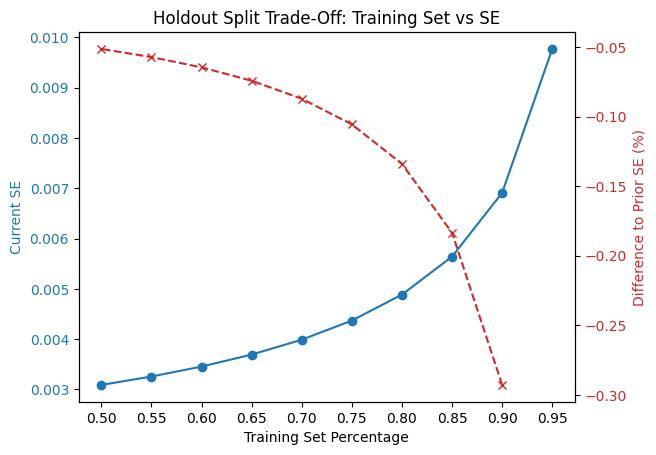

,train_size (%),train_size_count,validation_size (%),validation_size_count,test_size (%),test_size_coount,currentSE,differenceToPriorSE,differenceToPriorSE (%)
0,0.95,50767.0,0.025,1336.0,0.025,1336.0,0.009769,0.009769,inf
1,0.90,48095.0,0.050,2672.0,0.050,2672.0,0.006908,-0.002861,-0.292893
2,0.85,45423.0,0.075,4008.0,0.075,4008.0,0.005640,-0.001268,-0.183503
3,0.80,42751.0,0.100,5344.0,0.100,5344.0,0.004885,-0.000756,-0.133975
4,0.75,40079.0,0.125,6680.0,0.125,6680.0,0.004369,-0.000516,-0.105573
5,0.70,37407.0,0.150,8016.0,0.150,8016.0,0.003988,-0.000381,-0.087129
6,0.65,34735.0,0.175,9352.0,0.175,9352.0,0.003692,-0.000296,-0.074180
7,0.60,32063.0,0.200,10688.0,0.200,10688.0,0.003454,-0.000238,-0.064586
8,0.55,29391.0,0.225,12024.0,0.225,12024.0,0.003256,-0.000198,-0.057191
9,0.50,26720.0,0.250,13360.0,0.250,13360.0,0.003089,-0.000167,-0.051317


In [103]:
default_pipeline.dataset.split.asses_split_classifier(p=.85, step=.05, plot=True)

[We can see a diminishing-returns class graph](https://en.wikipedia.org/wiki/Knee_of_a_curve). The more we decline the training set percentage the slower and more steadier the current SE varies as well as the difference to prior SE, in percentage. We can see that the knee in the curve is between 80 and 90 training set percentage. This represents the area where when you start going below the lower bound, no **significant** improve appears. Given the fact that our criteria for choice of split percentage is to keep as much training possible while increasing hold-out sets size only if the decrease in SE is significant **we are going to select 80% for the training set**.

In [104]:
default_pipeline.dataset.split.split_data(y_column="Category",
                                   train_size=.8, 
                                   validation_size=.1,
                                   test_size=.1, 
                                   plot_distribution=False)

In [105]:
default_pipeline.dataset.X_train.shape, default_pipeline.dataset.X_val.shape, default_pipeline.dataset.X_test.shape, default_pipeline.dataset.y_train.shape, default_pipeline.dataset.y_val.shape, default_pipeline.dataset.y_test.shape

((42751, 142), (5344, 142), (5344, 142), (42751,), (5344,), (5344,))

<hr>

# 3. DATA PREPROCESSING

### Feature Scaling

We will work only with the training set to avoid data leakage.

In [106]:
#dataset.X_train

We eliminate the field `Reboot_before` since it is boolean.

In [107]:
# preprocessor.remove_reboot_column()
# preprocessor.X_train_without_reboot

In [108]:
# preprocessor.X_train_without_reboot.describe().T[['min', 'max']]

Secondly, we're gonna check for kurtosis and skewness. If skewness is high we might need to consider standardizing.

In [109]:
# print(f"\nSkewness:\n----------------\n{preprocessor.X_train_without_reboot.skew()}")
# print(f"\nKurtosis:\n----------------\n{preprocessor.X_train_without_reboot.kurt()}")

Since there is a very large number of fields, we need to avoid looking at the distribution and information about each feature. For this, we decided to create an automation that decides the appropriate scaling method -if necessary- for each feature.

This function `determine_scaling_method` takes into account outlier detection and skewness and based on that it decides to use a **robust scaler**, **normalize** or **none**.

**Note**: we use robust scaler rather than a standard scaler because robust scales with the median and IQR, which is less sensitive to outliers than standardizing is -computed with $\mu$ and $\sigma$. It will turn the median to 0 and turn the values in a field in values between -1 and 1 with some outliers.

Normalization Formula:
 

Robust Scaler Formula:
 
Where:

IQR (Interquartile Range) = Q3 - Q1

In [110]:
# preprocessor.prepare_scaling()

In [111]:
# X_train_scaled = preprocessor.apply_scaling()

# "\nRobust complete! The training data is now ready for modeling."

In [112]:
# X_train_scaled

The histograms show how `RobustScaler` compresses extreme values and brings the bulk of the data closer to a common scale. Despite the presence of outliers, the core distribution becomes more uniform and comparable across features — ideal for many ML models.

This section below shall be properly written. It is set now for early debugging

## !> Pipeline example
Let us show an example of the pipeline divergence. We will create a divergence for the baseline pipeline. We will exempt it from being scaled. This specific example is not meant to be kept, but rather show the purpose of the corresponding functions.

In [113]:
baseline_pipeline = pipeline_manager.create_pipeline_divergence(category="baseline", pipelineName="logistic")

In [114]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


In [115]:
default_pipeline.preprocessing.scale_features(scaler="robust",
                                      columnsToScale=default_pipeline.dataset.X_train.select_dtypes(include=["number"]).columns)

In [116]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [117]:
default_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000
mean,0.212761,0.398628,0.186851,0.265664,-0.069490,0.367222,0.0,0.120055,0.080438,0.234965,...,3.576166,0.198101,0.723235,0.155546,0.181353,0.154609,0.148062,0.155836,0.175938,0.042455
std,0.795318,0.802443,1.654029,1.276187,0.709299,0.803815,0.0,0.823925,0.863950,1.033519,...,29.274291,0.759329,0.981457,1.162656,5.378467,1.184157,1.054906,1.039132,3.085652,0.724104
min,-1.237610,-0.395372,-6.119205,-1.774694,-3.812835,-0.488183,0.0,-1.005047,-1.093171,-1.075246,...,-0.168675,-1.500000,0.000000,-1.074934,-1.025907,-1.022917,-1.022845,-1.036278,-2.200252,-4.500000
25%,-0.330219,-0.148296,-0.317881,-0.404866,-0.575080,-0.190738,0.0,-0.456217,-0.483719,-0.378340,...,-0.168675,-0.500000,0.000000,-0.466491,-0.477720,-0.465104,-0.475078,-0.456887,-0.435513,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.669781,0.851704,0.682119,0.595134,0.424920,0.809262,0.0,0.543783,0.516281,0.621660,...,0.831325,0.500000,1.000000,0.533509,0.522280,0.534896,0.524922,0.543113,0.564487,0.500000
max,16.627478,6.220702,49.145695,32.878780,4.201645,6.096682,0.0,18.988530,22.206628,29.732771,...,689.574297,4.500000,10.000000,114.564644,1069.443523,72.921875,45.400312,53.026288,575.846800,7.750000


In [118]:
# This is not updated (as expected)
baseline_pipeline.dataset.X_train.describe()

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Network_TotalTransmittedPackets,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total
count,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.000000,42751.0,42751.000000,42751.000000,42751.000000,...,42751.000000,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000,42751.000000,42751.000000,4.275100e+04,42751.000000
mean,70944.886272,12764.341700,10844.857898,47646.187738,88029.087694,14333.172277,0.0,22278.685996,17539.452434,4738.241304,...,466.232720,3.396201,0.723235,2337.759865,2.370012e+03,2296.848963,2300.166686,2300.399780,1.160519e+04,190.169821
std,36266.506343,12900.070827,999.033790,29793.858149,15871.265926,13468.721351,0.0,12570.621975,10519.885159,2939.327428,...,3644.649287,1.518657,0.981457,2203.232434,1.038044e+04,2273.580562,2031.749201,1976.428885,1.101732e+04,2.896415
min,4808.000000,0.000000,7036.000000,12.000000,4268.000000,0.000000,0.0,5113.000000,3249.000000,1012.000000,...,0.000000,0.000000,0.000000,6.000000,4.000000e+01,36.000000,45.000000,33.000000,3.121000e+03,172.000000
25%,46185.000000,3972.000000,10540.000000,31992.000000,76716.000000,4984.000000,0.0,13486.500000,10670.000000,2994.000000,...,0.000000,2.000000,0.000000,1159.000000,1.098000e+03,1107.000000,1100.000000,1135.000000,9.422000e+03,188.000000
50%,61243.000000,6356.000000,10732.000000,41444.000000,89584.000000,8180.000000,0.0,20447.000000,16560.000000,4070.000000,...,21.000000,3.000000,0.000000,2043.000000,2.020000e+03,2000.000000,2015.000000,2004.000000,1.097700e+04,190.000000
75%,91785.000000,20048.000000,11144.000000,55338.000000,99092.000000,21740.000000,0.0,28743.500000,22846.500000,5838.000000,...,124.500000,4.000000,1.000000,3054.000000,3.028000e+03,3027.000000,3026.000000,3037.000000,1.299250e+04,192.000000
max,819456.000000,106360.000000,40416.000000,809032.000000,183600.000000,110336.000000,0.0,310155.000000,286959.000000,88630.000000,...,85873.000000,12.000000,10.000000,219143.000000,2.066046e+06,142010.000000,89456.000000,102860.000000,2.067038e+06,221.000000


### Outliers 

In [119]:
#models_pipeline.preprocessing.get_outliers_df(plot=True)

<hr>

# 4. FEATURE ANALYSIS

Here we will take adjust the features that compose the learning inputs to our model. The correctness of this section is pivotal for proper learning by the model


## FEATURE ENGINEERING
- Domain-specific features
- Binning
- Interaction terms


In [120]:
featuresToEncode = ["Reboot"]

In [121]:
encoded_maps_perPipeline = pipeline_manager.all_pipelines_execute(methodName="feature_analysis.feature_transformation.get_categorical_features_encoded", verbose=True, features=featuresToEncode, encode_y=True)

Pipeline logistic in category baseline has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}
Pipeline ensembled in category models has executed feature_analysis.feature_transformation.get_categorical_features_encoded. Result is: {'Adware': 0, 'Backdoor': 1, 'FileInfector': 2, 'No_Category': 3, 'PUA': 4, 'Ransomware': 5, 'Riskware': 6, 'Scareware': 7, 'Trojan': 8, 'Trojan_Banker': 9, 'Trojan_Dropper': 10, 'Trojan_SMS': 11, 'Trojan_Spy': 12, 'Zero_Day': 13}


Lets visualize the results of the encoding...

In [122]:
default_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,-0.572982,-0.212739,3.662252,-0.680374,-0.269575,-0.304846,0.0,-0.744642,-0.903544,-0.190928,...,0.0,0.0,1.229024,0.414508,-0.328646,-0.232606,1.436909,1.088923,-0.50,1
10388,0.223136,0.310774,-2.933775,0.225135,-0.211834,0.196228,0.0,-0.345350,-0.408902,-0.166667,...,-0.5,2.0,-0.712401,-0.995337,0.449479,-0.162513,0.420610,-0.788685,0.25,0
11029,1.298399,1.525006,-0.046358,1.288786,1.902038,1.401289,0.0,1.092089,1.166345,0.800281,...,-0.5,1.0,0.200000,0.486528,-0.559896,-0.995327,0.742376,-0.324044,1.50,0
36609,-0.407325,-0.136850,3.000000,-0.495674,0.071505,-0.239198,0.0,-0.469555,-0.483883,-0.511955,...,1.0,2.0,0.147757,-0.969430,-0.633854,-0.031672,0.475289,-0.801008,0.50,0
26413,0.097281,-0.192834,0.099338,0.481453,0.522524,-0.129864,0.0,0.760766,0.679752,1.106188,...,0.0,0.0,0.120317,2.872539,-0.715625,-0.098131,-0.980547,0.405826,0.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,-0.562982,-0.382433,0.543046,-0.389446,-1.457991,-0.475531,0.0,-0.748509,-0.895085,-0.247890,...,0.0,1.0,-0.127704,-0.263212,-0.177083,-0.367082,-0.841220,-1.202073,-0.25,1
36008,-0.192939,-0.072157,2.847682,-0.232845,0.407222,-0.058009,0.0,-0.160779,-0.123270,-0.399437,...,0.0,0.0,-1.018470,0.315026,-0.623958,0.314642,2.321241,0.449797,0.75,0
46265,-0.526820,-0.179895,3.112583,-0.588366,-0.299428,-0.280019,0.0,-0.681523,-0.782819,-0.369198,...,1.0,1.0,0.812137,1.255440,-0.403646,-0.323988,0.519453,0.743873,-0.25,1
23587,1.155789,2.092560,0.198675,0.827551,0.464247,1.995942,0.0,1.539293,1.188190,3.105837,...,1.0,0.0,-0.589446,0.521762,-0.255208,-0.055556,1.700315,0.457079,-0.75,1


In [123]:
default_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

In [124]:
baseline_pipeline.dataset.X_train

,Memory_PssTotal,Memory_PssClean,Memory_SharedDirty,Memory_PrivateDirty,Memory_SharedClean,Memory_PrivateClean,Memory_SwapPssDirty,Memory_HeapSize,Memory_HeapAlloc,Memory_HeapFree,...,Battery_wakelock,Battery_service,Logcat_info,Logcat_error,Logcat_warning,Logcat_debug,Logcat_verbose,Logcat_total,Process_total,Reboot_before
48143,35115,2936,12944,25560,83552,3072,0,9086,5558,3527,...,3,0,4372,2820,1369,1567,4737,14865,188,1
10388,71418,11352,8960,46700,84844,11468,0,15178,11581,3596,...,2,2,693,99,2863,1702,2804,8161,191,0
11029,120450,30872,10704,71532,132144,31660,0,37109,30762,6346,...,2,1,2422,2959,925,98,3416,9820,196,0
36609,42669,4156,12544,29872,91184,4172,0,13283,10668,2614,...,5,2,2323,149,783,1954,2908,8117,192,0
26413,65679,3256,10792,52684,101276,6004,0,32054,24837,7216,...,3,0,2271,7564,626,1826,139,12426,192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42697,35571,208,11060,32352,56960,212,0,9027,5661,3365,...,3,1,1801,1512,1660,1308,404,6685,189,1
36008,52445,5196,12452,36008,98696,7208,0,17994,15059,2934,...,3,0,113,2628,802,2621,6419,12583,193,0
46265,37220,3464,12612,27708,82884,3488,0,10049,7028,3020,...,5,1,3582,4443,1225,1391,2992,13633,189,1
23587,113947,39996,10852,60764,99972,41624,0,43932,31028,12903,...,5,0,926,3027,1510,1908,5238,12609,187,1


In [125]:
baseline_pipeline.dataset.y_train

48143     8
10388     0
11029     0
36609     6
26413    13
         ..
42697    12
36008     6
46265     8
23587     6
29313     8
Length: 42751, dtype: int64

## FEATURE SELECTION
- Analyze correlation and low-variances


## Feature selection 
As explained before, we now proceed to carefully reduce the present high-dimensionality. High-dimensionality increases the chances of the model overfitting (capturing noise from irrelevant features; increasing variance and reducing bias), as well as introducing a significant computational overhead. We match this high-dimensionality with a highly filtering models_pipeline of feature selection.
The most extensive cut comes given at the first level, with the mutual information threshold-based cut. This metric captures the level of uncertainity between the feature and the target variable (cnt). In marked contrast with pearson coefficeint (correlation), it is able to model non-linear and linea relationships altoghther. 
This feature-selectin models_pipeline is compromised of five (3 as of the final models_pipeline) cuts:
 - mutual information
 - low variance
 - multicolinearity analysis
 - PCA
 - Boruta and/or Lasso

The different thresholds for each of this cuts have been altered over the different models_pipeline iterations. Specifically, in the bias-variance tradeoff (to be elaborated in further detail later), I increased all the thresholds in order to avoid por performance.

#### Feature to target variable mutual information

In [126]:
# models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="MutualInformation", threshold=.2, delete_features=True, plot=True)

#### Eliminating low-variances features
Features with low variances provide little new information for the model to learn from, thus they could introduce statistical noise. Due to this reason, they should be elimanted from the dataset. The reason why we don't focus on high-variance is because this symbolizes outliers, which have been dealt with before in data preporcesing.
This function call eliminate low-variance (based on threshold) and all cosntant variables (regardless of threshold)

We will start off this analysis eliminating univariate features (i.e: the featuers with constant values)

In [127]:
# default_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="LowVariances", 
#                                                                          threshold=0.5, 
#                                                                          delete_features=True, 
#                                                                          plot=True)

As explained in scikit-learn's in (1.13.1 Feature selection)[https://scikit-learn.org/stable/modules/feature_selection.html], the variance threshold must be selected carefully. Too low may delete few variables, and too may be too restrictive, deleting more variables than it should.

#### Eliminating highly correlated feature 
Highly correlated variables (multicolinearity) are problem for models because they introduce a redundancy (features that contain significantly related similar information are not bringing much new insight into the model's input) to the model that can introduce significant variance. This is due to the fact that small changes in the data may make the coefficeints of the highly correlated variables **swing** more than it should

A note on the shape of this heatmap: due to the high amount of features, and the redundancy to measure the correlation between features (where corr(A,B) = corr(B,A)) we set 'np.triu(np.ones_like(corr, dtype=bool))' in the utilities functions in order to show only new non-redudant correlations between features, thus the right triangle shape.
Well, thats a lot to digest! We can see some solid red (high positive correlation) and medium-solid blue (some high negative correlation). 
Lets use a non-visual methodology to confirm our initial hypothesis. We will use variance inflaction factor (VIF) along with checking manually.
A brief explanation on VIF. 
Formula: 
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
You regress (i.e: do linear regression) on the ith feature as target variable, and all other features as predictors. You then compute the coefficient of determination as a way to measure how well the predictors fit the target variable. VIF values ranges from [1, inf], where lower bound signifies little multicolinearity (R^2 = 0), and upper bound occurs when R^2=1 (perfect multicolineairty). 5 is considered a standard threshold for VIF as it symbolized an 80% R^2.
Once you ve obtained the results of VIF, you need to delete the variable with the highest VIF, and recompute VIF until there is no multicolinearity. For example, say there are three features that are 4 features, 3 of them being linear combinations of each other. You would delete the variables with VIF until there is no VIF (when only one of those linear combinations remains). You cant delete all n-1 variables where n are the amount of variables with exceeding (with respect to the chosen threshold), because you may be deleting one that has high VIF due to another feature.

A relevant note on why one-hot-encoding must be done dropping the first one:
If we were to not remove one of the labels of one hot encoding, you would be able to predict which level of the categorical variable based on all other ones (there is only degree of freedom for categories levels; they are a linear combination). You would essentially see inf VIF in that area and delete it in this section. 
The VIF has to be computed every time we delete a feature due to high multicolinearity. Lets do that

In [128]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="VIF", threshold=10, delete_features=True, plot=False)

### PCA
PCA can still bring some more value to feature selection. It will take into account interaction effects by itself and find the principals that capture as much variance as we specify. Thus, its inclusion in the feature selection models_pipeline.
It has been excldued due to underperformance.

In [129]:
#models_pipeline.feature_analysis.feature_selection.manual_feature_selection.fit(type="PCA", threshold=.95, delete_features=False, plot=False)

### 1.3 Automatic Feature Selection
#### L1 regularization
Because of L1 regularization being able to set weights 0, we can briefly train our logistic regression model with such regulartization and see which features it uses. The reason why it sets 0 to insignificant feature is because the objective function is not only the MSE but added a component of the wieght magnitude (which is trying to minimize)

In [130]:
# excluded_features, predictive_features, coefficients = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="L1",
#                                                                                                                                     max_iter=1000, 
#                                                                                                                                     print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

#### BORUTA
Boruta is a more powerful feature selection method (thus we use it as a reference for variable deletion). It is more powerful that L1 becuase it compares the importance of features to shuffled versions, ensuring robust feature selection


In [131]:
# excluded_features, predictive_features = models_pipeline.feature_analysis.feature_selection.automatic_feature_selection.fit(type="Boruta", max_iter=10, print_results=True, delete_features=False)
# excluded_features, len(excluded_features)

Awesome, lets move onto the actual modelling part!

<hr>

# MODELLING

## Fitting the model

QUESTIONS FOR THIS SECTION
- Can the ROC curve be used for multiclass?
- Can a unsupervised learning algorithm (e.g: KNN) be used for this problem even tough its nature is to be supervised?
- Does val to train deltas are meaningful here?

TO BE DONE FOR THIS SECTION
- Multiple models as classifiers
- Learn more about each alogrithms' paremters
- Can KNN be used here?

## Random Forest & Decision Trees
Instead of the originally planned logistic regression, we will be using an ensembled model first: random forest (collection of week decision trees). This model is not only likely to outperform the original choice because its nature to handle multiclass better, but also does this several orders of magnitude faster. We will add its not ensembled version too, along with gradient boosted machine
Note we are not using not-by-default multiclass classifiers (e.g: logistic regressions, svms)

## Non-optimized fitting
We first fit all these models with the default paramterers. This is done to constrat more starkly the difference between pre and post tuning.

In [132]:
# Ensembled models
gradientBoostingModel = GradientBoostingClassifier()
randomForestModel = RandomForestClassifier()

# Tree-based models
decisionTreeModel = DecisionTreeClassifier()

# Linear models
supportVectorModel = SVC()

# Baseline
logisticRegressionModel = LogisticRegression()

#### MODEL PERFORMANCE, HYPOTHESIS
- Trees (e.g: random forest, decision trees):
  - Time to fit:
    - Ensemble models (random forest) take more time to train due to the fact that they are larger and heavier than their non-ensembled version. 
  - Correctness:
     - High
- Binary-classifiers by default models (e.g: SMV, logistic regression)
  - Time to fit:
    - compute C models for all C number of classes. Each trained to detect a single class, then when we make predictions, we select the ones that has the highest probability in its predictions ("the most confident in its prediction"). This strategy is called One-vs-Rest, note however, a single logistic regression may be used if we used the softmax objective function (instead of log-odds) (it still heavy computationally, tough). They will be sloder than ensemble models
  - Correctness:
     - Very low if the problem is non-linear which it is for the SVM and logistic regression

In [133]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x1dec9f7a750>}}

In [134]:
ensembled_pipeline = pipeline_manager.create_pipeline_divergence(category="models", pipelineName="ensembled")

In [135]:
pipeline_manager.pipelines

{'models': {'ensembled': <library.pipeline.pipeline.Pipeline at 0x1dec9f5c3e0>,
  'tree-based': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>,
  'linear': <library.pipeline.pipeline.Pipeline at 0x1dec4f8bbf0>},
 'baseline': {'logistic': <library.pipeline.pipeline.Pipeline at 0x1dec9f7a750>}}

In [136]:
# Ensembled models
ensembled_pipeline.model_selection.add_model("Gradient Boosting", gradientBoostingModel)
ensembled_pipeline.model_selection.add_model("Random Forest", randomForestModel)

# Tree-based models
tree_pipeline.model_selection.add_model("Decision Tree", decisionTreeModel)

# Linear models
linear_pipeline.model_selection.add_model("SVM", supportVectorModel) 

# Baseline
baseline_pipeline.model_selection.add_model("Logistic Regression", logisticRegressionModel)


While we debug, lets exlclude some models we dont need for now (they are very slow to train)

In [137]:
# Ensembled models
ensembled_pipeline.model_selection.models_to_exclude = ["Gradient Boosting"]

# Tree-based models
tree_pipeline.model_selection.models_to_exclude = []

# Linear models
linear_pipeline.model_selection.models_to_exclude = ["SVM"]

# Baseline
baseline_pipeline.model_selection.models_to_exclude = ["Logistic Regression"]


In [138]:
pipeline_manager.all_pipelines_execute(methodName="model_selection.fit_models")

All models have been fitted and made predictions in parallel.
All models have been fitted and made predictions in parallel.
All models have been fitted and made predictions in parallel.


KeyboardInterrupt: 

Let's make sure the predictions vary between holdout sets

<i> the aforeshown diagram was originally done with the sole intention to debug an error that made predictions be the same across sets. Insights may not be much meaningful after correctio, but it is worth keeping until the end of the notebook development </i>

### PREDICTIONS RESULTS 
Before we get into the actual results, lets elaborate briefly on all the metrics that we are using to asses our classifiers:

- Accuracy => total correctly predicted elemetnts (sigma over the moments we predicted x_i and it was actually x_i / number_of_samples)
$$
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(\hat{y}_i = y_i)}{N}
$$
- Precision => out of how many predicted for that class were actually from that class (predicted for class x when it was x/ predicted for class x when it was x + predicted for class x when it was NOT x)
$$
\text{Precision}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FP}_x}
$$
- Recall => out of all cases that were positive how many got predicted correctly?
$$
\text{Recall}_x = \frac{\text{TP}_x}{\text{TP}_x + \text{FN}_x}
$$
- F1-score => harmonic mean of precision and recall (balances both metrics, heavily penalize spreadness between ratios that are being averaged out)
$$
\text{F1}_x = 2 \times \frac{\text{Precision}_x \times \text{Recall}_x}{\text{Precision}_x + \text{Recall}_x}
$$
- Support => number of actual occurences of class in the dataset
- macro avg => averages given metric across all classes
$$
\text{Macro Avg} = \frac{1}{C} \sum_{i=1}^{C} M_i
$$
- weighted avg => averages with weights per class occurence (considers frequency of class in average computation)
$$
\text{Weighted Avg} = \sum_{i=1}^{C} \frac{\text{Support}_i}{\text{Total Instances}} \times M_i
$$

In [ ]:
comments = "wiLL THIS work?"

In [ ]:
phaseProcess={"is_EDA_done": False,
             "is_DataPreprocessing_done": False,
              "is_FeatureAnalysis_done": False,
              "is_HyperParameterOptimization_done": False
              }

In [ ]:
model_results = pipeline_manager.all_pipelines_execute(methodName="model_selection.evaluate_models", phaseProcess=phaseProcess, comments=comments)

All models have been evaluated.
[DEBUG] Starting store_results
[DEBUG 0.00s] Completed store_results, processed 0 models


All models have been evaluated.
[DEBUG] Starting store_results
Metadata is: {'id': None, 'timeStamp': None, 'comments': None, 'modelName': 'Decision Tree', 'status': 'pre_tuning', 'features_used': None, 'hyperParameters': None, 'timeToFit': 5.97531795501709, 'timeToMakePredictions': 0.009001731872558594, 'is_EDA_done': None, 'is_DataPreprocessing_done': None, 'is_FeatureAnalysis_done': None, 'is_HyperParameterOptimization_done': None, 'accuracy': 0.7589820359281437, 'precision': 0.756533318118956, 'recall': 0.7589820359281437, 'f1-score': 0.7573641924160667, 'predictions': array([6, 6, 0, ..., 8, 0, 0], shape=(5344,)), 'model_sklearn': DecisionTreeClassifier(), 'conf_matrix': array([[ 782,   12,    2,   22,    9,    5,   68,    9,   29,    1,    3,
          10,    4,   40],
       [  10,   64,    0,    4,    2,    0,   19,    1,    1,    0,    1,
           3,    1,    6],
       [   8,    0,   14,    0,    0,    0,    1,    1,    0,    0,    0,
           0,    0,    1],
       [  24

In [ ]:
model_results["models"]["ensembled"]

,id,timeStamp,comments,modelName,status,features_used,hyperParameters,timeToFit,timeToMakePredictions,is_EDA_done,...,is_FeatureAnalysis_done,is_HyperParameterOptimization_done,accuracy_val,accuracy_test,precision_val,precision_test,recall_val,recall_test,f1-score_val,f1-score_test
0,972adcb09acb6aa202c809cd4ea408be1d92ef4e2a906a...,2025-04-17 22:35:42,wiLL THIS work?,Random Forest,pre_tuning,"[Memory_PssTotal, Memory_PssClean, Memory_Shar...",NA,27.782328,0.160261,No,...,No,No,0.84244,-1,0.846227,-1,0.84244,-1,0.837077,-1


Observed the updated object with all the correct attributes

In [ ]:
model_results.columns

AttributeError: 'dict' object has no attribute 'columns'

## VALIDATION OBSERVATIONS

In [ ]:
default_pipeline.model_selection.results_analysis["pre"].plot_multiple_model_metrics(["accuracy_val", "precision_val", "recall_val", "f1-score_val"])

PLOTS:
- Difference between performance 
- Early signs of overfitting
- Feature importance 
- Plot errors 

In [ ]:
importances = models_pipeline.model_selection.list_of_models["Random Forest"].preTuningState.assesment["model_sklearn"].feature_importances_
# Make a nice DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': models_pipeline.dataset.X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df
)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

# Hyperparameter Optimization